In [94]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from os.path import join, abspath
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
import lightgbm as lgb

project_dir = abspath("../")

if project_dir not in sys.path:
    sys.path.append(project_dir)
    print("Added {} to path".format(project_dir))

from otto.main import confusion_matrix_df, load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
results_train = pd.read_csv("../meta_features_train.csv", index_col=0)
results_test = pd.read_csv("../meta_features_test.csv", index_col=0)
results_submission = pd.read_csv("../meta_features_submission.csv", index_col=0)

print(results_train.shape)
print(results_test.shape)
print(results_submission.shape)

(56927, 37)
(619, 37)
(144368, 36)


In [13]:
results_train2 = pd.read_csv("../meta_features_train_fixed_nn.csv", index_col=0)
results_test2 = pd.read_csv("../meta_features_test_fixed_nn.csv", index_col=0)
results_submission2 = pd.read_csv("../meta_features_submission_fixed_nn.csv", index_col=0)
print(results_train2.shape)
print(results_test2.shape)
print(results_submission2.shape)

(56927, 19)
(619, 19)
(144368, 18)


In [17]:
assert results_train2.index.equals(results_train.index)
assert results_test2.index.equals(results_test.index)
assert results_submission2.index.equals(results_submission.index)

cols_to_replace = ["nn_"+str(i) for i in range(1,10)]
results_train.loc[:, cols_to_replace] = results_train2.loc[:, cols_to_replace]
results_test.loc[:, cols_to_replace] = results_test2.loc[:, cols_to_replace]
results_submission.loc[:, cols_to_replace] = results_submission2.loc[:, cols_to_replace]

# Chack correlation among base estimators

<IPython.core.display.Javascript object>


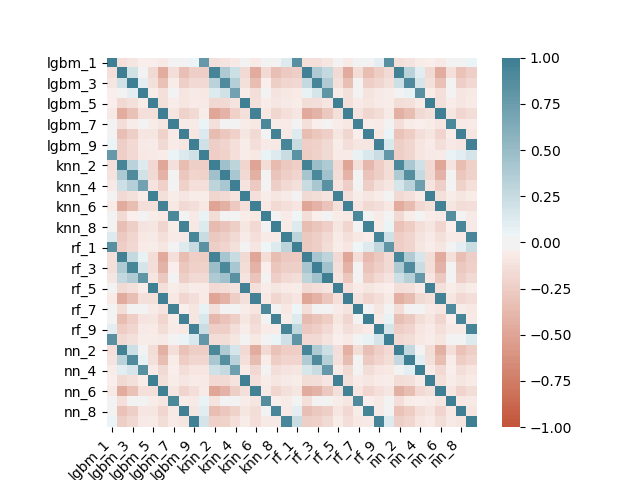

In [25]:
test_corr = results_submission.corr()

fig, ax = plt.subplots()
ax = sns.heatmap(
    test_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [36]:
def convert_to_single_col(df):
    models = ["lgbm_", "knn_", "rf_", "nn_"]
    result = []
    for m in models:
        cols = [m+str(i) for i in range(1,10)]
        temp = np.argmax(df[cols].values, axis=1)
        #print(temp.shape)
        result.append(temp)
        
    result.append(df["y_true"])
    result = np.stack(result, axis=1)
    #print(result.shape)
    return pd.DataFrame(result, columns=models+["y_true"])

results_train_1col = convert_to_single_col(results_train)
results_test_1col = convert_to_single_col(results_test)

In [37]:
train_corr = results_train_1col.drop(columns=["y_true"]).corr()
train_corr

,lgbm_,knn_,rf_,nn_
lgbm_,1.000000,0.889301,0.937636,0.908909
knn_,0.889301,1.000000,0.874691,0.847339
rf_,0.937636,0.874691,1.000000,0.884912
nn_,0.908909,0.847339,0.884912,1.000000


In [38]:
test_corr = results_test_1col.drop(columns=["y_true"]).corr()
test_corr

,lgbm_,knn_,rf_,nn_
lgbm_,1.000000,0.867390,0.931114,0.929400
knn_,0.867390,1.000000,0.866868,0.824963
rf_,0.931114,0.866868,1.000000,0.904519
nn_,0.929400,0.824963,0.904519,1.000000


In [120]:
models = ["lgbm_", "knn_", "rf_", "nn_"]
pd.set_option('display.expand_frame_repr', False)
result = []
for m in models:
    cols = [m+str(i) for i in range(1,10)]
    temp = np.argmax(results_train[cols].values, axis=1)
    cm = confusion_matrix_df(y_pred=temp, y_true=results_train["y_true"]).round(1)
    print("model: ", m)
    print(cm)

model:  lgbm_
           pred_1   pred_2  pred_3  pred_4  pred_5   pred_6  pred_7  pred_8  pred_9  recall
true_1      683.0     78.0    13.0     0.0     5.0    202.0    42.0   361.0   397.0     0.4
true_2        5.0  13040.0  1541.0    56.0    26.0     44.0    91.0    27.0    38.0     0.9
true_3        1.0   3619.0  3573.0    39.0     1.0     15.0   117.0    21.0    11.0     0.5
true_4        0.0   1074.0   466.0   786.0    17.0     83.0    27.0     1.0     3.0     0.3
true_5        1.0     73.0     1.0     0.0  2422.0      8.0     6.0     7.0     4.0     1.0
true_6       46.0    131.0    21.0     7.0     1.0  12232.0   160.0   227.0   154.0     0.9
true_7       30.0    325.0   197.0     8.0    10.0    212.0  1626.0   168.0    23.0     0.6
true_8       54.0     97.0    18.0     0.0     4.0    256.0    53.0  7204.0    93.0     0.9
true_9       60.0    123.0     5.0     1.0     2.0    174.0    24.0   186.0  3970.0     0.9
precision     0.8      0.7     0.6     0.9     1.0      0.9     0.

In [ ]:
# Try submitting only NN results
cols = ["nn_"+str(i) for i in range(1,10)]
results_nn = results_submission[cols]
results_nn = results_nn.rename(columns={
    "nn_"+str(i): "Class_"+str(i) for i in range(1,10)
})
results_nn.to_csv("submission_nn.csv")
results_nn.head()

# Train 2nd level model

In [115]:
n_classes = 9

level2_x = results_train.drop(columns=["y_true"])
level2_y = results_train["y_true"]

#level2_x_test = results_test.drop(columns=["y_true"])
#level2_y_test = results_test["y_true"]

level2_x_sub = results_submission

k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

params = {
    "learning_rate": 0.01,
    "num_leaves": 5,
    "n_estimators": 15000,
    "max_depth": 10,
    "min_data_in_leaf": 30,
    "subsample": 0.6,
    "bagging_freq": 3,
    "feature_fraction": 0.6,
    "early_stopping_rounds": 200,
}

In [110]:
train_feats, sub_feats = load_data("data/")
train_feats = train_feats.drop(columns=["target"])

Data shape: (61878, 94)


In [116]:
level2_x_sub_augmented = pd.concat([level2_x_sub, sub_feats.loc[level2_x_sub.index]], axis=1)
cols = level2_x_sub_augmented.columns

y_sub_pred = np.zeros((len(level2_x_sub), 9))
oof = np.zeros((len(level2_x), 9))
score = 0
feature_importance_df = pd.DataFrame()
valid_predict = []
for fold_n, (train_index, valid_index) in enumerate(cv.split(level2_x, level2_y)):
    print('Fold', k)
    X_train, X_valid = level2_x.iloc[train_index], level2_x.iloc[valid_index]
    y_train, y_valid = level2_y.iloc[train_index], level2_y.iloc[valid_index]
    
    # concat original features
    X_train = pd.concat([X_train, train_feats.loc[X_train.index]], axis=1)
    X_valid = pd.concat([X_valid, train_feats.loc[X_valid.index]], axis=1)
    
    clf = lgb.LGBMClassifier(silent=False, objective="softmax", 
                             num_class=n_classes, n_jobs=8, verbose=1, **params)
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)])
    
    y_valid_pred = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)
    score += log_loss(y_valid, y_valid_pred)
    oof[valid_index] = y_valid_pred
    print('Fold', fold_n, 'valid logloss', log_loss(y_valid, y_valid_pred))
    
    y_sub_pred += clf.predict_proba(level2_x_sub_augmented, num_iteration=clf.best_iteration_) / k
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = cols
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
print('valid logloss average:', score/k)

Fold 5


/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92151	valid_1's multi_logloss: 1.92181
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89445	valid_1's multi_logloss: 1.8949
[3]	training's multi_logloss: 1.86896	valid_1's multi_logloss: 1.86946
[4]	training's multi_logloss: 1.84475	valid_1's multi_logloss: 1.84537
[5]	training's multi_logloss: 1.82165	valid_1's multi_logloss: 1.82242
[6]	training's multi_logloss: 1.79924	valid_1's multi_logloss: 1.80003
[7]	training's multi_logloss: 1.77807	valid_1's multi_logloss: 1.77905
[8]	training's multi_logloss: 1.75764	valid_1's multi_logloss: 1.75876
[9]	training's multi_logloss: 1.73775	valid_1's multi_logloss: 1.73899
[10]	training's multi_logloss: 1.71872	valid_1's multi_logloss: 1.72008
[11]	training's multi_logloss: 1.69995	valid_1's multi_logloss: 1.70139
[12]	training's multi_logloss: 1.68193	valid_1's multi_logloss: 1.6835
[13]	training's multi_logloss: 1.66445	valid_1's multi_logloss: 1.66616
[14]	training

[118]	training's multi_logloss: 0.855598	valid_1's multi_logloss: 0.864055
[119]	training's multi_logloss: 0.852008	valid_1's multi_logloss: 0.86051
[120]	training's multi_logloss: 0.848471	valid_1's multi_logloss: 0.85702
[121]	training's multi_logloss: 0.845038	valid_1's multi_logloss: 0.853635
[122]	training's multi_logloss: 0.841611	valid_1's multi_logloss: 0.850273
[123]	training's multi_logloss: 0.838337	valid_1's multi_logloss: 0.847043
[124]	training's multi_logloss: 0.834954	valid_1's multi_logloss: 0.843692
[125]	training's multi_logloss: 0.831604	valid_1's multi_logloss: 0.840384
[126]	training's multi_logloss: 0.828319	valid_1's multi_logloss: 0.837153
[127]	training's multi_logloss: 0.825224	valid_1's multi_logloss: 0.834111
[128]	training's multi_logloss: 0.821985	valid_1's multi_logloss: 0.830924
[129]	training's multi_logloss: 0.818771	valid_1's multi_logloss: 0.827756
[130]	training's multi_logloss: 0.815614	valid_1's multi_logloss: 0.824632
[131]	training's multi_logl

[233]	training's multi_logloss: 0.616357	valid_1's multi_logloss: 0.629204
[234]	training's multi_logloss: 0.615228	valid_1's multi_logloss: 0.62811
[235]	training's multi_logloss: 0.614097	valid_1's multi_logloss: 0.627012
[236]	training's multi_logloss: 0.612992	valid_1's multi_logloss: 0.625951
[237]	training's multi_logloss: 0.611885	valid_1's multi_logloss: 0.624881
[238]	training's multi_logloss: 0.610845	valid_1's multi_logloss: 0.623877
[239]	training's multi_logloss: 0.609829	valid_1's multi_logloss: 0.622891
[240]	training's multi_logloss: 0.608769	valid_1's multi_logloss: 0.621864
[241]	training's multi_logloss: 0.607704	valid_1's multi_logloss: 0.620839
[242]	training's multi_logloss: 0.606652	valid_1's multi_logloss: 0.619831
[243]	training's multi_logloss: 0.605607	valid_1's multi_logloss: 0.618818
[244]	training's multi_logloss: 0.604583	valid_1's multi_logloss: 0.617838
[245]	training's multi_logloss: 0.603587	valid_1's multi_logloss: 0.616888
[246]	training's multi_log

[350]	training's multi_logloss: 0.533104	valid_1's multi_logloss: 0.550222
[351]	training's multi_logloss: 0.53267	valid_1's multi_logloss: 0.54981
[352]	training's multi_logloss: 0.532238	valid_1's multi_logloss: 0.549415
[353]	training's multi_logloss: 0.531821	valid_1's multi_logloss: 0.54903
[354]	training's multi_logloss: 0.53139	valid_1's multi_logloss: 0.548648
[355]	training's multi_logloss: 0.53097	valid_1's multi_logloss: 0.548265
[356]	training's multi_logloss: 0.530557	valid_1's multi_logloss: 0.547876
[357]	training's multi_logloss: 0.53014	valid_1's multi_logloss: 0.54751
[358]	training's multi_logloss: 0.529724	valid_1's multi_logloss: 0.547134
[359]	training's multi_logloss: 0.529312	valid_1's multi_logloss: 0.546779
[360]	training's multi_logloss: 0.528904	valid_1's multi_logloss: 0.546409
[361]	training's multi_logloss: 0.528504	valid_1's multi_logloss: 0.546046
[362]	training's multi_logloss: 0.52812	valid_1's multi_logloss: 0.545697
[363]	training's multi_logloss: 0

[463]	training's multi_logloss: 0.499082	valid_1's multi_logloss: 0.520586
[464]	training's multi_logloss: 0.498872	valid_1's multi_logloss: 0.520418
[465]	training's multi_logloss: 0.498664	valid_1's multi_logloss: 0.52025
[466]	training's multi_logloss: 0.498463	valid_1's multi_logloss: 0.520073
[467]	training's multi_logloss: 0.498253	valid_1's multi_logloss: 0.519903
[468]	training's multi_logloss: 0.498044	valid_1's multi_logloss: 0.519726
[469]	training's multi_logloss: 0.497829	valid_1's multi_logloss: 0.519553
[470]	training's multi_logloss: 0.497617	valid_1's multi_logloss: 0.519373
[471]	training's multi_logloss: 0.49741	valid_1's multi_logloss: 0.519223
[472]	training's multi_logloss: 0.497207	valid_1's multi_logloss: 0.519062
[473]	training's multi_logloss: 0.496999	valid_1's multi_logloss: 0.518891
[474]	training's multi_logloss: 0.496794	valid_1's multi_logloss: 0.518732
[475]	training's multi_logloss: 0.496602	valid_1's multi_logloss: 0.518573
[476]	training's multi_logl

[575]	training's multi_logloss: 0.481165	valid_1's multi_logloss: 0.507098
[576]	training's multi_logloss: 0.481044	valid_1's multi_logloss: 0.507018
[577]	training's multi_logloss: 0.48093	valid_1's multi_logloss: 0.506942
[578]	training's multi_logloss: 0.480812	valid_1's multi_logloss: 0.506866
[579]	training's multi_logloss: 0.480686	valid_1's multi_logloss: 0.506787
[580]	training's multi_logloss: 0.480564	valid_1's multi_logloss: 0.506711
[581]	training's multi_logloss: 0.480452	valid_1's multi_logloss: 0.506626
[582]	training's multi_logloss: 0.480327	valid_1's multi_logloss: 0.506542
[583]	training's multi_logloss: 0.480209	valid_1's multi_logloss: 0.506454
[584]	training's multi_logloss: 0.480097	valid_1's multi_logloss: 0.506378
[585]	training's multi_logloss: 0.479974	valid_1's multi_logloss: 0.506303
[586]	training's multi_logloss: 0.479857	valid_1's multi_logloss: 0.506228
[587]	training's multi_logloss: 0.47974	valid_1's multi_logloss: 0.506137
[588]	training's multi_logl

[687]	training's multi_logloss: 0.46987	valid_1's multi_logloss: 0.500248
[688]	training's multi_logloss: 0.469792	valid_1's multi_logloss: 0.500197
[689]	training's multi_logloss: 0.46971	valid_1's multi_logloss: 0.500141
[690]	training's multi_logloss: 0.469626	valid_1's multi_logloss: 0.500097
[691]	training's multi_logloss: 0.469539	valid_1's multi_logloss: 0.500052
[692]	training's multi_logloss: 0.469457	valid_1's multi_logloss: 0.500018
[693]	training's multi_logloss: 0.469381	valid_1's multi_logloss: 0.499978
[694]	training's multi_logloss: 0.469294	valid_1's multi_logloss: 0.499942
[695]	training's multi_logloss: 0.469205	valid_1's multi_logloss: 0.499895
[696]	training's multi_logloss: 0.469122	valid_1's multi_logloss: 0.499862
[697]	training's multi_logloss: 0.469038	valid_1's multi_logloss: 0.499816
[698]	training's multi_logloss: 0.468957	valid_1's multi_logloss: 0.499782
[699]	training's multi_logloss: 0.468874	valid_1's multi_logloss: 0.499741
[700]	training's multi_logl

[802]	training's multi_logloss: 0.461479	valid_1's multi_logloss: 0.496226
[803]	training's multi_logloss: 0.461416	valid_1's multi_logloss: 0.4962
[804]	training's multi_logloss: 0.461353	valid_1's multi_logloss: 0.49617
[805]	training's multi_logloss: 0.461284	valid_1's multi_logloss: 0.496147
[806]	training's multi_logloss: 0.461222	valid_1's multi_logloss: 0.496116
[807]	training's multi_logloss: 0.461155	valid_1's multi_logloss: 0.496097
[808]	training's multi_logloss: 0.461092	valid_1's multi_logloss: 0.496078
[809]	training's multi_logloss: 0.461025	valid_1's multi_logloss: 0.496053
[810]	training's multi_logloss: 0.460964	valid_1's multi_logloss: 0.496015
[811]	training's multi_logloss: 0.460903	valid_1's multi_logloss: 0.495987
[812]	training's multi_logloss: 0.460843	valid_1's multi_logloss: 0.495952
[813]	training's multi_logloss: 0.460774	valid_1's multi_logloss: 0.495926
[814]	training's multi_logloss: 0.46071	valid_1's multi_logloss: 0.495898
[815]	training's multi_loglos

[917]	training's multi_logloss: 0.454855	valid_1's multi_logloss: 0.493647
[918]	training's multi_logloss: 0.454802	valid_1's multi_logloss: 0.493624
[919]	training's multi_logloss: 0.454752	valid_1's multi_logloss: 0.4936
[920]	training's multi_logloss: 0.454701	valid_1's multi_logloss: 0.493566
[921]	training's multi_logloss: 0.454647	valid_1's multi_logloss: 0.493545
[922]	training's multi_logloss: 0.454596	valid_1's multi_logloss: 0.493529
[923]	training's multi_logloss: 0.454544	valid_1's multi_logloss: 0.493516
[924]	training's multi_logloss: 0.454488	valid_1's multi_logloss: 0.493497
[925]	training's multi_logloss: 0.454432	valid_1's multi_logloss: 0.493484
[926]	training's multi_logloss: 0.454379	valid_1's multi_logloss: 0.493457
[927]	training's multi_logloss: 0.454334	valid_1's multi_logloss: 0.493437
[928]	training's multi_logloss: 0.454277	valid_1's multi_logloss: 0.493431
[929]	training's multi_logloss: 0.454225	valid_1's multi_logloss: 0.493416
[930]	training's multi_logl

[1033]	training's multi_logloss: 0.449271	valid_1's multi_logloss: 0.492044
[1034]	training's multi_logloss: 0.44923	valid_1's multi_logloss: 0.492031
[1035]	training's multi_logloss: 0.449193	valid_1's multi_logloss: 0.492018
[1036]	training's multi_logloss: 0.449143	valid_1's multi_logloss: 0.492002
[1037]	training's multi_logloss: 0.449099	valid_1's multi_logloss: 0.491988
[1038]	training's multi_logloss: 0.449056	valid_1's multi_logloss: 0.49197
[1039]	training's multi_logloss: 0.449011	valid_1's multi_logloss: 0.491954
[1040]	training's multi_logloss: 0.448969	valid_1's multi_logloss: 0.491936
[1041]	training's multi_logloss: 0.448923	valid_1's multi_logloss: 0.491922
[1042]	training's multi_logloss: 0.448875	valid_1's multi_logloss: 0.49191
[1043]	training's multi_logloss: 0.448831	valid_1's multi_logloss: 0.491898
[1044]	training's multi_logloss: 0.448784	valid_1's multi_logloss: 0.491887
[1045]	training's multi_logloss: 0.44874	valid_1's multi_logloss: 0.491883
[1046]	training'

[1149]	training's multi_logloss: 0.444364	valid_1's multi_logloss: 0.4908
[1150]	training's multi_logloss: 0.44432	valid_1's multi_logloss: 0.490786
[1151]	training's multi_logloss: 0.444281	valid_1's multi_logloss: 0.490778
[1152]	training's multi_logloss: 0.444238	valid_1's multi_logloss: 0.490757
[1153]	training's multi_logloss: 0.444195	valid_1's multi_logloss: 0.490749
[1154]	training's multi_logloss: 0.444158	valid_1's multi_logloss: 0.49074
[1155]	training's multi_logloss: 0.444119	valid_1's multi_logloss: 0.490732
[1156]	training's multi_logloss: 0.444082	valid_1's multi_logloss: 0.490714
[1157]	training's multi_logloss: 0.444041	valid_1's multi_logloss: 0.4907
[1158]	training's multi_logloss: 0.444007	valid_1's multi_logloss: 0.490688
[1159]	training's multi_logloss: 0.443964	valid_1's multi_logloss: 0.490679
[1160]	training's multi_logloss: 0.443924	valid_1's multi_logloss: 0.490671
[1161]	training's multi_logloss: 0.443885	valid_1's multi_logloss: 0.490655
[1162]	training's 

[1267]	training's multi_logloss: 0.439715	valid_1's multi_logloss: 0.489597
[1268]	training's multi_logloss: 0.43968	valid_1's multi_logloss: 0.489592
[1269]	training's multi_logloss: 0.439642	valid_1's multi_logloss: 0.489587
[1270]	training's multi_logloss: 0.439608	valid_1's multi_logloss: 0.489581
[1271]	training's multi_logloss: 0.439573	valid_1's multi_logloss: 0.489574
[1272]	training's multi_logloss: 0.439537	valid_1's multi_logloss: 0.489579
[1273]	training's multi_logloss: 0.4395	valid_1's multi_logloss: 0.489582
[1274]	training's multi_logloss: 0.439461	valid_1's multi_logloss: 0.489585
[1275]	training's multi_logloss: 0.439424	valid_1's multi_logloss: 0.489593
[1276]	training's multi_logloss: 0.439383	valid_1's multi_logloss: 0.489585
[1277]	training's multi_logloss: 0.439341	valid_1's multi_logloss: 0.489586
[1278]	training's multi_logloss: 0.439302	valid_1's multi_logloss: 0.489579
[1279]	training's multi_logloss: 0.439266	valid_1's multi_logloss: 0.489565
[1280]	training

[1376]	training's multi_logloss: 0.435747	valid_1's multi_logloss: 0.488819
[1377]	training's multi_logloss: 0.435715	valid_1's multi_logloss: 0.488809
[1378]	training's multi_logloss: 0.435678	valid_1's multi_logloss: 0.488799
[1379]	training's multi_logloss: 0.435642	valid_1's multi_logloss: 0.488786
[1380]	training's multi_logloss: 0.435601	valid_1's multi_logloss: 0.488776
[1381]	training's multi_logloss: 0.435562	valid_1's multi_logloss: 0.488762
[1382]	training's multi_logloss: 0.435528	valid_1's multi_logloss: 0.488761
[1383]	training's multi_logloss: 0.43549	valid_1's multi_logloss: 0.488758
[1384]	training's multi_logloss: 0.435457	valid_1's multi_logloss: 0.488755
[1385]	training's multi_logloss: 0.435424	valid_1's multi_logloss: 0.488759
[1386]	training's multi_logloss: 0.435392	valid_1's multi_logloss: 0.488749
[1387]	training's multi_logloss: 0.435359	valid_1's multi_logloss: 0.488741
[1388]	training's multi_logloss: 0.435324	valid_1's multi_logloss: 0.48873
[1389]	trainin

[1494]	training's multi_logloss: 0.431633	valid_1's multi_logloss: 0.48798
[1495]	training's multi_logloss: 0.4316	valid_1's multi_logloss: 0.487969
[1496]	training's multi_logloss: 0.43156	valid_1's multi_logloss: 0.487942
[1497]	training's multi_logloss: 0.431527	valid_1's multi_logloss: 0.487925
[1498]	training's multi_logloss: 0.431495	valid_1's multi_logloss: 0.487918
[1499]	training's multi_logloss: 0.431462	valid_1's multi_logloss: 0.487902
[1500]	training's multi_logloss: 0.431429	valid_1's multi_logloss: 0.487898
[1501]	training's multi_logloss: 0.431397	valid_1's multi_logloss: 0.487897
[1502]	training's multi_logloss: 0.431364	valid_1's multi_logloss: 0.487897
[1503]	training's multi_logloss: 0.431333	valid_1's multi_logloss: 0.487884
[1504]	training's multi_logloss: 0.431297	valid_1's multi_logloss: 0.487864
[1505]	training's multi_logloss: 0.431262	valid_1's multi_logloss: 0.487843
[1506]	training's multi_logloss: 0.431228	valid_1's multi_logloss: 0.487835
[1507]	training'

[1612]	training's multi_logloss: 0.427629	valid_1's multi_logloss: 0.487197
[1613]	training's multi_logloss: 0.427598	valid_1's multi_logloss: 0.487192
[1614]	training's multi_logloss: 0.427565	valid_1's multi_logloss: 0.487181
[1615]	training's multi_logloss: 0.427533	valid_1's multi_logloss: 0.487171
[1616]	training's multi_logloss: 0.427501	valid_1's multi_logloss: 0.487164
[1617]	training's multi_logloss: 0.427471	valid_1's multi_logloss: 0.487153
[1618]	training's multi_logloss: 0.427439	valid_1's multi_logloss: 0.487143
[1619]	training's multi_logloss: 0.427396	valid_1's multi_logloss: 0.48713
[1620]	training's multi_logloss: 0.427349	valid_1's multi_logloss: 0.487125
[1621]	training's multi_logloss: 0.427312	valid_1's multi_logloss: 0.487116
[1622]	training's multi_logloss: 0.42728	valid_1's multi_logloss: 0.487101
[1623]	training's multi_logloss: 0.427246	valid_1's multi_logloss: 0.487097
[1624]	training's multi_logloss: 0.427214	valid_1's multi_logloss: 0.487082
[1625]	trainin

[1730]	training's multi_logloss: 0.423813	valid_1's multi_logloss: 0.486473
[1731]	training's multi_logloss: 0.423782	valid_1's multi_logloss: 0.486468
[1732]	training's multi_logloss: 0.423752	valid_1's multi_logloss: 0.48646
[1733]	training's multi_logloss: 0.423723	valid_1's multi_logloss: 0.486458
[1734]	training's multi_logloss: 0.423695	valid_1's multi_logloss: 0.486446
[1735]	training's multi_logloss: 0.423665	valid_1's multi_logloss: 0.486443
[1736]	training's multi_logloss: 0.423634	valid_1's multi_logloss: 0.486438
[1737]	training's multi_logloss: 0.423597	valid_1's multi_logloss: 0.486429
[1738]	training's multi_logloss: 0.42357	valid_1's multi_logloss: 0.486418
[1739]	training's multi_logloss: 0.423538	valid_1's multi_logloss: 0.486417
[1740]	training's multi_logloss: 0.423509	valid_1's multi_logloss: 0.486417
[1741]	training's multi_logloss: 0.423481	valid_1's multi_logloss: 0.486417
[1742]	training's multi_logloss: 0.423453	valid_1's multi_logloss: 0.486419
[1743]	trainin

[1848]	training's multi_logloss: 0.420176	valid_1's multi_logloss: 0.485907
[1849]	training's multi_logloss: 0.42015	valid_1's multi_logloss: 0.485911
[1850]	training's multi_logloss: 0.420123	valid_1's multi_logloss: 0.48591
[1851]	training's multi_logloss: 0.420094	valid_1's multi_logloss: 0.485907
[1852]	training's multi_logloss: 0.420056	valid_1's multi_logloss: 0.485884
[1853]	training's multi_logloss: 0.420027	valid_1's multi_logloss: 0.485892
[1854]	training's multi_logloss: 0.419996	valid_1's multi_logloss: 0.485891
[1855]	training's multi_logloss: 0.419968	valid_1's multi_logloss: 0.485891
[1856]	training's multi_logloss: 0.419938	valid_1's multi_logloss: 0.485884
[1857]	training's multi_logloss: 0.419905	valid_1's multi_logloss: 0.485871
[1858]	training's multi_logloss: 0.419874	valid_1's multi_logloss: 0.485866
[1859]	training's multi_logloss: 0.419843	valid_1's multi_logloss: 0.485863
[1860]	training's multi_logloss: 0.419812	valid_1's multi_logloss: 0.485855
[1861]	trainin

[1965]	training's multi_logloss: 0.416648	valid_1's multi_logloss: 0.485349
[1966]	training's multi_logloss: 0.416619	valid_1's multi_logloss: 0.485343
[1967]	training's multi_logloss: 0.416589	valid_1's multi_logloss: 0.485347
[1968]	training's multi_logloss: 0.416559	valid_1's multi_logloss: 0.485338
[1969]	training's multi_logloss: 0.416531	valid_1's multi_logloss: 0.485337
[1970]	training's multi_logloss: 0.416506	valid_1's multi_logloss: 0.485338
[1971]	training's multi_logloss: 0.416477	valid_1's multi_logloss: 0.485333
[1972]	training's multi_logloss: 0.416448	valid_1's multi_logloss: 0.485336
[1973]	training's multi_logloss: 0.416418	valid_1's multi_logloss: 0.485336
[1974]	training's multi_logloss: 0.416388	valid_1's multi_logloss: 0.485335
[1975]	training's multi_logloss: 0.41636	valid_1's multi_logloss: 0.485335
[1976]	training's multi_logloss: 0.416333	valid_1's multi_logloss: 0.485335
[1977]	training's multi_logloss: 0.416302	valid_1's multi_logloss: 0.485336
[1978]	traini

[2082]	training's multi_logloss: 0.413282	valid_1's multi_logloss: 0.484972
[2083]	training's multi_logloss: 0.413252	valid_1's multi_logloss: 0.484963
[2084]	training's multi_logloss: 0.413227	valid_1's multi_logloss: 0.484964
[2085]	training's multi_logloss: 0.413196	valid_1's multi_logloss: 0.48496
[2086]	training's multi_logloss: 0.413167	valid_1's multi_logloss: 0.484954
[2087]	training's multi_logloss: 0.413135	valid_1's multi_logloss: 0.484953
[2088]	training's multi_logloss: 0.413106	valid_1's multi_logloss: 0.484953
[2089]	training's multi_logloss: 0.413077	valid_1's multi_logloss: 0.484943
[2090]	training's multi_logloss: 0.413045	valid_1's multi_logloss: 0.484929
[2091]	training's multi_logloss: 0.413018	valid_1's multi_logloss: 0.484919
[2092]	training's multi_logloss: 0.412989	valid_1's multi_logloss: 0.484916
[2093]	training's multi_logloss: 0.41296	valid_1's multi_logloss: 0.484913
[2094]	training's multi_logloss: 0.412928	valid_1's multi_logloss: 0.484907
[2095]	trainin

[2198]	training's multi_logloss: 0.409969	valid_1's multi_logloss: 0.484547
[2199]	training's multi_logloss: 0.409936	valid_1's multi_logloss: 0.484546
[2200]	training's multi_logloss: 0.409906	valid_1's multi_logloss: 0.484544
[2201]	training's multi_logloss: 0.409878	valid_1's multi_logloss: 0.484544
[2202]	training's multi_logloss: 0.40985	valid_1's multi_logloss: 0.484545
[2203]	training's multi_logloss: 0.409819	valid_1's multi_logloss: 0.484546
[2204]	training's multi_logloss: 0.409792	valid_1's multi_logloss: 0.484541
[2205]	training's multi_logloss: 0.409762	valid_1's multi_logloss: 0.48454
[2206]	training's multi_logloss: 0.409733	valid_1's multi_logloss: 0.484528
[2207]	training's multi_logloss: 0.409707	valid_1's multi_logloss: 0.484528
[2208]	training's multi_logloss: 0.40968	valid_1's multi_logloss: 0.484533
[2209]	training's multi_logloss: 0.409654	valid_1's multi_logloss: 0.484527
[2210]	training's multi_logloss: 0.409631	valid_1's multi_logloss: 0.484518
[2211]	training

[2314]	training's multi_logloss: 0.406827	valid_1's multi_logloss: 0.484156
[2315]	training's multi_logloss: 0.406798	valid_1's multi_logloss: 0.484157
[2316]	training's multi_logloss: 0.40677	valid_1's multi_logloss: 0.484158
[2317]	training's multi_logloss: 0.406745	valid_1's multi_logloss: 0.484161
[2318]	training's multi_logloss: 0.406718	valid_1's multi_logloss: 0.484158
[2319]	training's multi_logloss: 0.406691	valid_1's multi_logloss: 0.484158
[2320]	training's multi_logloss: 0.406663	valid_1's multi_logloss: 0.484148
[2321]	training's multi_logloss: 0.406635	valid_1's multi_logloss: 0.484135
[2322]	training's multi_logloss: 0.40661	valid_1's multi_logloss: 0.48412
[2323]	training's multi_logloss: 0.406578	valid_1's multi_logloss: 0.484124
[2324]	training's multi_logloss: 0.406546	valid_1's multi_logloss: 0.484123
[2325]	training's multi_logloss: 0.40652	valid_1's multi_logloss: 0.484128
[2326]	training's multi_logloss: 0.406494	valid_1's multi_logloss: 0.484129
[2327]	training'

[2423]	training's multi_logloss: 0.403886	valid_1's multi_logloss: 0.483941
[2424]	training's multi_logloss: 0.403859	valid_1's multi_logloss: 0.483945
[2425]	training's multi_logloss: 0.403833	valid_1's multi_logloss: 0.483943
[2426]	training's multi_logloss: 0.403807	valid_1's multi_logloss: 0.483937
[2427]	training's multi_logloss: 0.403778	valid_1's multi_logloss: 0.483931
[2428]	training's multi_logloss: 0.403754	valid_1's multi_logloss: 0.483932
[2429]	training's multi_logloss: 0.403728	valid_1's multi_logloss: 0.483937
[2430]	training's multi_logloss: 0.403701	valid_1's multi_logloss: 0.483938
[2431]	training's multi_logloss: 0.403676	valid_1's multi_logloss: 0.483935
[2432]	training's multi_logloss: 0.403648	valid_1's multi_logloss: 0.483932
[2433]	training's multi_logloss: 0.403622	valid_1's multi_logloss: 0.483929
[2434]	training's multi_logloss: 0.403592	valid_1's multi_logloss: 0.483927
[2435]	training's multi_logloss: 0.403568	valid_1's multi_logloss: 0.483931
[2436]	train

[2539]	training's multi_logloss: 0.400849	valid_1's multi_logloss: 0.483619
[2540]	training's multi_logloss: 0.400819	valid_1's multi_logloss: 0.483603
[2541]	training's multi_logloss: 0.40079	valid_1's multi_logloss: 0.483592
[2542]	training's multi_logloss: 0.400759	valid_1's multi_logloss: 0.483586
[2543]	training's multi_logloss: 0.400733	valid_1's multi_logloss: 0.483582
[2544]	training's multi_logloss: 0.400704	valid_1's multi_logloss: 0.483583
[2545]	training's multi_logloss: 0.40068	valid_1's multi_logloss: 0.48358
[2546]	training's multi_logloss: 0.400655	valid_1's multi_logloss: 0.483575
[2547]	training's multi_logloss: 0.400629	valid_1's multi_logloss: 0.483575
[2548]	training's multi_logloss: 0.400602	valid_1's multi_logloss: 0.483576
[2549]	training's multi_logloss: 0.40058	valid_1's multi_logloss: 0.483572
[2550]	training's multi_logloss: 0.400556	valid_1's multi_logloss: 0.483565
[2551]	training's multi_logloss: 0.400527	valid_1's multi_logloss: 0.483565
[2552]	training'

[2655]	training's multi_logloss: 0.397859	valid_1's multi_logloss: 0.483391
[2656]	training's multi_logloss: 0.397835	valid_1's multi_logloss: 0.483388
[2657]	training's multi_logloss: 0.39781	valid_1's multi_logloss: 0.483394
[2658]	training's multi_logloss: 0.397785	valid_1's multi_logloss: 0.483396
[2659]	training's multi_logloss: 0.39776	valid_1's multi_logloss: 0.483388
[2660]	training's multi_logloss: 0.397736	valid_1's multi_logloss: 0.483376
[2661]	training's multi_logloss: 0.39771	valid_1's multi_logloss: 0.483369
[2662]	training's multi_logloss: 0.397688	valid_1's multi_logloss: 0.483367
[2663]	training's multi_logloss: 0.397659	valid_1's multi_logloss: 0.483371
[2664]	training's multi_logloss: 0.397634	valid_1's multi_logloss: 0.483368
[2665]	training's multi_logloss: 0.397606	valid_1's multi_logloss: 0.483361
[2666]	training's multi_logloss: 0.39758	valid_1's multi_logloss: 0.483352
[2667]	training's multi_logloss: 0.397557	valid_1's multi_logloss: 0.483341
[2668]	training'

[2771]	training's multi_logloss: 0.394923	valid_1's multi_logloss: 0.483079
[2772]	training's multi_logloss: 0.394899	valid_1's multi_logloss: 0.483079
[2773]	training's multi_logloss: 0.394876	valid_1's multi_logloss: 0.48307
[2774]	training's multi_logloss: 0.394845	valid_1's multi_logloss: 0.483065
[2775]	training's multi_logloss: 0.394823	valid_1's multi_logloss: 0.48306
[2776]	training's multi_logloss: 0.394801	valid_1's multi_logloss: 0.483055
[2777]	training's multi_logloss: 0.394777	valid_1's multi_logloss: 0.483053
[2778]	training's multi_logloss: 0.394751	valid_1's multi_logloss: 0.483056
[2779]	training's multi_logloss: 0.394725	valid_1's multi_logloss: 0.483044
[2780]	training's multi_logloss: 0.394703	valid_1's multi_logloss: 0.483044
[2781]	training's multi_logloss: 0.394677	valid_1's multi_logloss: 0.483033
[2782]	training's multi_logloss: 0.394651	valid_1's multi_logloss: 0.483027
[2783]	training's multi_logloss: 0.394625	valid_1's multi_logloss: 0.483028
[2784]	trainin

[2880]	training's multi_logloss: 0.392276	valid_1's multi_logloss: 0.482758
[2881]	training's multi_logloss: 0.392252	valid_1's multi_logloss: 0.482753
[2882]	training's multi_logloss: 0.392225	valid_1's multi_logloss: 0.482758
[2883]	training's multi_logloss: 0.392201	valid_1's multi_logloss: 0.482763
[2884]	training's multi_logloss: 0.392175	valid_1's multi_logloss: 0.482757
[2885]	training's multi_logloss: 0.392148	valid_1's multi_logloss: 0.482756
[2886]	training's multi_logloss: 0.392125	valid_1's multi_logloss: 0.482763
[2887]	training's multi_logloss: 0.392105	valid_1's multi_logloss: 0.482763
[2888]	training's multi_logloss: 0.392082	valid_1's multi_logloss: 0.482762
[2889]	training's multi_logloss: 0.392055	valid_1's multi_logloss: 0.482759
[2890]	training's multi_logloss: 0.392029	valid_1's multi_logloss: 0.48276
[2891]	training's multi_logloss: 0.392006	valid_1's multi_logloss: 0.482758
[2892]	training's multi_logloss: 0.391981	valid_1's multi_logloss: 0.482754
[2893]	traini

[2996]	training's multi_logloss: 0.389483	valid_1's multi_logloss: 0.482563
[2997]	training's multi_logloss: 0.389458	valid_1's multi_logloss: 0.482563
[2998]	training's multi_logloss: 0.389435	valid_1's multi_logloss: 0.482553
[2999]	training's multi_logloss: 0.389413	valid_1's multi_logloss: 0.48255
[3000]	training's multi_logloss: 0.38939	valid_1's multi_logloss: 0.482547
[3001]	training's multi_logloss: 0.389366	valid_1's multi_logloss: 0.482544
[3002]	training's multi_logloss: 0.389345	valid_1's multi_logloss: 0.482537
[3003]	training's multi_logloss: 0.389321	valid_1's multi_logloss: 0.482536
[3004]	training's multi_logloss: 0.3893	valid_1's multi_logloss: 0.482521
[3005]	training's multi_logloss: 0.389277	valid_1's multi_logloss: 0.48252
[3006]	training's multi_logloss: 0.389256	valid_1's multi_logloss: 0.482524
[3007]	training's multi_logloss: 0.38923	valid_1's multi_logloss: 0.482524
[3008]	training's multi_logloss: 0.389203	valid_1's multi_logloss: 0.482515
[3009]	training's 

[3112]	training's multi_logloss: 0.386777	valid_1's multi_logloss: 0.482272
[3113]	training's multi_logloss: 0.386758	valid_1's multi_logloss: 0.482274
[3114]	training's multi_logloss: 0.386737	valid_1's multi_logloss: 0.482271
[3115]	training's multi_logloss: 0.386714	valid_1's multi_logloss: 0.482266
[3116]	training's multi_logloss: 0.386693	valid_1's multi_logloss: 0.482264
[3117]	training's multi_logloss: 0.386673	valid_1's multi_logloss: 0.482268
[3118]	training's multi_logloss: 0.386652	valid_1's multi_logloss: 0.482263
[3119]	training's multi_logloss: 0.386626	valid_1's multi_logloss: 0.482256
[3120]	training's multi_logloss: 0.386605	valid_1's multi_logloss: 0.482247
[3121]	training's multi_logloss: 0.386585	valid_1's multi_logloss: 0.482246
[3122]	training's multi_logloss: 0.386564	valid_1's multi_logloss: 0.482241
[3123]	training's multi_logloss: 0.386543	valid_1's multi_logloss: 0.482239
[3124]	training's multi_logloss: 0.386516	valid_1's multi_logloss: 0.48224
[3125]	traini

[3227]	training's multi_logloss: 0.384137	valid_1's multi_logloss: 0.482005
[3228]	training's multi_logloss: 0.384111	valid_1's multi_logloss: 0.482001
[3229]	training's multi_logloss: 0.384089	valid_1's multi_logloss: 0.482006
[3230]	training's multi_logloss: 0.384067	valid_1's multi_logloss: 0.482001
[3231]	training's multi_logloss: 0.384044	valid_1's multi_logloss: 0.482003
[3232]	training's multi_logloss: 0.384018	valid_1's multi_logloss: 0.482006
[3233]	training's multi_logloss: 0.383997	valid_1's multi_logloss: 0.482005
[3234]	training's multi_logloss: 0.383978	valid_1's multi_logloss: 0.482
[3235]	training's multi_logloss: 0.383957	valid_1's multi_logloss: 0.481992
[3236]	training's multi_logloss: 0.38393	valid_1's multi_logloss: 0.481991
[3237]	training's multi_logloss: 0.383907	valid_1's multi_logloss: 0.481984
[3238]	training's multi_logloss: 0.383886	valid_1's multi_logloss: 0.481973
[3239]	training's multi_logloss: 0.383859	valid_1's multi_logloss: 0.481965
[3240]	training'

[3336]	training's multi_logloss: 0.381652	valid_1's multi_logloss: 0.481715
[3337]	training's multi_logloss: 0.381632	valid_1's multi_logloss: 0.481723
[3338]	training's multi_logloss: 0.381608	valid_1's multi_logloss: 0.481718
[3339]	training's multi_logloss: 0.381587	valid_1's multi_logloss: 0.481717
[3340]	training's multi_logloss: 0.381566	valid_1's multi_logloss: 0.48172
[3341]	training's multi_logloss: 0.381547	valid_1's multi_logloss: 0.481723
[3342]	training's multi_logloss: 0.381523	valid_1's multi_logloss: 0.481729
[3343]	training's multi_logloss: 0.381499	valid_1's multi_logloss: 0.48172
[3344]	training's multi_logloss: 0.38148	valid_1's multi_logloss: 0.481718
[3345]	training's multi_logloss: 0.381453	valid_1's multi_logloss: 0.481703
[3346]	training's multi_logloss: 0.381433	valid_1's multi_logloss: 0.481703
[3347]	training's multi_logloss: 0.381411	valid_1's multi_logloss: 0.481704
[3348]	training's multi_logloss: 0.381387	valid_1's multi_logloss: 0.481707
[3349]	training

[3452]	training's multi_logloss: 0.379165	valid_1's multi_logloss: 0.481647
[3453]	training's multi_logloss: 0.379142	valid_1's multi_logloss: 0.481648
[3454]	training's multi_logloss: 0.379122	valid_1's multi_logloss: 0.481649
[3455]	training's multi_logloss: 0.379101	valid_1's multi_logloss: 0.481639
[3456]	training's multi_logloss: 0.37908	valid_1's multi_logloss: 0.481638
[3457]	training's multi_logloss: 0.379056	valid_1's multi_logloss: 0.481644
[3458]	training's multi_logloss: 0.379031	valid_1's multi_logloss: 0.481642
[3459]	training's multi_logloss: 0.37901	valid_1's multi_logloss: 0.481643
[3460]	training's multi_logloss: 0.378989	valid_1's multi_logloss: 0.481638
[3461]	training's multi_logloss: 0.378967	valid_1's multi_logloss: 0.481637
[3462]	training's multi_logloss: 0.378944	valid_1's multi_logloss: 0.481633
[3463]	training's multi_logloss: 0.378922	valid_1's multi_logloss: 0.48162
[3464]	training's multi_logloss: 0.378898	valid_1's multi_logloss: 0.481611
[3465]	training

[3569]	training's multi_logloss: 0.376625	valid_1's multi_logloss: 0.481487
[3570]	training's multi_logloss: 0.376605	valid_1's multi_logloss: 0.481483
[3571]	training's multi_logloss: 0.376587	valid_1's multi_logloss: 0.481476
[3572]	training's multi_logloss: 0.376567	valid_1's multi_logloss: 0.481469
[3573]	training's multi_logloss: 0.376547	valid_1's multi_logloss: 0.481466
[3574]	training's multi_logloss: 0.376524	valid_1's multi_logloss: 0.481462
[3575]	training's multi_logloss: 0.376502	valid_1's multi_logloss: 0.481464
[3576]	training's multi_logloss: 0.376479	valid_1's multi_logloss: 0.481465
[3577]	training's multi_logloss: 0.376453	valid_1's multi_logloss: 0.481467
[3578]	training's multi_logloss: 0.376432	valid_1's multi_logloss: 0.481466
[3579]	training's multi_logloss: 0.376409	valid_1's multi_logloss: 0.481462
[3580]	training's multi_logloss: 0.376389	valid_1's multi_logloss: 0.481455
[3581]	training's multi_logloss: 0.37637	valid_1's multi_logloss: 0.481451
[3582]	traini

[3687]	training's multi_logloss: 0.374137	valid_1's multi_logloss: 0.481355
[3688]	training's multi_logloss: 0.374118	valid_1's multi_logloss: 0.481358
[3689]	training's multi_logloss: 0.374097	valid_1's multi_logloss: 0.481363
[3690]	training's multi_logloss: 0.374071	valid_1's multi_logloss: 0.481367
[3691]	training's multi_logloss: 0.374049	valid_1's multi_logloss: 0.481363
[3692]	training's multi_logloss: 0.37403	valid_1's multi_logloss: 0.481367
[3693]	training's multi_logloss: 0.374009	valid_1's multi_logloss: 0.481366
[3694]	training's multi_logloss: 0.373987	valid_1's multi_logloss: 0.48137
[3695]	training's multi_logloss: 0.373968	valid_1's multi_logloss: 0.48137
[3696]	training's multi_logloss: 0.373944	valid_1's multi_logloss: 0.481373
[3697]	training's multi_logloss: 0.373926	valid_1's multi_logloss: 0.481378
[3698]	training's multi_logloss: 0.373907	valid_1's multi_logloss: 0.481379
[3699]	training's multi_logloss: 0.373887	valid_1's multi_logloss: 0.481381
[3700]	training

[3803]	training's multi_logloss: 0.371709	valid_1's multi_logloss: 0.481233
[3804]	training's multi_logloss: 0.371682	valid_1's multi_logloss: 0.481234
[3805]	training's multi_logloss: 0.37166	valid_1's multi_logloss: 0.481236
[3806]	training's multi_logloss: 0.371641	valid_1's multi_logloss: 0.481237
[3807]	training's multi_logloss: 0.371623	valid_1's multi_logloss: 0.481231
[3808]	training's multi_logloss: 0.371603	valid_1's multi_logloss: 0.481233
[3809]	training's multi_logloss: 0.371585	valid_1's multi_logloss: 0.481231
[3810]	training's multi_logloss: 0.371566	valid_1's multi_logloss: 0.481235
[3811]	training's multi_logloss: 0.371547	valid_1's multi_logloss: 0.481237
[3812]	training's multi_logloss: 0.371526	valid_1's multi_logloss: 0.481233
[3813]	training's multi_logloss: 0.371508	valid_1's multi_logloss: 0.481231
[3814]	training's multi_logloss: 0.371486	valid_1's multi_logloss: 0.481227
[3815]	training's multi_logloss: 0.371468	valid_1's multi_logloss: 0.481229
[3816]	traini

[3912]	training's multi_logloss: 0.369466	valid_1's multi_logloss: 0.481133
[3913]	training's multi_logloss: 0.369443	valid_1's multi_logloss: 0.481136
[3914]	training's multi_logloss: 0.369419	valid_1's multi_logloss: 0.481132
[3915]	training's multi_logloss: 0.369398	valid_1's multi_logloss: 0.481128
[3916]	training's multi_logloss: 0.369372	valid_1's multi_logloss: 0.481119
[3917]	training's multi_logloss: 0.369352	valid_1's multi_logloss: 0.481119
[3918]	training's multi_logloss: 0.369331	valid_1's multi_logloss: 0.48112
[3919]	training's multi_logloss: 0.36931	valid_1's multi_logloss: 0.481112
[3920]	training's multi_logloss: 0.369289	valid_1's multi_logloss: 0.481106
[3921]	training's multi_logloss: 0.369264	valid_1's multi_logloss: 0.481104
[3922]	training's multi_logloss: 0.36924	valid_1's multi_logloss: 0.481103
[3923]	training's multi_logloss: 0.369221	valid_1's multi_logloss: 0.481106
[3924]	training's multi_logloss: 0.3692	valid_1's multi_logloss: 0.481108
[3925]	training's

[4029]	training's multi_logloss: 0.367058	valid_1's multi_logloss: 0.481021
[4030]	training's multi_logloss: 0.367041	valid_1's multi_logloss: 0.481021
[4031]	training's multi_logloss: 0.367024	valid_1's multi_logloss: 0.481023
[4032]	training's multi_logloss: 0.367007	valid_1's multi_logloss: 0.48102
[4033]	training's multi_logloss: 0.366987	valid_1's multi_logloss: 0.481012
[4034]	training's multi_logloss: 0.366966	valid_1's multi_logloss: 0.481006
[4035]	training's multi_logloss: 0.366947	valid_1's multi_logloss: 0.481001
[4036]	training's multi_logloss: 0.366927	valid_1's multi_logloss: 0.480991
[4037]	training's multi_logloss: 0.36691	valid_1's multi_logloss: 0.480989
[4038]	training's multi_logloss: 0.366892	valid_1's multi_logloss: 0.480983
[4039]	training's multi_logloss: 0.366872	valid_1's multi_logloss: 0.480986
[4040]	training's multi_logloss: 0.366853	valid_1's multi_logloss: 0.480983
[4041]	training's multi_logloss: 0.366834	valid_1's multi_logloss: 0.480985
[4042]	trainin

[4145]	training's multi_logloss: 0.364731	valid_1's multi_logloss: 0.480931
[4146]	training's multi_logloss: 0.364712	valid_1's multi_logloss: 0.480938
[4147]	training's multi_logloss: 0.364692	valid_1's multi_logloss: 0.48094
[4148]	training's multi_logloss: 0.36467	valid_1's multi_logloss: 0.480939
[4149]	training's multi_logloss: 0.364652	valid_1's multi_logloss: 0.480931
[4150]	training's multi_logloss: 0.364634	valid_1's multi_logloss: 0.480929
[4151]	training's multi_logloss: 0.364617	valid_1's multi_logloss: 0.480926
[4152]	training's multi_logloss: 0.364598	valid_1's multi_logloss: 0.480927
[4153]	training's multi_logloss: 0.364578	valid_1's multi_logloss: 0.480921
[4154]	training's multi_logloss: 0.364556	valid_1's multi_logloss: 0.480922
[4155]	training's multi_logloss: 0.364538	valid_1's multi_logloss: 0.480915
[4156]	training's multi_logloss: 0.364521	valid_1's multi_logloss: 0.480917
[4157]	training's multi_logloss: 0.3645	valid_1's multi_logloss: 0.48091
[4158]	training's

[4260]	training's multi_logloss: 0.36245	valid_1's multi_logloss: 0.480815
[4261]	training's multi_logloss: 0.362428	valid_1's multi_logloss: 0.48082
[4262]	training's multi_logloss: 0.362405	valid_1's multi_logloss: 0.480817
[4263]	training's multi_logloss: 0.362383	valid_1's multi_logloss: 0.480811
[4264]	training's multi_logloss: 0.362361	valid_1's multi_logloss: 0.480818
[4265]	training's multi_logloss: 0.36234	valid_1's multi_logloss: 0.480823
[4266]	training's multi_logloss: 0.362321	valid_1's multi_logloss: 0.48082
[4267]	training's multi_logloss: 0.362302	valid_1's multi_logloss: 0.480826
[4268]	training's multi_logloss: 0.362287	valid_1's multi_logloss: 0.480829
[4269]	training's multi_logloss: 0.362268	valid_1's multi_logloss: 0.480829
[4270]	training's multi_logloss: 0.362248	valid_1's multi_logloss: 0.480837
[4271]	training's multi_logloss: 0.362227	valid_1's multi_logloss: 0.480837
[4272]	training's multi_logloss: 0.362208	valid_1's multi_logloss: 0.480841
[4273]	training'

[4378]	training's multi_logloss: 0.360189	valid_1's multi_logloss: 0.480791
[4379]	training's multi_logloss: 0.360167	valid_1's multi_logloss: 0.480793
[4380]	training's multi_logloss: 0.360149	valid_1's multi_logloss: 0.480795
[4381]	training's multi_logloss: 0.360131	valid_1's multi_logloss: 0.480795
[4382]	training's multi_logloss: 0.360114	valid_1's multi_logloss: 0.480793
[4383]	training's multi_logloss: 0.360093	valid_1's multi_logloss: 0.480793
[4384]	training's multi_logloss: 0.360073	valid_1's multi_logloss: 0.480789
[4385]	training's multi_logloss: 0.36005	valid_1's multi_logloss: 0.48079
[4386]	training's multi_logloss: 0.36003	valid_1's multi_logloss: 0.480794
[4387]	training's multi_logloss: 0.360012	valid_1's multi_logloss: 0.480797
[4388]	training's multi_logloss: 0.359995	valid_1's multi_logloss: 0.480799
[4389]	training's multi_logloss: 0.359979	valid_1's multi_logloss: 0.480791
[4390]	training's multi_logloss: 0.359958	valid_1's multi_logloss: 0.480785
[4391]	training

[4495]	training's multi_logloss: 0.357958	valid_1's multi_logloss: 0.48066
[4496]	training's multi_logloss: 0.357939	valid_1's multi_logloss: 0.480663
[4497]	training's multi_logloss: 0.357919	valid_1's multi_logloss: 0.480663
[4498]	training's multi_logloss: 0.357904	valid_1's multi_logloss: 0.480669
[4499]	training's multi_logloss: 0.357886	valid_1's multi_logloss: 0.480674
[4500]	training's multi_logloss: 0.357868	valid_1's multi_logloss: 0.480672
[4501]	training's multi_logloss: 0.357848	valid_1's multi_logloss: 0.48067
[4502]	training's multi_logloss: 0.357829	valid_1's multi_logloss: 0.480664
[4503]	training's multi_logloss: 0.357811	valid_1's multi_logloss: 0.480658
[4504]	training's multi_logloss: 0.357791	valid_1's multi_logloss: 0.480655
[4505]	training's multi_logloss: 0.357771	valid_1's multi_logloss: 0.480662
[4506]	training's multi_logloss: 0.35775	valid_1's multi_logloss: 0.480669
[4507]	training's multi_logloss: 0.35773	valid_1's multi_logloss: 0.480672
[4508]	training'

[4612]	training's multi_logloss: 0.355749	valid_1's multi_logloss: 0.480668
[4613]	training's multi_logloss: 0.355731	valid_1's multi_logloss: 0.480665
[4614]	training's multi_logloss: 0.355713	valid_1's multi_logloss: 0.480662
[4615]	training's multi_logloss: 0.355692	valid_1's multi_logloss: 0.48066
[4616]	training's multi_logloss: 0.355673	valid_1's multi_logloss: 0.480665
[4617]	training's multi_logloss: 0.355654	valid_1's multi_logloss: 0.480667
[4618]	training's multi_logloss: 0.355636	valid_1's multi_logloss: 0.480664
[4619]	training's multi_logloss: 0.35562	valid_1's multi_logloss: 0.480666
[4620]	training's multi_logloss: 0.355599	valid_1's multi_logloss: 0.480674
[4621]	training's multi_logloss: 0.35558	valid_1's multi_logloss: 0.480679
[4622]	training's multi_logloss: 0.355561	valid_1's multi_logloss: 0.480682
[4623]	training's multi_logloss: 0.355544	valid_1's multi_logloss: 0.480676
[4624]	training's multi_logloss: 0.355527	valid_1's multi_logloss: 0.480675
[4625]	training

[4726]	training's multi_logloss: 0.353619	valid_1's multi_logloss: 0.480764
[4727]	training's multi_logloss: 0.353598	valid_1's multi_logloss: 0.480771
[4728]	training's multi_logloss: 0.35358	valid_1's multi_logloss: 0.480775
[4729]	training's multi_logloss: 0.353562	valid_1's multi_logloss: 0.480772
[4730]	training's multi_logloss: 0.353543	valid_1's multi_logloss: 0.480778
[4731]	training's multi_logloss: 0.353524	valid_1's multi_logloss: 0.480782
[4732]	training's multi_logloss: 0.353505	valid_1's multi_logloss: 0.480789
[4733]	training's multi_logloss: 0.353483	valid_1's multi_logloss: 0.480793
[4734]	training's multi_logloss: 0.353466	valid_1's multi_logloss: 0.480797
[4735]	training's multi_logloss: 0.353447	valid_1's multi_logloss: 0.480801
[4736]	training's multi_logloss: 0.35343	valid_1's multi_logloss: 0.480798
[4737]	training's multi_logloss: 0.353412	valid_1's multi_logloss: 0.480803
[4738]	training's multi_logloss: 0.353392	valid_1's multi_logloss: 0.480802
[4739]	trainin

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92162	valid_1's multi_logloss: 1.92146
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89476	valid_1's multi_logloss: 1.89451
[3]	training's multi_logloss: 1.86931	valid_1's multi_logloss: 1.86897
[4]	training's multi_logloss: 1.84515	valid_1's multi_logloss: 1.84475
[5]	training's multi_logloss: 1.82211	valid_1's multi_logloss: 1.82166
[6]	training's multi_logloss: 1.79975	valid_1's multi_logloss: 1.7992
[7]	training's multi_logloss: 1.77869	valid_1's multi_logloss: 1.77811
[8]	training's multi_logloss: 1.75836	valid_1's multi_logloss: 1.75776
[9]	training's multi_logloss: 1.73852	valid_1's multi_logloss: 1.7379
[10]	training's multi_logloss: 1.7196	valid_1's multi_logloss: 1.71884
[11]	training's multi_logloss: 1.70091	valid_1's multi_logloss: 1.70007
[12]	training's multi_logloss: 1.68293	valid_1's multi_logloss: 1.68211
[13]	training's multi_logloss: 1.66552	valid_1's multi_logloss: 1.66463
[14]	training'

[114]	training's multi_logloss: 0.872762	valid_1's multi_logloss: 0.871314
[115]	training's multi_logloss: 0.869064	valid_1's multi_logloss: 0.867607
[116]	training's multi_logloss: 0.865403	valid_1's multi_logloss: 0.863936
[117]	training's multi_logloss: 0.861753	valid_1's multi_logloss: 0.860299
[118]	training's multi_logloss: 0.858144	valid_1's multi_logloss: 0.856687
[119]	training's multi_logloss: 0.85456	valid_1's multi_logloss: 0.853087
[120]	training's multi_logloss: 0.85102	valid_1's multi_logloss: 0.84954
[121]	training's multi_logloss: 0.847603	valid_1's multi_logloss: 0.846114
[122]	training's multi_logloss: 0.844187	valid_1's multi_logloss: 0.842695
[123]	training's multi_logloss: 0.84092	valid_1's multi_logloss: 0.839419
[124]	training's multi_logloss: 0.837543	valid_1's multi_logloss: 0.836045
[125]	training's multi_logloss: 0.8342	valid_1's multi_logloss: 0.83269
[126]	training's multi_logloss: 0.83092	valid_1's multi_logloss: 0.829398
[127]	training's multi_logloss: 0

[228]	training's multi_logloss: 0.624899	valid_1's multi_logloss: 0.624269
[229]	training's multi_logloss: 0.623725	valid_1's multi_logloss: 0.623089
[230]	training's multi_logloss: 0.622674	valid_1's multi_logloss: 0.622045
[231]	training's multi_logloss: 0.621527	valid_1's multi_logloss: 0.620903
[232]	training's multi_logloss: 0.620378	valid_1's multi_logloss: 0.619763
[233]	training's multi_logloss: 0.619241	valid_1's multi_logloss: 0.618647
[234]	training's multi_logloss: 0.618105	valid_1's multi_logloss: 0.617523
[235]	training's multi_logloss: 0.616984	valid_1's multi_logloss: 0.616422
[236]	training's multi_logloss: 0.615876	valid_1's multi_logloss: 0.615346
[237]	training's multi_logloss: 0.614772	valid_1's multi_logloss: 0.614255
[238]	training's multi_logloss: 0.613734	valid_1's multi_logloss: 0.613235
[239]	training's multi_logloss: 0.61271	valid_1's multi_logloss: 0.612221
[240]	training's multi_logloss: 0.611637	valid_1's multi_logloss: 0.61116
[241]	training's multi_logl

[343]	training's multi_logloss: 0.53931	valid_1's multi_logloss: 0.540741
[344]	training's multi_logloss: 0.538847	valid_1's multi_logloss: 0.540314
[345]	training's multi_logloss: 0.538389	valid_1's multi_logloss: 0.539895
[346]	training's multi_logloss: 0.537952	valid_1's multi_logloss: 0.539479
[347]	training's multi_logloss: 0.537511	valid_1's multi_logloss: 0.539059
[348]	training's multi_logloss: 0.53707	valid_1's multi_logloss: 0.538634
[349]	training's multi_logloss: 0.536646	valid_1's multi_logloss: 0.538233
[350]	training's multi_logloss: 0.536214	valid_1's multi_logloss: 0.537818
[351]	training's multi_logloss: 0.535779	valid_1's multi_logloss: 0.537397
[352]	training's multi_logloss: 0.535353	valid_1's multi_logloss: 0.536996
[353]	training's multi_logloss: 0.534929	valid_1's multi_logloss: 0.536588
[354]	training's multi_logloss: 0.534509	valid_1's multi_logloss: 0.536191
[355]	training's multi_logloss: 0.534098	valid_1's multi_logloss: 0.535794
[356]	training's multi_logl

[459]	training's multi_logloss: 0.503207	valid_1's multi_logloss: 0.507945
[460]	training's multi_logloss: 0.50301	valid_1's multi_logloss: 0.507779
[461]	training's multi_logloss: 0.502781	valid_1's multi_logloss: 0.507597
[462]	training's multi_logloss: 0.50258	valid_1's multi_logloss: 0.507415
[463]	training's multi_logloss: 0.502371	valid_1's multi_logloss: 0.50724
[464]	training's multi_logloss: 0.502159	valid_1's multi_logloss: 0.507064
[465]	training's multi_logloss: 0.501954	valid_1's multi_logloss: 0.506889
[466]	training's multi_logloss: 0.501743	valid_1's multi_logloss: 0.506715
[467]	training's multi_logloss: 0.501533	valid_1's multi_logloss: 0.506543
[468]	training's multi_logloss: 0.501323	valid_1's multi_logloss: 0.506378
[469]	training's multi_logloss: 0.501118	valid_1's multi_logloss: 0.506193
[470]	training's multi_logloss: 0.500912	valid_1's multi_logloss: 0.506006
[471]	training's multi_logloss: 0.500716	valid_1's multi_logloss: 0.505845
[472]	training's multi_loglo

[573]	training's multi_logloss: 0.484761	valid_1's multi_logloss: 0.493434
[574]	training's multi_logloss: 0.48464	valid_1's multi_logloss: 0.493332
[575]	training's multi_logloss: 0.484513	valid_1's multi_logloss: 0.493258
[576]	training's multi_logloss: 0.484384	valid_1's multi_logloss: 0.493176
[577]	training's multi_logloss: 0.484268	valid_1's multi_logloss: 0.493087
[578]	training's multi_logloss: 0.484151	valid_1's multi_logloss: 0.49301
[579]	training's multi_logloss: 0.484038	valid_1's multi_logloss: 0.492934
[580]	training's multi_logloss: 0.483921	valid_1's multi_logloss: 0.492838
[581]	training's multi_logloss: 0.4838	valid_1's multi_logloss: 0.492749
[582]	training's multi_logloss: 0.483685	valid_1's multi_logloss: 0.492665
[583]	training's multi_logloss: 0.48357	valid_1's multi_logloss: 0.492571
[584]	training's multi_logloss: 0.483451	valid_1's multi_logloss: 0.492493
[585]	training's multi_logloss: 0.483332	valid_1's multi_logloss: 0.492415
[586]	training's multi_logloss

[688]	training's multi_logloss: 0.473111	valid_1's multi_logloss: 0.485907
[689]	training's multi_logloss: 0.473021	valid_1's multi_logloss: 0.485849
[690]	training's multi_logloss: 0.472935	valid_1's multi_logloss: 0.4858
[691]	training's multi_logloss: 0.472847	valid_1's multi_logloss: 0.485761
[692]	training's multi_logloss: 0.472769	valid_1's multi_logloss: 0.485722
[693]	training's multi_logloss: 0.472685	valid_1's multi_logloss: 0.485674
[694]	training's multi_logloss: 0.472595	valid_1's multi_logloss: 0.485631
[695]	training's multi_logloss: 0.472505	valid_1's multi_logloss: 0.485572
[696]	training's multi_logloss: 0.472421	valid_1's multi_logloss: 0.485523
[697]	training's multi_logloss: 0.472341	valid_1's multi_logloss: 0.48549
[698]	training's multi_logloss: 0.472258	valid_1's multi_logloss: 0.485451
[699]	training's multi_logloss: 0.472174	valid_1's multi_logloss: 0.485412
[700]	training's multi_logloss: 0.472096	valid_1's multi_logloss: 0.48536
[701]	training's multi_loglos

[804]	training's multi_logloss: 0.464706	valid_1's multi_logloss: 0.481632
[805]	training's multi_logloss: 0.464638	valid_1's multi_logloss: 0.481606
[806]	training's multi_logloss: 0.464573	valid_1's multi_logloss: 0.48158
[807]	training's multi_logloss: 0.464515	valid_1's multi_logloss: 0.481554
[808]	training's multi_logloss: 0.464456	valid_1's multi_logloss: 0.481532
[809]	training's multi_logloss: 0.464395	valid_1's multi_logloss: 0.481499
[810]	training's multi_logloss: 0.46433	valid_1's multi_logloss: 0.481473
[811]	training's multi_logloss: 0.464272	valid_1's multi_logloss: 0.481428
[812]	training's multi_logloss: 0.46421	valid_1's multi_logloss: 0.481406
[813]	training's multi_logloss: 0.464142	valid_1's multi_logloss: 0.481377
[814]	training's multi_logloss: 0.464076	valid_1's multi_logloss: 0.48135
[815]	training's multi_logloss: 0.464012	valid_1's multi_logloss: 0.481325
[816]	training's multi_logloss: 0.463947	valid_1's multi_logloss: 0.48129
[817]	training's multi_logloss

[919]	training's multi_logloss: 0.458073	valid_1's multi_logloss: 0.479017
[920]	training's multi_logloss: 0.458018	valid_1's multi_logloss: 0.479004
[921]	training's multi_logloss: 0.457965	valid_1's multi_logloss: 0.47899
[922]	training's multi_logloss: 0.457913	valid_1's multi_logloss: 0.478966
[923]	training's multi_logloss: 0.457859	valid_1's multi_logloss: 0.478944
[924]	training's multi_logloss: 0.457808	valid_1's multi_logloss: 0.478919
[925]	training's multi_logloss: 0.457758	valid_1's multi_logloss: 0.478898
[926]	training's multi_logloss: 0.457704	valid_1's multi_logloss: 0.47887
[927]	training's multi_logloss: 0.457648	valid_1's multi_logloss: 0.478852
[928]	training's multi_logloss: 0.457596	valid_1's multi_logloss: 0.478819
[929]	training's multi_logloss: 0.457545	valid_1's multi_logloss: 0.478801
[930]	training's multi_logloss: 0.457493	valid_1's multi_logloss: 0.478782
[931]	training's multi_logloss: 0.457431	valid_1's multi_logloss: 0.478751
[932]	training's multi_logl

[1034]	training's multi_logloss: 0.452474	valid_1's multi_logloss: 0.477121
[1035]	training's multi_logloss: 0.452429	valid_1's multi_logloss: 0.477107
[1036]	training's multi_logloss: 0.452384	valid_1's multi_logloss: 0.477061
[1037]	training's multi_logloss: 0.452342	valid_1's multi_logloss: 0.477035
[1038]	training's multi_logloss: 0.452302	valid_1's multi_logloss: 0.477011
[1039]	training's multi_logloss: 0.452261	valid_1's multi_logloss: 0.476994
[1040]	training's multi_logloss: 0.452219	valid_1's multi_logloss: 0.476982
[1041]	training's multi_logloss: 0.452178	valid_1's multi_logloss: 0.476974
[1042]	training's multi_logloss: 0.452136	valid_1's multi_logloss: 0.476965
[1043]	training's multi_logloss: 0.452092	valid_1's multi_logloss: 0.476954
[1044]	training's multi_logloss: 0.452042	valid_1's multi_logloss: 0.476943
[1045]	training's multi_logloss: 0.451996	valid_1's multi_logloss: 0.476931
[1046]	training's multi_logloss: 0.451953	valid_1's multi_logloss: 0.476925
[1047]	train

[1151]	training's multi_logloss: 0.44747	valid_1's multi_logloss: 0.475726
[1152]	training's multi_logloss: 0.447431	valid_1's multi_logloss: 0.475714
[1153]	training's multi_logloss: 0.447386	valid_1's multi_logloss: 0.475702
[1154]	training's multi_logloss: 0.447337	valid_1's multi_logloss: 0.47569
[1155]	training's multi_logloss: 0.4473	valid_1's multi_logloss: 0.475671
[1156]	training's multi_logloss: 0.447256	valid_1's multi_logloss: 0.475658
[1157]	training's multi_logloss: 0.447217	valid_1's multi_logloss: 0.475648
[1158]	training's multi_logloss: 0.44718	valid_1's multi_logloss: 0.475638
[1159]	training's multi_logloss: 0.447131	valid_1's multi_logloss: 0.475629
[1160]	training's multi_logloss: 0.447091	valid_1's multi_logloss: 0.475625
[1161]	training's multi_logloss: 0.447049	valid_1's multi_logloss: 0.475619
[1162]	training's multi_logloss: 0.44701	valid_1's multi_logloss: 0.475615
[1163]	training's multi_logloss: 0.446971	valid_1's multi_logloss: 0.47561
[1164]	training's m

[1262]	training's multi_logloss: 0.443074	valid_1's multi_logloss: 0.474659
[1263]	training's multi_logloss: 0.443036	valid_1's multi_logloss: 0.474635
[1264]	training's multi_logloss: 0.442996	valid_1's multi_logloss: 0.474632
[1265]	training's multi_logloss: 0.44296	valid_1's multi_logloss: 0.474625
[1266]	training's multi_logloss: 0.442919	valid_1's multi_logloss: 0.474616
[1267]	training's multi_logloss: 0.442879	valid_1's multi_logloss: 0.474609
[1268]	training's multi_logloss: 0.442838	valid_1's multi_logloss: 0.474602
[1269]	training's multi_logloss: 0.4428	valid_1's multi_logloss: 0.474591
[1270]	training's multi_logloss: 0.442757	valid_1's multi_logloss: 0.474584
[1271]	training's multi_logloss: 0.442719	valid_1's multi_logloss: 0.474577
[1272]	training's multi_logloss: 0.442683	valid_1's multi_logloss: 0.474572
[1273]	training's multi_logloss: 0.442646	valid_1's multi_logloss: 0.474555
[1274]	training's multi_logloss: 0.442605	valid_1's multi_logloss: 0.474544
[1275]	training

[1373]	training's multi_logloss: 0.438995	valid_1's multi_logloss: 0.473861
[1374]	training's multi_logloss: 0.438962	valid_1's multi_logloss: 0.473859
[1375]	training's multi_logloss: 0.438918	valid_1's multi_logloss: 0.473861
[1376]	training's multi_logloss: 0.438883	valid_1's multi_logloss: 0.473859
[1377]	training's multi_logloss: 0.438841	valid_1's multi_logloss: 0.473859
[1378]	training's multi_logloss: 0.438803	valid_1's multi_logloss: 0.473854
[1379]	training's multi_logloss: 0.438771	valid_1's multi_logloss: 0.473844
[1380]	training's multi_logloss: 0.438735	valid_1's multi_logloss: 0.473835
[1381]	training's multi_logloss: 0.438696	valid_1's multi_logloss: 0.473825
[1382]	training's multi_logloss: 0.438658	valid_1's multi_logloss: 0.473815
[1383]	training's multi_logloss: 0.438624	valid_1's multi_logloss: 0.473806
[1384]	training's multi_logloss: 0.438591	valid_1's multi_logloss: 0.473791
[1385]	training's multi_logloss: 0.438553	valid_1's multi_logloss: 0.473781
[1386]	train

[1484]	training's multi_logloss: 0.434994	valid_1's multi_logloss: 0.473069
[1485]	training's multi_logloss: 0.434964	valid_1's multi_logloss: 0.47307
[1486]	training's multi_logloss: 0.434932	valid_1's multi_logloss: 0.473072
[1487]	training's multi_logloss: 0.434895	valid_1's multi_logloss: 0.473073
[1488]	training's multi_logloss: 0.434859	valid_1's multi_logloss: 0.473071
[1489]	training's multi_logloss: 0.434825	valid_1's multi_logloss: 0.473052
[1490]	training's multi_logloss: 0.434792	valid_1's multi_logloss: 0.473036
[1491]	training's multi_logloss: 0.434758	valid_1's multi_logloss: 0.473027
[1492]	training's multi_logloss: 0.434721	valid_1's multi_logloss: 0.473026
[1493]	training's multi_logloss: 0.434682	valid_1's multi_logloss: 0.473027
[1494]	training's multi_logloss: 0.434651	valid_1's multi_logloss: 0.473019
[1495]	training's multi_logloss: 0.434619	valid_1's multi_logloss: 0.473003
[1496]	training's multi_logloss: 0.434581	valid_1's multi_logloss: 0.472999
[1497]	traini

[1595]	training's multi_logloss: 0.431248	valid_1's multi_logloss: 0.472422
[1596]	training's multi_logloss: 0.431216	valid_1's multi_logloss: 0.472418
[1597]	training's multi_logloss: 0.431184	valid_1's multi_logloss: 0.472412
[1598]	training's multi_logloss: 0.431154	valid_1's multi_logloss: 0.472407
[1599]	training's multi_logloss: 0.431117	valid_1's multi_logloss: 0.472395
[1600]	training's multi_logloss: 0.431082	valid_1's multi_logloss: 0.472392
[1601]	training's multi_logloss: 0.431046	valid_1's multi_logloss: 0.472392
[1602]	training's multi_logloss: 0.431012	valid_1's multi_logloss: 0.472389
[1603]	training's multi_logloss: 0.430974	valid_1's multi_logloss: 0.472383
[1604]	training's multi_logloss: 0.430941	valid_1's multi_logloss: 0.472381
[1605]	training's multi_logloss: 0.430905	valid_1's multi_logloss: 0.472379
[1606]	training's multi_logloss: 0.430868	valid_1's multi_logloss: 0.472373
[1607]	training's multi_logloss: 0.430835	valid_1's multi_logloss: 0.472365
[1608]	train

[1708]	training's multi_logloss: 0.427584	valid_1's multi_logloss: 0.471826
[1709]	training's multi_logloss: 0.427554	valid_1's multi_logloss: 0.47182
[1710]	training's multi_logloss: 0.427519	valid_1's multi_logloss: 0.471815
[1711]	training's multi_logloss: 0.427487	valid_1's multi_logloss: 0.471814
[1712]	training's multi_logloss: 0.427457	valid_1's multi_logloss: 0.471811
[1713]	training's multi_logloss: 0.427423	valid_1's multi_logloss: 0.471812
[1714]	training's multi_logloss: 0.427393	valid_1's multi_logloss: 0.471807
[1715]	training's multi_logloss: 0.427364	valid_1's multi_logloss: 0.471804
[1716]	training's multi_logloss: 0.427335	valid_1's multi_logloss: 0.471792
[1717]	training's multi_logloss: 0.427301	valid_1's multi_logloss: 0.471789
[1718]	training's multi_logloss: 0.427273	valid_1's multi_logloss: 0.471783
[1719]	training's multi_logloss: 0.427239	valid_1's multi_logloss: 0.471779
[1720]	training's multi_logloss: 0.427205	valid_1's multi_logloss: 0.471775
[1721]	traini

[1817]	training's multi_logloss: 0.424157	valid_1's multi_logloss: 0.471239
[1818]	training's multi_logloss: 0.424124	valid_1's multi_logloss: 0.471235
[1819]	training's multi_logloss: 0.424091	valid_1's multi_logloss: 0.471236
[1820]	training's multi_logloss: 0.424063	valid_1's multi_logloss: 0.471239
[1821]	training's multi_logloss: 0.424034	valid_1's multi_logloss: 0.471239
[1822]	training's multi_logloss: 0.424005	valid_1's multi_logloss: 0.471233
[1823]	training's multi_logloss: 0.423975	valid_1's multi_logloss: 0.471227
[1824]	training's multi_logloss: 0.423947	valid_1's multi_logloss: 0.471221
[1825]	training's multi_logloss: 0.423915	valid_1's multi_logloss: 0.471217
[1826]	training's multi_logloss: 0.423886	valid_1's multi_logloss: 0.471209
[1827]	training's multi_logloss: 0.423857	valid_1's multi_logloss: 0.471199
[1828]	training's multi_logloss: 0.423824	valid_1's multi_logloss: 0.471196
[1829]	training's multi_logloss: 0.423794	valid_1's multi_logloss: 0.4712
[1830]	trainin

[1933]	training's multi_logloss: 0.420594	valid_1's multi_logloss: 0.470751
[1934]	training's multi_logloss: 0.420566	valid_1's multi_logloss: 0.470729
[1935]	training's multi_logloss: 0.420537	valid_1's multi_logloss: 0.470722
[1936]	training's multi_logloss: 0.420509	valid_1's multi_logloss: 0.470718
[1937]	training's multi_logloss: 0.420478	valid_1's multi_logloss: 0.470704
[1938]	training's multi_logloss: 0.42045	valid_1's multi_logloss: 0.4707
[1939]	training's multi_logloss: 0.420418	valid_1's multi_logloss: 0.470694
[1940]	training's multi_logloss: 0.420387	valid_1's multi_logloss: 0.470683
[1941]	training's multi_logloss: 0.420357	valid_1's multi_logloss: 0.470675
[1942]	training's multi_logloss: 0.420328	valid_1's multi_logloss: 0.470672
[1943]	training's multi_logloss: 0.4203	valid_1's multi_logloss: 0.470666
[1944]	training's multi_logloss: 0.420271	valid_1's multi_logloss: 0.470659
[1945]	training's multi_logloss: 0.420244	valid_1's multi_logloss: 0.470653
[1946]	training's

[2046]	training's multi_logloss: 0.417249	valid_1's multi_logloss: 0.470282
[2047]	training's multi_logloss: 0.417218	valid_1's multi_logloss: 0.470277
[2048]	training's multi_logloss: 0.417193	valid_1's multi_logloss: 0.470277
[2049]	training's multi_logloss: 0.417165	valid_1's multi_logloss: 0.470282
[2050]	training's multi_logloss: 0.417131	valid_1's multi_logloss: 0.470274
[2051]	training's multi_logloss: 0.417104	valid_1's multi_logloss: 0.470265
[2052]	training's multi_logloss: 0.417078	valid_1's multi_logloss: 0.470254
[2053]	training's multi_logloss: 0.41705	valid_1's multi_logloss: 0.470253
[2054]	training's multi_logloss: 0.417021	valid_1's multi_logloss: 0.470252
[2055]	training's multi_logloss: 0.416993	valid_1's multi_logloss: 0.470245
[2056]	training's multi_logloss: 0.416964	valid_1's multi_logloss: 0.470241
[2057]	training's multi_logloss: 0.416938	valid_1's multi_logloss: 0.470241
[2058]	training's multi_logloss: 0.416917	valid_1's multi_logloss: 0.470244
[2059]	traini

[2160]	training's multi_logloss: 0.413954	valid_1's multi_logloss: 0.469828
[2161]	training's multi_logloss: 0.413923	valid_1's multi_logloss: 0.469822
[2162]	training's multi_logloss: 0.413893	valid_1's multi_logloss: 0.469818
[2163]	training's multi_logloss: 0.413859	valid_1's multi_logloss: 0.469809
[2164]	training's multi_logloss: 0.413831	valid_1's multi_logloss: 0.469796
[2165]	training's multi_logloss: 0.413801	valid_1's multi_logloss: 0.4698
[2166]	training's multi_logloss: 0.413773	valid_1's multi_logloss: 0.469803
[2167]	training's multi_logloss: 0.413746	valid_1's multi_logloss: 0.469805
[2168]	training's multi_logloss: 0.413719	valid_1's multi_logloss: 0.469799
[2169]	training's multi_logloss: 0.413692	valid_1's multi_logloss: 0.469787
[2170]	training's multi_logloss: 0.41366	valid_1's multi_logloss: 0.469774
[2171]	training's multi_logloss: 0.413632	valid_1's multi_logloss: 0.469771
[2172]	training's multi_logloss: 0.413603	valid_1's multi_logloss: 0.469763
[2173]	training

[2272]	training's multi_logloss: 0.410882	valid_1's multi_logloss: 0.469517
[2273]	training's multi_logloss: 0.410853	valid_1's multi_logloss: 0.46951
[2274]	training's multi_logloss: 0.410824	valid_1's multi_logloss: 0.469513
[2275]	training's multi_logloss: 0.410797	valid_1's multi_logloss: 0.469506
[2276]	training's multi_logloss: 0.410772	valid_1's multi_logloss: 0.469498
[2277]	training's multi_logloss: 0.410749	valid_1's multi_logloss: 0.469498
[2278]	training's multi_logloss: 0.410723	valid_1's multi_logloss: 0.469495
[2279]	training's multi_logloss: 0.410698	valid_1's multi_logloss: 0.469476
[2280]	training's multi_logloss: 0.410671	valid_1's multi_logloss: 0.469473
[2281]	training's multi_logloss: 0.410641	valid_1's multi_logloss: 0.46947
[2282]	training's multi_logloss: 0.410612	valid_1's multi_logloss: 0.469461
[2283]	training's multi_logloss: 0.410582	valid_1's multi_logloss: 0.469454
[2284]	training's multi_logloss: 0.410554	valid_1's multi_logloss: 0.469455
[2285]	trainin

[2385]	training's multi_logloss: 0.407837	valid_1's multi_logloss: 0.469176
[2386]	training's multi_logloss: 0.407812	valid_1's multi_logloss: 0.469174
[2387]	training's multi_logloss: 0.407788	valid_1's multi_logloss: 0.469173
[2388]	training's multi_logloss: 0.40776	valid_1's multi_logloss: 0.469165
[2389]	training's multi_logloss: 0.407737	valid_1's multi_logloss: 0.46917
[2390]	training's multi_logloss: 0.407714	valid_1's multi_logloss: 0.469169
[2391]	training's multi_logloss: 0.407692	valid_1's multi_logloss: 0.469169
[2392]	training's multi_logloss: 0.407664	valid_1's multi_logloss: 0.469172
[2393]	training's multi_logloss: 0.407633	valid_1's multi_logloss: 0.469165
[2394]	training's multi_logloss: 0.407608	valid_1's multi_logloss: 0.469164
[2395]	training's multi_logloss: 0.407581	valid_1's multi_logloss: 0.469167
[2396]	training's multi_logloss: 0.407552	valid_1's multi_logloss: 0.469173
[2397]	training's multi_logloss: 0.407525	valid_1's multi_logloss: 0.469176
[2398]	trainin

[2497]	training's multi_logloss: 0.404926	valid_1's multi_logloss: 0.468911
[2498]	training's multi_logloss: 0.4049	valid_1's multi_logloss: 0.468912
[2499]	training's multi_logloss: 0.404877	valid_1's multi_logloss: 0.46891
[2500]	training's multi_logloss: 0.404854	valid_1's multi_logloss: 0.468908
[2501]	training's multi_logloss: 0.40483	valid_1's multi_logloss: 0.468909
[2502]	training's multi_logloss: 0.404805	valid_1's multi_logloss: 0.468908
[2503]	training's multi_logloss: 0.404779	valid_1's multi_logloss: 0.468912
[2504]	training's multi_logloss: 0.40475	valid_1's multi_logloss: 0.468914
[2505]	training's multi_logloss: 0.404724	valid_1's multi_logloss: 0.468916
[2506]	training's multi_logloss: 0.404697	valid_1's multi_logloss: 0.468901
[2507]	training's multi_logloss: 0.404673	valid_1's multi_logloss: 0.468902
[2508]	training's multi_logloss: 0.404648	valid_1's multi_logloss: 0.468895
[2509]	training's multi_logloss: 0.404619	valid_1's multi_logloss: 0.468895
[2510]	training's

[2607]	training's multi_logloss: 0.402095	valid_1's multi_logloss: 0.468552
[2608]	training's multi_logloss: 0.402073	valid_1's multi_logloss: 0.468546
[2609]	training's multi_logloss: 0.40205	valid_1's multi_logloss: 0.468538
[2610]	training's multi_logloss: 0.402026	valid_1's multi_logloss: 0.468537
[2611]	training's multi_logloss: 0.402001	valid_1's multi_logloss: 0.468547
[2612]	training's multi_logloss: 0.401975	valid_1's multi_logloss: 0.468548
[2613]	training's multi_logloss: 0.401948	valid_1's multi_logloss: 0.468546
[2614]	training's multi_logloss: 0.401921	valid_1's multi_logloss: 0.468548
[2615]	training's multi_logloss: 0.401893	valid_1's multi_logloss: 0.468545
[2616]	training's multi_logloss: 0.401866	valid_1's multi_logloss: 0.468548
[2617]	training's multi_logloss: 0.401837	valid_1's multi_logloss: 0.468542
[2618]	training's multi_logloss: 0.401807	valid_1's multi_logloss: 0.468534
[2619]	training's multi_logloss: 0.401776	valid_1's multi_logloss: 0.46853
[2620]	trainin

[2719]	training's multi_logloss: 0.399279	valid_1's multi_logloss: 0.46835
[2720]	training's multi_logloss: 0.399252	valid_1's multi_logloss: 0.468349
[2721]	training's multi_logloss: 0.399223	valid_1's multi_logloss: 0.468344
[2722]	training's multi_logloss: 0.399193	valid_1's multi_logloss: 0.46834
[2723]	training's multi_logloss: 0.399169	valid_1's multi_logloss: 0.468334
[2724]	training's multi_logloss: 0.399143	valid_1's multi_logloss: 0.468334
[2725]	training's multi_logloss: 0.399118	valid_1's multi_logloss: 0.468337
[2726]	training's multi_logloss: 0.399092	valid_1's multi_logloss: 0.468342
[2727]	training's multi_logloss: 0.399064	valid_1's multi_logloss: 0.468341
[2728]	training's multi_logloss: 0.399044	valid_1's multi_logloss: 0.468344
[2729]	training's multi_logloss: 0.399019	valid_1's multi_logloss: 0.468341
[2730]	training's multi_logloss: 0.398995	valid_1's multi_logloss: 0.468339
[2731]	training's multi_logloss: 0.398972	valid_1's multi_logloss: 0.468337
[2732]	trainin

[2835]	training's multi_logloss: 0.396392	valid_1's multi_logloss: 0.468043
[2836]	training's multi_logloss: 0.396371	valid_1's multi_logloss: 0.468043
[2837]	training's multi_logloss: 0.396344	valid_1's multi_logloss: 0.468042
[2838]	training's multi_logloss: 0.396318	valid_1's multi_logloss: 0.468044
[2839]	training's multi_logloss: 0.396293	valid_1's multi_logloss: 0.468039
[2840]	training's multi_logloss: 0.396271	valid_1's multi_logloss: 0.46804
[2841]	training's multi_logloss: 0.396247	valid_1's multi_logloss: 0.46804
[2842]	training's multi_logloss: 0.396221	valid_1's multi_logloss: 0.46804
[2843]	training's multi_logloss: 0.396194	valid_1's multi_logloss: 0.468041
[2844]	training's multi_logloss: 0.39617	valid_1's multi_logloss: 0.468038
[2845]	training's multi_logloss: 0.396145	valid_1's multi_logloss: 0.468036
[2846]	training's multi_logloss: 0.396122	valid_1's multi_logloss: 0.468034
[2847]	training's multi_logloss: 0.396094	valid_1's multi_logloss: 0.468042
[2848]	training'

[2947]	training's multi_logloss: 0.393682	valid_1's multi_logloss: 0.467751
[2948]	training's multi_logloss: 0.39366	valid_1's multi_logloss: 0.467749
[2949]	training's multi_logloss: 0.393634	valid_1's multi_logloss: 0.467741
[2950]	training's multi_logloss: 0.393607	valid_1's multi_logloss: 0.467741
[2951]	training's multi_logloss: 0.393583	valid_1's multi_logloss: 0.467731
[2952]	training's multi_logloss: 0.393563	valid_1's multi_logloss: 0.467724
[2953]	training's multi_logloss: 0.39354	valid_1's multi_logloss: 0.467735
[2954]	training's multi_logloss: 0.393517	valid_1's multi_logloss: 0.467747
[2955]	training's multi_logloss: 0.393494	valid_1's multi_logloss: 0.467744
[2956]	training's multi_logloss: 0.393468	valid_1's multi_logloss: 0.467742
[2957]	training's multi_logloss: 0.393441	valid_1's multi_logloss: 0.467745
[2958]	training's multi_logloss: 0.393416	valid_1's multi_logloss: 0.467743
[2959]	training's multi_logloss: 0.393394	valid_1's multi_logloss: 0.467742
[2960]	trainin

[3064]	training's multi_logloss: 0.39091	valid_1's multi_logloss: 0.467574
[3065]	training's multi_logloss: 0.390889	valid_1's multi_logloss: 0.467572
[3066]	training's multi_logloss: 0.390866	valid_1's multi_logloss: 0.467558
[3067]	training's multi_logloss: 0.390837	valid_1's multi_logloss: 0.467556
[3068]	training's multi_logloss: 0.39081	valid_1's multi_logloss: 0.467547
[3069]	training's multi_logloss: 0.390782	valid_1's multi_logloss: 0.467545
[3070]	training's multi_logloss: 0.390758	valid_1's multi_logloss: 0.467545
[3071]	training's multi_logloss: 0.390737	valid_1's multi_logloss: 0.467537
[3072]	training's multi_logloss: 0.390714	valid_1's multi_logloss: 0.467534
[3073]	training's multi_logloss: 0.390692	valid_1's multi_logloss: 0.467534
[3074]	training's multi_logloss: 0.390672	valid_1's multi_logloss: 0.46754
[3075]	training's multi_logloss: 0.390649	valid_1's multi_logloss: 0.467539
[3076]	training's multi_logloss: 0.390625	valid_1's multi_logloss: 0.467539
[3077]	training

[3177]	training's multi_logloss: 0.388311	valid_1's multi_logloss: 0.467361
[3178]	training's multi_logloss: 0.38829	valid_1's multi_logloss: 0.46736
[3179]	training's multi_logloss: 0.388266	valid_1's multi_logloss: 0.467363
[3180]	training's multi_logloss: 0.388242	valid_1's multi_logloss: 0.467365
[3181]	training's multi_logloss: 0.388218	valid_1's multi_logloss: 0.467357
[3182]	training's multi_logloss: 0.388198	valid_1's multi_logloss: 0.467353
[3183]	training's multi_logloss: 0.388175	valid_1's multi_logloss: 0.46735
[3184]	training's multi_logloss: 0.388151	valid_1's multi_logloss: 0.467348
[3185]	training's multi_logloss: 0.388126	valid_1's multi_logloss: 0.467354
[3186]	training's multi_logloss: 0.388102	valid_1's multi_logloss: 0.467359
[3187]	training's multi_logloss: 0.388077	valid_1's multi_logloss: 0.467354
[3188]	training's multi_logloss: 0.388053	valid_1's multi_logloss: 0.467356
[3189]	training's multi_logloss: 0.388032	valid_1's multi_logloss: 0.467352
[3190]	training

[3294]	training's multi_logloss: 0.385602	valid_1's multi_logloss: 0.467217
[3295]	training's multi_logloss: 0.38558	valid_1's multi_logloss: 0.467216
[3296]	training's multi_logloss: 0.38556	valid_1's multi_logloss: 0.467214
[3297]	training's multi_logloss: 0.385535	valid_1's multi_logloss: 0.46721
[3298]	training's multi_logloss: 0.38551	valid_1's multi_logloss: 0.467213
[3299]	training's multi_logloss: 0.385486	valid_1's multi_logloss: 0.467212
[3300]	training's multi_logloss: 0.385465	valid_1's multi_logloss: 0.467211
[3301]	training's multi_logloss: 0.385437	valid_1's multi_logloss: 0.467207
[3302]	training's multi_logloss: 0.385414	valid_1's multi_logloss: 0.467207
[3303]	training's multi_logloss: 0.385391	valid_1's multi_logloss: 0.467206
[3304]	training's multi_logloss: 0.38537	valid_1's multi_logloss: 0.467203
[3305]	training's multi_logloss: 0.385346	valid_1's multi_logloss: 0.4672
[3306]	training's multi_logloss: 0.385326	valid_1's multi_logloss: 0.467197
[3307]	training's m

[3404]	training's multi_logloss: 0.383135	valid_1's multi_logloss: 0.467061
[3405]	training's multi_logloss: 0.383114	valid_1's multi_logloss: 0.467061
[3406]	training's multi_logloss: 0.383091	valid_1's multi_logloss: 0.467062
[3407]	training's multi_logloss: 0.383066	valid_1's multi_logloss: 0.46706
[3408]	training's multi_logloss: 0.38304	valid_1's multi_logloss: 0.467065
[3409]	training's multi_logloss: 0.383018	valid_1's multi_logloss: 0.467066
[3410]	training's multi_logloss: 0.382994	valid_1's multi_logloss: 0.467067
[3411]	training's multi_logloss: 0.382971	valid_1's multi_logloss: 0.467066
[3412]	training's multi_logloss: 0.38295	valid_1's multi_logloss: 0.467061
[3413]	training's multi_logloss: 0.38293	valid_1's multi_logloss: 0.46706
[3414]	training's multi_logloss: 0.382909	valid_1's multi_logloss: 0.467058
[3415]	training's multi_logloss: 0.382887	valid_1's multi_logloss: 0.467058
[3416]	training's multi_logloss: 0.382866	valid_1's multi_logloss: 0.467052
[3417]	training's

[3514]	training's multi_logloss: 0.380691	valid_1's multi_logloss: 0.466966
[3515]	training's multi_logloss: 0.380668	valid_1's multi_logloss: 0.466963
[3516]	training's multi_logloss: 0.380646	valid_1's multi_logloss: 0.466961
[3517]	training's multi_logloss: 0.380626	valid_1's multi_logloss: 0.466962
[3518]	training's multi_logloss: 0.380602	valid_1's multi_logloss: 0.466967
[3519]	training's multi_logloss: 0.38058	valid_1's multi_logloss: 0.466968
[3520]	training's multi_logloss: 0.380557	valid_1's multi_logloss: 0.466971
[3521]	training's multi_logloss: 0.380535	valid_1's multi_logloss: 0.466972
[3522]	training's multi_logloss: 0.380514	valid_1's multi_logloss: 0.466968
[3523]	training's multi_logloss: 0.38049	valid_1's multi_logloss: 0.466963
[3524]	training's multi_logloss: 0.380471	valid_1's multi_logloss: 0.466955
[3525]	training's multi_logloss: 0.380449	valid_1's multi_logloss: 0.466952
[3526]	training's multi_logloss: 0.380422	valid_1's multi_logloss: 0.466945
[3527]	trainin

[3624]	training's multi_logloss: 0.378278	valid_1's multi_logloss: 0.466827
[3625]	training's multi_logloss: 0.378255	valid_1's multi_logloss: 0.466829
[3626]	training's multi_logloss: 0.378236	valid_1's multi_logloss: 0.46683
[3627]	training's multi_logloss: 0.378213	valid_1's multi_logloss: 0.466831
[3628]	training's multi_logloss: 0.378191	valid_1's multi_logloss: 0.466826
[3629]	training's multi_logloss: 0.378169	valid_1's multi_logloss: 0.466825
[3630]	training's multi_logloss: 0.378146	valid_1's multi_logloss: 0.466818
[3631]	training's multi_logloss: 0.378124	valid_1's multi_logloss: 0.466811
[3632]	training's multi_logloss: 0.3781	valid_1's multi_logloss: 0.466804
[3633]	training's multi_logloss: 0.378078	valid_1's multi_logloss: 0.466801
[3634]	training's multi_logloss: 0.378058	valid_1's multi_logloss: 0.466794
[3635]	training's multi_logloss: 0.378037	valid_1's multi_logloss: 0.466796
[3636]	training's multi_logloss: 0.37802	valid_1's multi_logloss: 0.466799
[3637]	training'

[3733]	training's multi_logloss: 0.375956	valid_1's multi_logloss: 0.466725
[3734]	training's multi_logloss: 0.375933	valid_1's multi_logloss: 0.466728
[3735]	training's multi_logloss: 0.375911	valid_1's multi_logloss: 0.466732
[3736]	training's multi_logloss: 0.375889	valid_1's multi_logloss: 0.466734
[3737]	training's multi_logloss: 0.375869	valid_1's multi_logloss: 0.466731
[3738]	training's multi_logloss: 0.375849	valid_1's multi_logloss: 0.466727
[3739]	training's multi_logloss: 0.375827	valid_1's multi_logloss: 0.46673
[3740]	training's multi_logloss: 0.375808	valid_1's multi_logloss: 0.466733
[3741]	training's multi_logloss: 0.375785	valid_1's multi_logloss: 0.466729
[3742]	training's multi_logloss: 0.375765	valid_1's multi_logloss: 0.466727
[3743]	training's multi_logloss: 0.375747	valid_1's multi_logloss: 0.466726
[3744]	training's multi_logloss: 0.375726	valid_1's multi_logloss: 0.466727
[3745]	training's multi_logloss: 0.375703	valid_1's multi_logloss: 0.466718
[3746]	traini

[3850]	training's multi_logloss: 0.373497	valid_1's multi_logloss: 0.466574
[3851]	training's multi_logloss: 0.373477	valid_1's multi_logloss: 0.46657
[3852]	training's multi_logloss: 0.373456	valid_1's multi_logloss: 0.466566
[3853]	training's multi_logloss: 0.373436	valid_1's multi_logloss: 0.46656
[3854]	training's multi_logloss: 0.373418	valid_1's multi_logloss: 0.466548
[3855]	training's multi_logloss: 0.373396	valid_1's multi_logloss: 0.46655
[3856]	training's multi_logloss: 0.373372	valid_1's multi_logloss: 0.466546
[3857]	training's multi_logloss: 0.373353	valid_1's multi_logloss: 0.466548
[3858]	training's multi_logloss: 0.373335	valid_1's multi_logloss: 0.466549
[3859]	training's multi_logloss: 0.373311	valid_1's multi_logloss: 0.466547
[3860]	training's multi_logloss: 0.373289	valid_1's multi_logloss: 0.466553
[3861]	training's multi_logloss: 0.373267	valid_1's multi_logloss: 0.466547
[3862]	training's multi_logloss: 0.373244	valid_1's multi_logloss: 0.46654
[3863]	training'

[3965]	training's multi_logloss: 0.371112	valid_1's multi_logloss: 0.466446
[3966]	training's multi_logloss: 0.371093	valid_1's multi_logloss: 0.466446
[3967]	training's multi_logloss: 0.371073	valid_1's multi_logloss: 0.46644
[3968]	training's multi_logloss: 0.371053	valid_1's multi_logloss: 0.466434
[3969]	training's multi_logloss: 0.371032	valid_1's multi_logloss: 0.466438
[3970]	training's multi_logloss: 0.371014	valid_1's multi_logloss: 0.466437
[3971]	training's multi_logloss: 0.370995	valid_1's multi_logloss: 0.466434
[3972]	training's multi_logloss: 0.370977	valid_1's multi_logloss: 0.466434
[3973]	training's multi_logloss: 0.370957	valid_1's multi_logloss: 0.466434
[3974]	training's multi_logloss: 0.370939	valid_1's multi_logloss: 0.466433
[3975]	training's multi_logloss: 0.370921	valid_1's multi_logloss: 0.466435
[3976]	training's multi_logloss: 0.3709	valid_1's multi_logloss: 0.466432
[3977]	training's multi_logloss: 0.37088	valid_1's multi_logloss: 0.466428
[3978]	training'

[4080]	training's multi_logloss: 0.368772	valid_1's multi_logloss: 0.466323
[4081]	training's multi_logloss: 0.368752	valid_1's multi_logloss: 0.466321
[4082]	training's multi_logloss: 0.368734	valid_1's multi_logloss: 0.466321
[4083]	training's multi_logloss: 0.368716	valid_1's multi_logloss: 0.466318
[4084]	training's multi_logloss: 0.3687	valid_1's multi_logloss: 0.46632
[4085]	training's multi_logloss: 0.368684	valid_1's multi_logloss: 0.466322
[4086]	training's multi_logloss: 0.368668	valid_1's multi_logloss: 0.466321
[4087]	training's multi_logloss: 0.368651	valid_1's multi_logloss: 0.466319
[4088]	training's multi_logloss: 0.368631	valid_1's multi_logloss: 0.466324
[4089]	training's multi_logloss: 0.36861	valid_1's multi_logloss: 0.46633
[4090]	training's multi_logloss: 0.368588	valid_1's multi_logloss: 0.466332
[4091]	training's multi_logloss: 0.368569	valid_1's multi_logloss: 0.466324
[4092]	training's multi_logloss: 0.368548	valid_1's multi_logloss: 0.466326
[4093]	training's

[4197]	training's multi_logloss: 0.366439	valid_1's multi_logloss: 0.466195
[4198]	training's multi_logloss: 0.366419	valid_1's multi_logloss: 0.46619
[4199]	training's multi_logloss: 0.366402	valid_1's multi_logloss: 0.466188
[4200]	training's multi_logloss: 0.366385	valid_1's multi_logloss: 0.466192
[4201]	training's multi_logloss: 0.366367	valid_1's multi_logloss: 0.46619
[4202]	training's multi_logloss: 0.36635	valid_1's multi_logloss: 0.466193
[4203]	training's multi_logloss: 0.366331	valid_1's multi_logloss: 0.466193
[4204]	training's multi_logloss: 0.366313	valid_1's multi_logloss: 0.466183
[4205]	training's multi_logloss: 0.366292	valid_1's multi_logloss: 0.466185
[4206]	training's multi_logloss: 0.366271	valid_1's multi_logloss: 0.46619
[4207]	training's multi_logloss: 0.366244	valid_1's multi_logloss: 0.466187
[4208]	training's multi_logloss: 0.36622	valid_1's multi_logloss: 0.46618
[4209]	training's multi_logloss: 0.366199	valid_1's multi_logloss: 0.466166
[4210]	training's 

[4306]	training's multi_logloss: 0.364315	valid_1's multi_logloss: 0.466122
[4307]	training's multi_logloss: 0.364297	valid_1's multi_logloss: 0.466123
[4308]	training's multi_logloss: 0.364276	valid_1's multi_logloss: 0.466122
[4309]	training's multi_logloss: 0.364255	valid_1's multi_logloss: 0.466118
[4310]	training's multi_logloss: 0.364234	valid_1's multi_logloss: 0.466113
[4311]	training's multi_logloss: 0.364214	valid_1's multi_logloss: 0.466109
[4312]	training's multi_logloss: 0.364189	valid_1's multi_logloss: 0.46611
[4313]	training's multi_logloss: 0.36416	valid_1's multi_logloss: 0.466112
[4314]	training's multi_logloss: 0.36414	valid_1's multi_logloss: 0.466117
[4315]	training's multi_logloss: 0.364121	valid_1's multi_logloss: 0.466112
[4316]	training's multi_logloss: 0.364102	valid_1's multi_logloss: 0.466112
[4317]	training's multi_logloss: 0.364083	valid_1's multi_logloss: 0.466108
[4318]	training's multi_logloss: 0.364063	valid_1's multi_logloss: 0.466107
[4319]	training

[4422]	training's multi_logloss: 0.362012	valid_1's multi_logloss: 0.465939
[4423]	training's multi_logloss: 0.361995	valid_1's multi_logloss: 0.465937
[4424]	training's multi_logloss: 0.361978	valid_1's multi_logloss: 0.465944
[4425]	training's multi_logloss: 0.361959	valid_1's multi_logloss: 0.465945
[4426]	training's multi_logloss: 0.361938	valid_1's multi_logloss: 0.465947
[4427]	training's multi_logloss: 0.361917	valid_1's multi_logloss: 0.465947
[4428]	training's multi_logloss: 0.361897	valid_1's multi_logloss: 0.465944
[4429]	training's multi_logloss: 0.361875	valid_1's multi_logloss: 0.465939
[4430]	training's multi_logloss: 0.361854	valid_1's multi_logloss: 0.465932
[4431]	training's multi_logloss: 0.361832	valid_1's multi_logloss: 0.465925
[4432]	training's multi_logloss: 0.361813	valid_1's multi_logloss: 0.465925
[4433]	training's multi_logloss: 0.361794	valid_1's multi_logloss: 0.46592
[4434]	training's multi_logloss: 0.361775	valid_1's multi_logloss: 0.465922
[4435]	traini

[4532]	training's multi_logloss: 0.359928	valid_1's multi_logloss: 0.465855
[4533]	training's multi_logloss: 0.359908	valid_1's multi_logloss: 0.465857
[4534]	training's multi_logloss: 0.359884	valid_1's multi_logloss: 0.46586
[4535]	training's multi_logloss: 0.359864	valid_1's multi_logloss: 0.465861
[4536]	training's multi_logloss: 0.359842	valid_1's multi_logloss: 0.46586
[4537]	training's multi_logloss: 0.359824	valid_1's multi_logloss: 0.465858
[4538]	training's multi_logloss: 0.359806	valid_1's multi_logloss: 0.465863
[4539]	training's multi_logloss: 0.359788	valid_1's multi_logloss: 0.465862
[4540]	training's multi_logloss: 0.359769	valid_1's multi_logloss: 0.465862
[4541]	training's multi_logloss: 0.359748	valid_1's multi_logloss: 0.465858
[4542]	training's multi_logloss: 0.359728	valid_1's multi_logloss: 0.46585
[4543]	training's multi_logloss: 0.35971	valid_1's multi_logloss: 0.465847
[4544]	training's multi_logloss: 0.359692	valid_1's multi_logloss: 0.465846
[4545]	training'

[4648]	training's multi_logloss: 0.357733	valid_1's multi_logloss: 0.465726
[4649]	training's multi_logloss: 0.357715	valid_1's multi_logloss: 0.465726
[4650]	training's multi_logloss: 0.357698	valid_1's multi_logloss: 0.465722
[4651]	training's multi_logloss: 0.35768	valid_1's multi_logloss: 0.465723
[4652]	training's multi_logloss: 0.357664	valid_1's multi_logloss: 0.465718
[4653]	training's multi_logloss: 0.357647	valid_1's multi_logloss: 0.465717
[4654]	training's multi_logloss: 0.357624	valid_1's multi_logloss: 0.465715
[4655]	training's multi_logloss: 0.357604	valid_1's multi_logloss: 0.465708
[4656]	training's multi_logloss: 0.357583	valid_1's multi_logloss: 0.465711
[4657]	training's multi_logloss: 0.357564	valid_1's multi_logloss: 0.465705
[4658]	training's multi_logloss: 0.357545	valid_1's multi_logloss: 0.465699
[4659]	training's multi_logloss: 0.357527	valid_1's multi_logloss: 0.465696
[4660]	training's multi_logloss: 0.357506	valid_1's multi_logloss: 0.465697
[4661]	traini

[4758]	training's multi_logloss: 0.355686	valid_1's multi_logloss: 0.465607
[4759]	training's multi_logloss: 0.355671	valid_1's multi_logloss: 0.465604
[4760]	training's multi_logloss: 0.355652	valid_1's multi_logloss: 0.465605
[4761]	training's multi_logloss: 0.355632	valid_1's multi_logloss: 0.465597
[4762]	training's multi_logloss: 0.355616	valid_1's multi_logloss: 0.465595
[4763]	training's multi_logloss: 0.3556	valid_1's multi_logloss: 0.465587
[4764]	training's multi_logloss: 0.355583	valid_1's multi_logloss: 0.465585
[4765]	training's multi_logloss: 0.355567	valid_1's multi_logloss: 0.465592
[4766]	training's multi_logloss: 0.355548	valid_1's multi_logloss: 0.465597
[4767]	training's multi_logloss: 0.355529	valid_1's multi_logloss: 0.465598
[4768]	training's multi_logloss: 0.355514	valid_1's multi_logloss: 0.4656
[4769]	training's multi_logloss: 0.355494	valid_1's multi_logloss: 0.465595
[4770]	training's multi_logloss: 0.355475	valid_1's multi_logloss: 0.465587
[4771]	training'

[4867]	training's multi_logloss: 0.35368	valid_1's multi_logloss: 0.465542
[4868]	training's multi_logloss: 0.353662	valid_1's multi_logloss: 0.465542
[4869]	training's multi_logloss: 0.353641	valid_1's multi_logloss: 0.465541
[4870]	training's multi_logloss: 0.353624	valid_1's multi_logloss: 0.465538
[4871]	training's multi_logloss: 0.353606	valid_1's multi_logloss: 0.465538
[4872]	training's multi_logloss: 0.353587	valid_1's multi_logloss: 0.465544
[4873]	training's multi_logloss: 0.353568	valid_1's multi_logloss: 0.465544
[4874]	training's multi_logloss: 0.353553	valid_1's multi_logloss: 0.465538
[4875]	training's multi_logloss: 0.353534	valid_1's multi_logloss: 0.465528
[4876]	training's multi_logloss: 0.353514	valid_1's multi_logloss: 0.465529
[4877]	training's multi_logloss: 0.353494	valid_1's multi_logloss: 0.465529
[4878]	training's multi_logloss: 0.353475	valid_1's multi_logloss: 0.465527
[4879]	training's multi_logloss: 0.353456	valid_1's multi_logloss: 0.465524
[4880]	traini

[4977]	training's multi_logloss: 0.351712	valid_1's multi_logloss: 0.46543
[4978]	training's multi_logloss: 0.351693	valid_1's multi_logloss: 0.465437
[4979]	training's multi_logloss: 0.351671	valid_1's multi_logloss: 0.465444
[4980]	training's multi_logloss: 0.351652	valid_1's multi_logloss: 0.465448
[4981]	training's multi_logloss: 0.351635	valid_1's multi_logloss: 0.465448
[4982]	training's multi_logloss: 0.351617	valid_1's multi_logloss: 0.46545
[4983]	training's multi_logloss: 0.351598	valid_1's multi_logloss: 0.465459
[4984]	training's multi_logloss: 0.351583	valid_1's multi_logloss: 0.465458
[4985]	training's multi_logloss: 0.351565	valid_1's multi_logloss: 0.465457
[4986]	training's multi_logloss: 0.351549	valid_1's multi_logloss: 0.465456
[4987]	training's multi_logloss: 0.351532	valid_1's multi_logloss: 0.465452
[4988]	training's multi_logloss: 0.351515	valid_1's multi_logloss: 0.46545
[4989]	training's multi_logloss: 0.351494	valid_1's multi_logloss: 0.465448
[4990]	training

[5086]	training's multi_logloss: 0.349723	valid_1's multi_logloss: 0.465451
[5087]	training's multi_logloss: 0.349704	valid_1's multi_logloss: 0.46545
[5088]	training's multi_logloss: 0.349684	valid_1's multi_logloss: 0.465445
[5089]	training's multi_logloss: 0.349664	valid_1's multi_logloss: 0.465433
[5090]	training's multi_logloss: 0.349644	valid_1's multi_logloss: 0.465432
[5091]	training's multi_logloss: 0.349628	valid_1's multi_logloss: 0.465433
[5092]	training's multi_logloss: 0.349611	valid_1's multi_logloss: 0.465435
[5093]	training's multi_logloss: 0.349594	valid_1's multi_logloss: 0.465428
[5094]	training's multi_logloss: 0.349578	valid_1's multi_logloss: 0.465432
[5095]	training's multi_logloss: 0.349558	valid_1's multi_logloss: 0.465434
[5096]	training's multi_logloss: 0.34954	valid_1's multi_logloss: 0.465432
[5097]	training's multi_logloss: 0.349523	valid_1's multi_logloss: 0.465429
[5098]	training's multi_logloss: 0.349508	valid_1's multi_logloss: 0.465428
[5099]	trainin

[5196]	training's multi_logloss: 0.347836	valid_1's multi_logloss: 0.46538
[5197]	training's multi_logloss: 0.347814	valid_1's multi_logloss: 0.46538
[5198]	training's multi_logloss: 0.347797	valid_1's multi_logloss: 0.465381
[5199]	training's multi_logloss: 0.347778	valid_1's multi_logloss: 0.465375
[5200]	training's multi_logloss: 0.347762	valid_1's multi_logloss: 0.465372
[5201]	training's multi_logloss: 0.347746	valid_1's multi_logloss: 0.465374
[5202]	training's multi_logloss: 0.347728	valid_1's multi_logloss: 0.465372
[5203]	training's multi_logloss: 0.347711	valid_1's multi_logloss: 0.465369
[5204]	training's multi_logloss: 0.347688	valid_1's multi_logloss: 0.46537
[5205]	training's multi_logloss: 0.347672	valid_1's multi_logloss: 0.465367
[5206]	training's multi_logloss: 0.347656	valid_1's multi_logloss: 0.465367
[5207]	training's multi_logloss: 0.347639	valid_1's multi_logloss: 0.46537
[5208]	training's multi_logloss: 0.347624	valid_1's multi_logloss: 0.465377
[5209]	training'

[5308]	training's multi_logloss: 0.345859	valid_1's multi_logloss: 0.465317
[5309]	training's multi_logloss: 0.34584	valid_1's multi_logloss: 0.465317
[5310]	training's multi_logloss: 0.345824	valid_1's multi_logloss: 0.465307
[5311]	training's multi_logloss: 0.345806	valid_1's multi_logloss: 0.465302
[5312]	training's multi_logloss: 0.345786	valid_1's multi_logloss: 0.465305
[5313]	training's multi_logloss: 0.345768	valid_1's multi_logloss: 0.465308
[5314]	training's multi_logloss: 0.345751	valid_1's multi_logloss: 0.465302
[5315]	training's multi_logloss: 0.345736	valid_1's multi_logloss: 0.465304
[5316]	training's multi_logloss: 0.345722	valid_1's multi_logloss: 0.465304
[5317]	training's multi_logloss: 0.345702	valid_1's multi_logloss: 0.465301
[5318]	training's multi_logloss: 0.345687	valid_1's multi_logloss: 0.465298
[5319]	training's multi_logloss: 0.345672	valid_1's multi_logloss: 0.465303
[5320]	training's multi_logloss: 0.345654	valid_1's multi_logloss: 0.465302
[5321]	traini

[5417]	training's multi_logloss: 0.343996	valid_1's multi_logloss: 0.465192
[5418]	training's multi_logloss: 0.343978	valid_1's multi_logloss: 0.465187
[5419]	training's multi_logloss: 0.343961	valid_1's multi_logloss: 0.465185
[5420]	training's multi_logloss: 0.343943	valid_1's multi_logloss: 0.465189
[5421]	training's multi_logloss: 0.343927	valid_1's multi_logloss: 0.465185
[5422]	training's multi_logloss: 0.343911	valid_1's multi_logloss: 0.465184
[5423]	training's multi_logloss: 0.343896	valid_1's multi_logloss: 0.465171
[5424]	training's multi_logloss: 0.34388	valid_1's multi_logloss: 0.465172
[5425]	training's multi_logloss: 0.343863	valid_1's multi_logloss: 0.465172
[5426]	training's multi_logloss: 0.343845	valid_1's multi_logloss: 0.465172
[5427]	training's multi_logloss: 0.343828	valid_1's multi_logloss: 0.46517
[5428]	training's multi_logloss: 0.343811	valid_1's multi_logloss: 0.465168
[5429]	training's multi_logloss: 0.343794	valid_1's multi_logloss: 0.465162
[5430]	trainin

[5532]	training's multi_logloss: 0.342026	valid_1's multi_logloss: 0.465064
[5533]	training's multi_logloss: 0.34201	valid_1's multi_logloss: 0.465059
[5534]	training's multi_logloss: 0.341994	valid_1's multi_logloss: 0.465059
[5535]	training's multi_logloss: 0.341977	valid_1's multi_logloss: 0.465061
[5536]	training's multi_logloss: 0.341958	valid_1's multi_logloss: 0.465063
[5537]	training's multi_logloss: 0.341942	valid_1's multi_logloss: 0.465054
[5538]	training's multi_logloss: 0.341927	valid_1's multi_logloss: 0.465048
[5539]	training's multi_logloss: 0.341913	valid_1's multi_logloss: 0.465047
[5540]	training's multi_logloss: 0.341896	valid_1's multi_logloss: 0.465048
[5541]	training's multi_logloss: 0.34188	valid_1's multi_logloss: 0.465048
[5542]	training's multi_logloss: 0.341863	valid_1's multi_logloss: 0.465042
[5543]	training's multi_logloss: 0.341846	valid_1's multi_logloss: 0.465041
[5544]	training's multi_logloss: 0.341832	valid_1's multi_logloss: 0.465035
[5545]	trainin

[5640]	training's multi_logloss: 0.34021	valid_1's multi_logloss: 0.465035
[5641]	training's multi_logloss: 0.340193	valid_1's multi_logloss: 0.465037
[5642]	training's multi_logloss: 0.340178	valid_1's multi_logloss: 0.465037
[5643]	training's multi_logloss: 0.340163	valid_1's multi_logloss: 0.465042
[5644]	training's multi_logloss: 0.340145	valid_1's multi_logloss: 0.465046
[5645]	training's multi_logloss: 0.340128	valid_1's multi_logloss: 0.465054
[5646]	training's multi_logloss: 0.340109	valid_1's multi_logloss: 0.465058
[5647]	training's multi_logloss: 0.340088	valid_1's multi_logloss: 0.465052
[5648]	training's multi_logloss: 0.340067	valid_1's multi_logloss: 0.465051
[5649]	training's multi_logloss: 0.340049	valid_1's multi_logloss: 0.46505
[5650]	training's multi_logloss: 0.340033	valid_1's multi_logloss: 0.465043
[5651]	training's multi_logloss: 0.340016	valid_1's multi_logloss: 0.465042
[5652]	training's multi_logloss: 0.339998	valid_1's multi_logloss: 0.465048
[5653]	trainin

[5757]	training's multi_logloss: 0.338239	valid_1's multi_logloss: 0.465015
[5758]	training's multi_logloss: 0.33822	valid_1's multi_logloss: 0.465016
[5759]	training's multi_logloss: 0.338206	valid_1's multi_logloss: 0.465011
[5760]	training's multi_logloss: 0.33819	valid_1's multi_logloss: 0.465017
[5761]	training's multi_logloss: 0.338174	valid_1's multi_logloss: 0.465022
[5762]	training's multi_logloss: 0.338156	valid_1's multi_logloss: 0.465025
[5763]	training's multi_logloss: 0.338137	valid_1's multi_logloss: 0.465028
[5764]	training's multi_logloss: 0.33812	valid_1's multi_logloss: 0.465031
[5765]	training's multi_logloss: 0.338105	valid_1's multi_logloss: 0.465031
[5766]	training's multi_logloss: 0.338088	valid_1's multi_logloss: 0.465033
[5767]	training's multi_logloss: 0.338071	valid_1's multi_logloss: 0.465029
[5768]	training's multi_logloss: 0.338054	valid_1's multi_logloss: 0.465029
[5769]	training's multi_logloss: 0.338038	valid_1's multi_logloss: 0.465024
[5770]	training

[5874]	training's multi_logloss: 0.336335	valid_1's multi_logloss: 0.464986
[5875]	training's multi_logloss: 0.336318	valid_1's multi_logloss: 0.464989
[5876]	training's multi_logloss: 0.336301	valid_1's multi_logloss: 0.464996
[5877]	training's multi_logloss: 0.336285	valid_1's multi_logloss: 0.464996
[5878]	training's multi_logloss: 0.336268	valid_1's multi_logloss: 0.464991
[5879]	training's multi_logloss: 0.336249	valid_1's multi_logloss: 0.464987
[5880]	training's multi_logloss: 0.336234	valid_1's multi_logloss: 0.464987
[5881]	training's multi_logloss: 0.336216	valid_1's multi_logloss: 0.464985
[5882]	training's multi_logloss: 0.3362	valid_1's multi_logloss: 0.464978
[5883]	training's multi_logloss: 0.336183	valid_1's multi_logloss: 0.464971
[5884]	training's multi_logloss: 0.336167	valid_1's multi_logloss: 0.464966
[5885]	training's multi_logloss: 0.336148	valid_1's multi_logloss: 0.464963
[5886]	training's multi_logloss: 0.336131	valid_1's multi_logloss: 0.464956
[5887]	trainin

[5984]	training's multi_logloss: 0.334569	valid_1's multi_logloss: 0.464926
[5985]	training's multi_logloss: 0.334552	valid_1's multi_logloss: 0.464924
[5986]	training's multi_logloss: 0.334537	valid_1's multi_logloss: 0.464919
[5987]	training's multi_logloss: 0.334521	valid_1's multi_logloss: 0.464917
[5988]	training's multi_logloss: 0.334505	valid_1's multi_logloss: 0.464915
[5989]	training's multi_logloss: 0.334489	valid_1's multi_logloss: 0.464918
[5990]	training's multi_logloss: 0.334468	valid_1's multi_logloss: 0.464924
[5991]	training's multi_logloss: 0.334451	valid_1's multi_logloss: 0.464928
[5992]	training's multi_logloss: 0.334436	valid_1's multi_logloss: 0.464932
[5993]	training's multi_logloss: 0.334421	valid_1's multi_logloss: 0.464925
[5994]	training's multi_logloss: 0.334405	valid_1's multi_logloss: 0.464927
[5995]	training's multi_logloss: 0.334386	valid_1's multi_logloss: 0.464924
[5996]	training's multi_logloss: 0.334371	valid_1's multi_logloss: 0.464924
[5997]	train

[6099]	training's multi_logloss: 0.332708	valid_1's multi_logloss: 0.464912
[6100]	training's multi_logloss: 0.332691	valid_1's multi_logloss: 0.46491
[6101]	training's multi_logloss: 0.332677	valid_1's multi_logloss: 0.464906
[6102]	training's multi_logloss: 0.332661	valid_1's multi_logloss: 0.464903
[6103]	training's multi_logloss: 0.332646	valid_1's multi_logloss: 0.464902
[6104]	training's multi_logloss: 0.332633	valid_1's multi_logloss: 0.46491
[6105]	training's multi_logloss: 0.332617	valid_1's multi_logloss: 0.464908
[6106]	training's multi_logloss: 0.332599	valid_1's multi_logloss: 0.464905
[6107]	training's multi_logloss: 0.332583	valid_1's multi_logloss: 0.464899
[6108]	training's multi_logloss: 0.332568	valid_1's multi_logloss: 0.464892
[6109]	training's multi_logloss: 0.332552	valid_1's multi_logloss: 0.464898
[6110]	training's multi_logloss: 0.332538	valid_1's multi_logloss: 0.464901
[6111]	training's multi_logloss: 0.33252	valid_1's multi_logloss: 0.464909
[6112]	training

[6216]	training's multi_logloss: 0.330897	valid_1's multi_logloss: 0.464905
[6217]	training's multi_logloss: 0.330881	valid_1's multi_logloss: 0.464909
[6218]	training's multi_logloss: 0.330867	valid_1's multi_logloss: 0.464909
[6219]	training's multi_logloss: 0.330848	valid_1's multi_logloss: 0.464904
[6220]	training's multi_logloss: 0.330834	valid_1's multi_logloss: 0.464906
[6221]	training's multi_logloss: 0.33082	valid_1's multi_logloss: 0.4649
[6222]	training's multi_logloss: 0.330806	valid_1's multi_logloss: 0.464898
[6223]	training's multi_logloss: 0.33079	valid_1's multi_logloss: 0.464897
[6224]	training's multi_logloss: 0.330778	valid_1's multi_logloss: 0.4649
[6225]	training's multi_logloss: 0.330762	valid_1's multi_logloss: 0.464898
[6226]	training's multi_logloss: 0.330746	valid_1's multi_logloss: 0.464895
[6227]	training's multi_logloss: 0.330729	valid_1's multi_logloss: 0.464897
[6228]	training's multi_logloss: 0.330713	valid_1's multi_logloss: 0.464893
[6229]	training's 

[6330]	training's multi_logloss: 0.329112	valid_1's multi_logloss: 0.46489
[6331]	training's multi_logloss: 0.329097	valid_1's multi_logloss: 0.464893
[6332]	training's multi_logloss: 0.329081	valid_1's multi_logloss: 0.464898
[6333]	training's multi_logloss: 0.329067	valid_1's multi_logloss: 0.464901
[6334]	training's multi_logloss: 0.329053	valid_1's multi_logloss: 0.464904
[6335]	training's multi_logloss: 0.329038	valid_1's multi_logloss: 0.464897
[6336]	training's multi_logloss: 0.329023	valid_1's multi_logloss: 0.464904
[6337]	training's multi_logloss: 0.329008	valid_1's multi_logloss: 0.464904
[6338]	training's multi_logloss: 0.328995	valid_1's multi_logloss: 0.464903
[6339]	training's multi_logloss: 0.328982	valid_1's multi_logloss: 0.4649
[6340]	training's multi_logloss: 0.328967	valid_1's multi_logloss: 0.464896
[6341]	training's multi_logloss: 0.328951	valid_1's multi_logloss: 0.464898
[6342]	training's multi_logloss: 0.328936	valid_1's multi_logloss: 0.464903
[6343]	training

[6442]	training's multi_logloss: 0.327397	valid_1's multi_logloss: 0.464928
[6443]	training's multi_logloss: 0.327384	valid_1's multi_logloss: 0.464931
[6444]	training's multi_logloss: 0.327369	valid_1's multi_logloss: 0.464933
[6445]	training's multi_logloss: 0.327351	valid_1's multi_logloss: 0.464931
[6446]	training's multi_logloss: 0.327337	valid_1's multi_logloss: 0.46493
[6447]	training's multi_logloss: 0.327322	valid_1's multi_logloss: 0.464929
[6448]	training's multi_logloss: 0.327307	valid_1's multi_logloss: 0.464933
[6449]	training's multi_logloss: 0.327294	valid_1's multi_logloss: 0.464934
[6450]	training's multi_logloss: 0.327278	valid_1's multi_logloss: 0.464935
[6451]	training's multi_logloss: 0.327261	valid_1's multi_logloss: 0.464937
[6452]	training's multi_logloss: 0.327246	valid_1's multi_logloss: 0.464935
[6453]	training's multi_logloss: 0.32723	valid_1's multi_logloss: 0.46493
[6454]	training's multi_logloss: 0.327217	valid_1's multi_logloss: 0.464931
[6455]	training

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92157	valid_1's multi_logloss: 1.92169
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89461	valid_1's multi_logloss: 1.89467
[3]	training's multi_logloss: 1.86913	valid_1's multi_logloss: 1.86917
[4]	training's multi_logloss: 1.84497	valid_1's multi_logloss: 1.84502
[5]	training's multi_logloss: 1.82197	valid_1's multi_logloss: 1.82202
[6]	training's multi_logloss: 1.79958	valid_1's multi_logloss: 1.79969
[7]	training's multi_logloss: 1.77849	valid_1's multi_logloss: 1.77858
[8]	training's multi_logloss: 1.75811	valid_1's multi_logloss: 1.75823
[9]	training's multi_logloss: 1.73832	valid_1's multi_logloss: 1.73843
[10]	training's multi_logloss: 1.71939	valid_1's multi_logloss: 1.71946
[11]	training's multi_logloss: 1.70071	valid_1's multi_logloss: 1.70078
[12]	training's multi_logloss: 1.68275	valid_1's multi_logloss: 1.68285
[13]	training's multi_logloss: 1.66534	valid_1's multi_logloss: 1.66541
[14]	traini

[118]	training's multi_logloss: 0.857374	valid_1's multi_logloss: 0.858825
[119]	training's multi_logloss: 0.853783	valid_1's multi_logloss: 0.855247
[120]	training's multi_logloss: 0.850233	valid_1's multi_logloss: 0.851722
[121]	training's multi_logloss: 0.84679	valid_1's multi_logloss: 0.848302
[122]	training's multi_logloss: 0.843357	valid_1's multi_logloss: 0.844885
[123]	training's multi_logloss: 0.84007	valid_1's multi_logloss: 0.84162
[124]	training's multi_logloss: 0.836698	valid_1's multi_logloss: 0.838251
[125]	training's multi_logloss: 0.833348	valid_1's multi_logloss: 0.834916
[126]	training's multi_logloss: 0.830064	valid_1's multi_logloss: 0.831661
[127]	training's multi_logloss: 0.826957	valid_1's multi_logloss: 0.828574
[128]	training's multi_logloss: 0.823717	valid_1's multi_logloss: 0.825334
[129]	training's multi_logloss: 0.820501	valid_1's multi_logloss: 0.822143
[130]	training's multi_logloss: 0.817354	valid_1's multi_logloss: 0.819008
[131]	training's multi_loglo

[233]	training's multi_logloss: 0.618185	valid_1's multi_logloss: 0.62215
[234]	training's multi_logloss: 0.617038	valid_1's multi_logloss: 0.621044
[235]	training's multi_logloss: 0.615911	valid_1's multi_logloss: 0.619967
[236]	training's multi_logloss: 0.614805	valid_1's multi_logloss: 0.618885
[237]	training's multi_logloss: 0.613694	valid_1's multi_logloss: 0.617811
[238]	training's multi_logloss: 0.612662	valid_1's multi_logloss: 0.616792
[239]	training's multi_logloss: 0.61164	valid_1's multi_logloss: 0.615801
[240]	training's multi_logloss: 0.610571	valid_1's multi_logloss: 0.614747
[241]	training's multi_logloss: 0.60951	valid_1's multi_logloss: 0.613721
[242]	training's multi_logloss: 0.608456	valid_1's multi_logloss: 0.612699
[243]	training's multi_logloss: 0.607413	valid_1's multi_logloss: 0.611694
[244]	training's multi_logloss: 0.6064	valid_1's multi_logloss: 0.610695
[245]	training's multi_logloss: 0.605405	valid_1's multi_logloss: 0.60972
[246]	training's multi_logloss:

[349]	training's multi_logloss: 0.535719	valid_1's multi_logloss: 0.542917
[350]	training's multi_logloss: 0.53529	valid_1's multi_logloss: 0.542511
[351]	training's multi_logloss: 0.534862	valid_1's multi_logloss: 0.54211
[352]	training's multi_logloss: 0.534443	valid_1's multi_logloss: 0.541733
[353]	training's multi_logloss: 0.534028	valid_1's multi_logloss: 0.541345
[354]	training's multi_logloss: 0.533618	valid_1's multi_logloss: 0.540971
[355]	training's multi_logloss: 0.533211	valid_1's multi_logloss: 0.54058
[356]	training's multi_logloss: 0.532804	valid_1's multi_logloss: 0.540195
[357]	training's multi_logloss: 0.532409	valid_1's multi_logloss: 0.539836
[358]	training's multi_logloss: 0.532002	valid_1's multi_logloss: 0.539458
[359]	training's multi_logloss: 0.531602	valid_1's multi_logloss: 0.539098
[360]	training's multi_logloss: 0.531196	valid_1's multi_logloss: 0.538723
[361]	training's multi_logloss: 0.530796	valid_1's multi_logloss: 0.538362
[362]	training's multi_loglo

[464]	training's multi_logloss: 0.501409	valid_1's multi_logloss: 0.512075
[465]	training's multi_logloss: 0.501207	valid_1's multi_logloss: 0.511923
[466]	training's multi_logloss: 0.500997	valid_1's multi_logloss: 0.511754
[467]	training's multi_logloss: 0.500794	valid_1's multi_logloss: 0.511593
[468]	training's multi_logloss: 0.500589	valid_1's multi_logloss: 0.511429
[469]	training's multi_logloss: 0.500381	valid_1's multi_logloss: 0.511265
[470]	training's multi_logloss: 0.500179	valid_1's multi_logloss: 0.511103
[471]	training's multi_logloss: 0.499978	valid_1's multi_logloss: 0.510958
[472]	training's multi_logloss: 0.499781	valid_1's multi_logloss: 0.510795
[473]	training's multi_logloss: 0.49958	valid_1's multi_logloss: 0.510634
[474]	training's multi_logloss: 0.499386	valid_1's multi_logloss: 0.510477
[475]	training's multi_logloss: 0.499194	valid_1's multi_logloss: 0.510307
[476]	training's multi_logloss: 0.499006	valid_1's multi_logloss: 0.51017
[477]	training's multi_logl

[578]	training's multi_logloss: 0.483512	valid_1's multi_logloss: 0.498259
[579]	training's multi_logloss: 0.483393	valid_1's multi_logloss: 0.498157
[580]	training's multi_logloss: 0.483275	valid_1's multi_logloss: 0.498078
[581]	training's multi_logloss: 0.483156	valid_1's multi_logloss: 0.497989
[582]	training's multi_logloss: 0.483037	valid_1's multi_logloss: 0.497902
[583]	training's multi_logloss: 0.482918	valid_1's multi_logloss: 0.497826
[584]	training's multi_logloss: 0.482805	valid_1's multi_logloss: 0.497755
[585]	training's multi_logloss: 0.482691	valid_1's multi_logloss: 0.497685
[586]	training's multi_logloss: 0.482575	valid_1's multi_logloss: 0.497606
[587]	training's multi_logloss: 0.482452	valid_1's multi_logloss: 0.497533
[588]	training's multi_logloss: 0.48234	valid_1's multi_logloss: 0.497448
[589]	training's multi_logloss: 0.482235	valid_1's multi_logloss: 0.497362
[590]	training's multi_logloss: 0.482129	valid_1's multi_logloss: 0.497286
[591]	training's multi_log

[693]	training's multi_logloss: 0.472224	valid_1's multi_logloss: 0.490991
[694]	training's multi_logloss: 0.472145	valid_1's multi_logloss: 0.49094
[695]	training's multi_logloss: 0.472065	valid_1's multi_logloss: 0.49089
[696]	training's multi_logloss: 0.471976	valid_1's multi_logloss: 0.490839
[697]	training's multi_logloss: 0.471898	valid_1's multi_logloss: 0.490798
[698]	training's multi_logloss: 0.471817	valid_1's multi_logloss: 0.490755
[699]	training's multi_logloss: 0.471742	valid_1's multi_logloss: 0.490705
[700]	training's multi_logloss: 0.471662	valid_1's multi_logloss: 0.490658
[701]	training's multi_logloss: 0.471583	valid_1's multi_logloss: 0.490609
[702]	training's multi_logloss: 0.471506	valid_1's multi_logloss: 0.490561
[703]	training's multi_logloss: 0.471423	valid_1's multi_logloss: 0.490527
[704]	training's multi_logloss: 0.471342	valid_1's multi_logloss: 0.490492
[705]	training's multi_logloss: 0.471258	valid_1's multi_logloss: 0.490461
[706]	training's multi_logl

[808]	training's multi_logloss: 0.463955	valid_1's multi_logloss: 0.486796
[809]	training's multi_logloss: 0.463891	valid_1's multi_logloss: 0.486762
[810]	training's multi_logloss: 0.463826	valid_1's multi_logloss: 0.486727
[811]	training's multi_logloss: 0.463768	valid_1's multi_logloss: 0.486698
[812]	training's multi_logloss: 0.463711	valid_1's multi_logloss: 0.486671
[813]	training's multi_logloss: 0.463649	valid_1's multi_logloss: 0.486633
[814]	training's multi_logloss: 0.463584	valid_1's multi_logloss: 0.486612
[815]	training's multi_logloss: 0.463529	valid_1's multi_logloss: 0.486588
[816]	training's multi_logloss: 0.463467	valid_1's multi_logloss: 0.486562
[817]	training's multi_logloss: 0.463407	valid_1's multi_logloss: 0.48653
[818]	training's multi_logloss: 0.463352	valid_1's multi_logloss: 0.486497
[819]	training's multi_logloss: 0.463295	valid_1's multi_logloss: 0.486465
[820]	training's multi_logloss: 0.463227	valid_1's multi_logloss: 0.486446
[821]	training's multi_log

[924]	training's multi_logloss: 0.457435	valid_1's multi_logloss: 0.4843
[925]	training's multi_logloss: 0.457388	valid_1's multi_logloss: 0.484288
[926]	training's multi_logloss: 0.457337	valid_1's multi_logloss: 0.484263
[927]	training's multi_logloss: 0.457285	valid_1's multi_logloss: 0.484234
[928]	training's multi_logloss: 0.45724	valid_1's multi_logloss: 0.484211
[929]	training's multi_logloss: 0.457189	valid_1's multi_logloss: 0.484188
[930]	training's multi_logloss: 0.45714	valid_1's multi_logloss: 0.484174
[931]	training's multi_logloss: 0.457081	valid_1's multi_logloss: 0.484157
[932]	training's multi_logloss: 0.457032	valid_1's multi_logloss: 0.484142
[933]	training's multi_logloss: 0.456986	valid_1's multi_logloss: 0.484134
[934]	training's multi_logloss: 0.456939	valid_1's multi_logloss: 0.484112
[935]	training's multi_logloss: 0.456887	valid_1's multi_logloss: 0.484098
[936]	training's multi_logloss: 0.456842	valid_1's multi_logloss: 0.484081
[937]	training's multi_loglos

[1040]	training's multi_logloss: 0.451898	valid_1's multi_logloss: 0.482679
[1041]	training's multi_logloss: 0.451853	valid_1's multi_logloss: 0.482665
[1042]	training's multi_logloss: 0.451802	valid_1's multi_logloss: 0.482654
[1043]	training's multi_logloss: 0.451753	valid_1's multi_logloss: 0.482641
[1044]	training's multi_logloss: 0.451711	valid_1's multi_logloss: 0.482637
[1045]	training's multi_logloss: 0.451668	valid_1's multi_logloss: 0.482629
[1046]	training's multi_logloss: 0.451625	valid_1's multi_logloss: 0.482632
[1047]	training's multi_logloss: 0.451583	valid_1's multi_logloss: 0.482626
[1048]	training's multi_logloss: 0.451537	valid_1's multi_logloss: 0.48262
[1049]	training's multi_logloss: 0.451489	valid_1's multi_logloss: 0.482618
[1050]	training's multi_logloss: 0.451447	valid_1's multi_logloss: 0.482608
[1051]	training's multi_logloss: 0.451403	valid_1's multi_logloss: 0.482596
[1052]	training's multi_logloss: 0.451361	valid_1's multi_logloss: 0.48259
[1053]	trainin

[1155]	training's multi_logloss: 0.447013	valid_1's multi_logloss: 0.481597
[1156]	training's multi_logloss: 0.446975	valid_1's multi_logloss: 0.481582
[1157]	training's multi_logloss: 0.446936	valid_1's multi_logloss: 0.481567
[1158]	training's multi_logloss: 0.446897	valid_1's multi_logloss: 0.481552
[1159]	training's multi_logloss: 0.446856	valid_1's multi_logloss: 0.481536
[1160]	training's multi_logloss: 0.446813	valid_1's multi_logloss: 0.481523
[1161]	training's multi_logloss: 0.446774	valid_1's multi_logloss: 0.481511
[1162]	training's multi_logloss: 0.446733	valid_1's multi_logloss: 0.481496
[1163]	training's multi_logloss: 0.446691	valid_1's multi_logloss: 0.481479
[1164]	training's multi_logloss: 0.446648	valid_1's multi_logloss: 0.481468
[1165]	training's multi_logloss: 0.446609	valid_1's multi_logloss: 0.481461
[1166]	training's multi_logloss: 0.44657	valid_1's multi_logloss: 0.481449
[1167]	training's multi_logloss: 0.44653	valid_1's multi_logloss: 0.481435
[1168]	trainin

[1269]	training's multi_logloss: 0.442596	valid_1's multi_logloss: 0.480693
[1270]	training's multi_logloss: 0.442558	valid_1's multi_logloss: 0.48069
[1271]	training's multi_logloss: 0.442522	valid_1's multi_logloss: 0.480692
[1272]	training's multi_logloss: 0.442486	valid_1's multi_logloss: 0.480688
[1273]	training's multi_logloss: 0.442446	valid_1's multi_logloss: 0.480682
[1274]	training's multi_logloss: 0.442409	valid_1's multi_logloss: 0.480683
[1275]	training's multi_logloss: 0.442364	valid_1's multi_logloss: 0.480686
[1276]	training's multi_logloss: 0.442322	valid_1's multi_logloss: 0.480681
[1277]	training's multi_logloss: 0.442274	valid_1's multi_logloss: 0.480664
[1278]	training's multi_logloss: 0.442231	valid_1's multi_logloss: 0.480644
[1279]	training's multi_logloss: 0.442191	valid_1's multi_logloss: 0.480627
[1280]	training's multi_logloss: 0.442158	valid_1's multi_logloss: 0.480615
[1281]	training's multi_logloss: 0.442122	valid_1's multi_logloss: 0.480603
[1282]	traini

[1384]	training's multi_logloss: 0.438343	valid_1's multi_logloss: 0.479966
[1385]	training's multi_logloss: 0.438308	valid_1's multi_logloss: 0.479965
[1386]	training's multi_logloss: 0.438272	valid_1's multi_logloss: 0.479962
[1387]	training's multi_logloss: 0.438236	valid_1's multi_logloss: 0.479946
[1388]	training's multi_logloss: 0.4382	valid_1's multi_logloss: 0.479939
[1389]	training's multi_logloss: 0.438163	valid_1's multi_logloss: 0.47993
[1390]	training's multi_logloss: 0.438131	valid_1's multi_logloss: 0.479931
[1391]	training's multi_logloss: 0.438094	valid_1's multi_logloss: 0.479917
[1392]	training's multi_logloss: 0.438052	valid_1's multi_logloss: 0.479902
[1393]	training's multi_logloss: 0.438016	valid_1's multi_logloss: 0.479899
[1394]	training's multi_logloss: 0.437983	valid_1's multi_logloss: 0.479892
[1395]	training's multi_logloss: 0.43795	valid_1's multi_logloss: 0.479882
[1396]	training's multi_logloss: 0.437914	valid_1's multi_logloss: 0.479874
[1397]	training'

[1499]	training's multi_logloss: 0.434339	valid_1's multi_logloss: 0.479186
[1500]	training's multi_logloss: 0.434305	valid_1's multi_logloss: 0.479184
[1501]	training's multi_logloss: 0.43427	valid_1's multi_logloss: 0.479184
[1502]	training's multi_logloss: 0.434235	valid_1's multi_logloss: 0.479176
[1503]	training's multi_logloss: 0.4342	valid_1's multi_logloss: 0.479179
[1504]	training's multi_logloss: 0.434162	valid_1's multi_logloss: 0.479172
[1505]	training's multi_logloss: 0.43413	valid_1's multi_logloss: 0.479164
[1506]	training's multi_logloss: 0.434097	valid_1's multi_logloss: 0.479162
[1507]	training's multi_logloss: 0.434063	valid_1's multi_logloss: 0.479158
[1508]	training's multi_logloss: 0.434028	valid_1's multi_logloss: 0.479159
[1509]	training's multi_logloss: 0.433995	valid_1's multi_logloss: 0.479154
[1510]	training's multi_logloss: 0.43396	valid_1's multi_logloss: 0.479148
[1511]	training's multi_logloss: 0.433924	valid_1's multi_logloss: 0.479139
[1512]	training's

[1611]	training's multi_logloss: 0.43052	valid_1's multi_logloss: 0.478597
[1612]	training's multi_logloss: 0.430482	valid_1's multi_logloss: 0.478589
[1613]	training's multi_logloss: 0.43045	valid_1's multi_logloss: 0.47858
[1614]	training's multi_logloss: 0.430417	valid_1's multi_logloss: 0.478574
[1615]	training's multi_logloss: 0.430388	valid_1's multi_logloss: 0.478566
[1616]	training's multi_logloss: 0.430356	valid_1's multi_logloss: 0.478562
[1617]	training's multi_logloss: 0.430321	valid_1's multi_logloss: 0.478545
[1618]	training's multi_logloss: 0.430286	valid_1's multi_logloss: 0.478541
[1619]	training's multi_logloss: 0.430258	valid_1's multi_logloss: 0.478539
[1620]	training's multi_logloss: 0.430221	valid_1's multi_logloss: 0.478524
[1621]	training's multi_logloss: 0.430184	valid_1's multi_logloss: 0.478524
[1622]	training's multi_logloss: 0.430152	valid_1's multi_logloss: 0.478523
[1623]	training's multi_logloss: 0.43012	valid_1's multi_logloss: 0.478528
[1624]	training'

[1724]	training's multi_logloss: 0.426864	valid_1's multi_logloss: 0.477947
[1725]	training's multi_logloss: 0.426827	valid_1's multi_logloss: 0.477934
[1726]	training's multi_logloss: 0.426793	valid_1's multi_logloss: 0.477935
[1727]	training's multi_logloss: 0.426759	valid_1's multi_logloss: 0.477941
[1728]	training's multi_logloss: 0.426722	valid_1's multi_logloss: 0.477946
[1729]	training's multi_logloss: 0.42669	valid_1's multi_logloss: 0.477938
[1730]	training's multi_logloss: 0.42666	valid_1's multi_logloss: 0.477934
[1731]	training's multi_logloss: 0.426625	valid_1's multi_logloss: 0.477925
[1732]	training's multi_logloss: 0.426593	valid_1's multi_logloss: 0.477922
[1733]	training's multi_logloss: 0.426557	valid_1's multi_logloss: 0.477922
[1734]	training's multi_logloss: 0.426523	valid_1's multi_logloss: 0.477907
[1735]	training's multi_logloss: 0.426493	valid_1's multi_logloss: 0.477913
[1736]	training's multi_logloss: 0.426461	valid_1's multi_logloss: 0.477914
[1737]	trainin

[1834]	training's multi_logloss: 0.423415	valid_1's multi_logloss: 0.477545
[1835]	training's multi_logloss: 0.423381	valid_1's multi_logloss: 0.477542
[1836]	training's multi_logloss: 0.423341	valid_1's multi_logloss: 0.477542
[1837]	training's multi_logloss: 0.423314	valid_1's multi_logloss: 0.477534
[1838]	training's multi_logloss: 0.423284	valid_1's multi_logloss: 0.477537
[1839]	training's multi_logloss: 0.423257	valid_1's multi_logloss: 0.477535
[1840]	training's multi_logloss: 0.423226	valid_1's multi_logloss: 0.47753
[1841]	training's multi_logloss: 0.423198	valid_1's multi_logloss: 0.477524
[1842]	training's multi_logloss: 0.423169	valid_1's multi_logloss: 0.477517
[1843]	training's multi_logloss: 0.42314	valid_1's multi_logloss: 0.477504
[1844]	training's multi_logloss: 0.423111	valid_1's multi_logloss: 0.477497
[1845]	training's multi_logloss: 0.423083	valid_1's multi_logloss: 0.477494
[1846]	training's multi_logloss: 0.423044	valid_1's multi_logloss: 0.477487
[1847]	trainin

[1949]	training's multi_logloss: 0.419923	valid_1's multi_logloss: 0.476943
[1950]	training's multi_logloss: 0.419895	valid_1's multi_logloss: 0.476941
[1951]	training's multi_logloss: 0.419864	valid_1's multi_logloss: 0.476935
[1952]	training's multi_logloss: 0.419832	valid_1's multi_logloss: 0.47693
[1953]	training's multi_logloss: 0.419803	valid_1's multi_logloss: 0.476927
[1954]	training's multi_logloss: 0.419778	valid_1's multi_logloss: 0.476929
[1955]	training's multi_logloss: 0.419748	valid_1's multi_logloss: 0.476934
[1956]	training's multi_logloss: 0.41972	valid_1's multi_logloss: 0.476929
[1957]	training's multi_logloss: 0.419692	valid_1's multi_logloss: 0.476917
[1958]	training's multi_logloss: 0.419664	valid_1's multi_logloss: 0.476912
[1959]	training's multi_logloss: 0.41963	valid_1's multi_logloss: 0.476907
[1960]	training's multi_logloss: 0.419601	valid_1's multi_logloss: 0.476901
[1961]	training's multi_logloss: 0.419574	valid_1's multi_logloss: 0.476895
[1962]	training

[2063]	training's multi_logloss: 0.416591	valid_1's multi_logloss: 0.476534
[2064]	training's multi_logloss: 0.416567	valid_1's multi_logloss: 0.47653
[2065]	training's multi_logloss: 0.41654	valid_1's multi_logloss: 0.476529
[2066]	training's multi_logloss: 0.416512	valid_1's multi_logloss: 0.476528
[2067]	training's multi_logloss: 0.416483	valid_1's multi_logloss: 0.476528
[2068]	training's multi_logloss: 0.416453	valid_1's multi_logloss: 0.476518
[2069]	training's multi_logloss: 0.416425	valid_1's multi_logloss: 0.476503
[2070]	training's multi_logloss: 0.416394	valid_1's multi_logloss: 0.476509
[2071]	training's multi_logloss: 0.416364	valid_1's multi_logloss: 0.476514
[2072]	training's multi_logloss: 0.416334	valid_1's multi_logloss: 0.476512
[2073]	training's multi_logloss: 0.416303	valid_1's multi_logloss: 0.476509
[2074]	training's multi_logloss: 0.416268	valid_1's multi_logloss: 0.476506
[2075]	training's multi_logloss: 0.41624	valid_1's multi_logloss: 0.476501
[2076]	training

[2177]	training's multi_logloss: 0.413385	valid_1's multi_logloss: 0.476124
[2178]	training's multi_logloss: 0.413352	valid_1's multi_logloss: 0.476119
[2179]	training's multi_logloss: 0.413324	valid_1's multi_logloss: 0.476117
[2180]	training's multi_logloss: 0.413296	valid_1's multi_logloss: 0.476128
[2181]	training's multi_logloss: 0.413264	valid_1's multi_logloss: 0.476129
[2182]	training's multi_logloss: 0.413237	valid_1's multi_logloss: 0.476123
[2183]	training's multi_logloss: 0.413212	valid_1's multi_logloss: 0.476129
[2184]	training's multi_logloss: 0.413185	valid_1's multi_logloss: 0.476121
[2185]	training's multi_logloss: 0.413155	valid_1's multi_logloss: 0.476115
[2186]	training's multi_logloss: 0.413126	valid_1's multi_logloss: 0.476109
[2187]	training's multi_logloss: 0.413095	valid_1's multi_logloss: 0.476102
[2188]	training's multi_logloss: 0.413067	valid_1's multi_logloss: 0.476098
[2189]	training's multi_logloss: 0.413038	valid_1's multi_logloss: 0.476098
[2190]	train

[2291]	training's multi_logloss: 0.41015	valid_1's multi_logloss: 0.475678
[2292]	training's multi_logloss: 0.410127	valid_1's multi_logloss: 0.475677
[2293]	training's multi_logloss: 0.4101	valid_1's multi_logloss: 0.475683
[2294]	training's multi_logloss: 0.410074	valid_1's multi_logloss: 0.475678
[2295]	training's multi_logloss: 0.410047	valid_1's multi_logloss: 0.475684
[2296]	training's multi_logloss: 0.410021	valid_1's multi_logloss: 0.475677
[2297]	training's multi_logloss: 0.409993	valid_1's multi_logloss: 0.475678
[2298]	training's multi_logloss: 0.409966	valid_1's multi_logloss: 0.475677
[2299]	training's multi_logloss: 0.40994	valid_1's multi_logloss: 0.475663
[2300]	training's multi_logloss: 0.409914	valid_1's multi_logloss: 0.475656
[2301]	training's multi_logloss: 0.409889	valid_1's multi_logloss: 0.47565
[2302]	training's multi_logloss: 0.40986	valid_1's multi_logloss: 0.475652
[2303]	training's multi_logloss: 0.409828	valid_1's multi_logloss: 0.475648
[2304]	training's 

[2406]	training's multi_logloss: 0.407058	valid_1's multi_logloss: 0.475244
[2407]	training's multi_logloss: 0.407028	valid_1's multi_logloss: 0.475245
[2408]	training's multi_logloss: 0.407003	valid_1's multi_logloss: 0.475244
[2409]	training's multi_logloss: 0.406972	valid_1's multi_logloss: 0.475235
[2410]	training's multi_logloss: 0.406949	valid_1's multi_logloss: 0.475232
[2411]	training's multi_logloss: 0.406924	valid_1's multi_logloss: 0.475227
[2412]	training's multi_logloss: 0.406898	valid_1's multi_logloss: 0.475214
[2413]	training's multi_logloss: 0.406874	valid_1's multi_logloss: 0.475216
[2414]	training's multi_logloss: 0.406849	valid_1's multi_logloss: 0.475217
[2415]	training's multi_logloss: 0.406825	valid_1's multi_logloss: 0.475215
[2416]	training's multi_logloss: 0.406793	valid_1's multi_logloss: 0.475214
[2417]	training's multi_logloss: 0.406761	valid_1's multi_logloss: 0.475217
[2418]	training's multi_logloss: 0.40673	valid_1's multi_logloss: 0.475215
[2419]	traini

[2521]	training's multi_logloss: 0.40402	valid_1's multi_logloss: 0.474887
[2522]	training's multi_logloss: 0.403993	valid_1's multi_logloss: 0.474872
[2523]	training's multi_logloss: 0.403967	valid_1's multi_logloss: 0.474865
[2524]	training's multi_logloss: 0.403941	valid_1's multi_logloss: 0.474857
[2525]	training's multi_logloss: 0.403917	valid_1's multi_logloss: 0.474839
[2526]	training's multi_logloss: 0.403892	valid_1's multi_logloss: 0.474839
[2527]	training's multi_logloss: 0.403868	valid_1's multi_logloss: 0.474834
[2528]	training's multi_logloss: 0.403844	valid_1's multi_logloss: 0.474835
[2529]	training's multi_logloss: 0.403821	valid_1's multi_logloss: 0.474837
[2530]	training's multi_logloss: 0.403796	valid_1's multi_logloss: 0.474844
[2531]	training's multi_logloss: 0.40377	valid_1's multi_logloss: 0.474837
[2532]	training's multi_logloss: 0.403738	valid_1's multi_logloss: 0.474839
[2533]	training's multi_logloss: 0.403713	valid_1's multi_logloss: 0.474842
[2534]	trainin

[2636]	training's multi_logloss: 0.401008	valid_1's multi_logloss: 0.474591
[2637]	training's multi_logloss: 0.400982	valid_1's multi_logloss: 0.474593
[2638]	training's multi_logloss: 0.400956	valid_1's multi_logloss: 0.474598
[2639]	training's multi_logloss: 0.400931	valid_1's multi_logloss: 0.474598
[2640]	training's multi_logloss: 0.400904	valid_1's multi_logloss: 0.474599
[2641]	training's multi_logloss: 0.400874	valid_1's multi_logloss: 0.474598
[2642]	training's multi_logloss: 0.400847	valid_1's multi_logloss: 0.474597
[2643]	training's multi_logloss: 0.400822	valid_1's multi_logloss: 0.474595
[2644]	training's multi_logloss: 0.4008	valid_1's multi_logloss: 0.474591
[2645]	training's multi_logloss: 0.400779	valid_1's multi_logloss: 0.47459
[2646]	training's multi_logloss: 0.400755	valid_1's multi_logloss: 0.474592
[2647]	training's multi_logloss: 0.40073	valid_1's multi_logloss: 0.47459
[2648]	training's multi_logloss: 0.400707	valid_1's multi_logloss: 0.474599
[2649]	training's

[2751]	training's multi_logloss: 0.39814	valid_1's multi_logloss: 0.474333
[2752]	training's multi_logloss: 0.398114	valid_1's multi_logloss: 0.474336
[2753]	training's multi_logloss: 0.39809	valid_1's multi_logloss: 0.474333
[2754]	training's multi_logloss: 0.398063	valid_1's multi_logloss: 0.474336
[2755]	training's multi_logloss: 0.398038	valid_1's multi_logloss: 0.474333
[2756]	training's multi_logloss: 0.398016	valid_1's multi_logloss: 0.474325
[2757]	training's multi_logloss: 0.397993	valid_1's multi_logloss: 0.474318
[2758]	training's multi_logloss: 0.397969	valid_1's multi_logloss: 0.474321
[2759]	training's multi_logloss: 0.397941	valid_1's multi_logloss: 0.474327
[2760]	training's multi_logloss: 0.39792	valid_1's multi_logloss: 0.474331
[2761]	training's multi_logloss: 0.397891	valid_1's multi_logloss: 0.47433
[2762]	training's multi_logloss: 0.397859	valid_1's multi_logloss: 0.474322
[2763]	training's multi_logloss: 0.397833	valid_1's multi_logloss: 0.474322
[2764]	training'

[2862]	training's multi_logloss: 0.395419	valid_1's multi_logloss: 0.474119
[2863]	training's multi_logloss: 0.395396	valid_1's multi_logloss: 0.474114
[2864]	training's multi_logloss: 0.395373	valid_1's multi_logloss: 0.474111
[2865]	training's multi_logloss: 0.395348	valid_1's multi_logloss: 0.474114
[2866]	training's multi_logloss: 0.395322	valid_1's multi_logloss: 0.474108
[2867]	training's multi_logloss: 0.395293	valid_1's multi_logloss: 0.474107
[2868]	training's multi_logloss: 0.395271	valid_1's multi_logloss: 0.474107
[2869]	training's multi_logloss: 0.395246	valid_1's multi_logloss: 0.474096
[2870]	training's multi_logloss: 0.395218	valid_1's multi_logloss: 0.474084
[2871]	training's multi_logloss: 0.395197	valid_1's multi_logloss: 0.474078
[2872]	training's multi_logloss: 0.395173	valid_1's multi_logloss: 0.474085
[2873]	training's multi_logloss: 0.39515	valid_1's multi_logloss: 0.47409
[2874]	training's multi_logloss: 0.395128	valid_1's multi_logloss: 0.47409
[2875]	training

[2976]	training's multi_logloss: 0.392653	valid_1's multi_logloss: 0.473761
[2977]	training's multi_logloss: 0.392626	valid_1's multi_logloss: 0.473762
[2978]	training's multi_logloss: 0.392601	valid_1's multi_logloss: 0.473763
[2979]	training's multi_logloss: 0.392576	valid_1's multi_logloss: 0.473758
[2980]	training's multi_logloss: 0.392554	valid_1's multi_logloss: 0.473759
[2981]	training's multi_logloss: 0.39253	valid_1's multi_logloss: 0.473766
[2982]	training's multi_logloss: 0.392506	valid_1's multi_logloss: 0.473764
[2983]	training's multi_logloss: 0.392484	valid_1's multi_logloss: 0.473761
[2984]	training's multi_logloss: 0.392454	valid_1's multi_logloss: 0.473767
[2985]	training's multi_logloss: 0.39243	valid_1's multi_logloss: 0.473765
[2986]	training's multi_logloss: 0.392404	valid_1's multi_logloss: 0.473767
[2987]	training's multi_logloss: 0.392376	valid_1's multi_logloss: 0.473763
[2988]	training's multi_logloss: 0.39235	valid_1's multi_logloss: 0.473764
[2989]	training

[3091]	training's multi_logloss: 0.389904	valid_1's multi_logloss: 0.473603
[3092]	training's multi_logloss: 0.389883	valid_1's multi_logloss: 0.473606
[3093]	training's multi_logloss: 0.389862	valid_1's multi_logloss: 0.473607
[3094]	training's multi_logloss: 0.389839	valid_1's multi_logloss: 0.473603
[3095]	training's multi_logloss: 0.389812	valid_1's multi_logloss: 0.473603
[3096]	training's multi_logloss: 0.389788	valid_1's multi_logloss: 0.473601
[3097]	training's multi_logloss: 0.389766	valid_1's multi_logloss: 0.473609
[3098]	training's multi_logloss: 0.389744	valid_1's multi_logloss: 0.473615
[3099]	training's multi_logloss: 0.389723	valid_1's multi_logloss: 0.473622
[3100]	training's multi_logloss: 0.389706	valid_1's multi_logloss: 0.473628
[3101]	training's multi_logloss: 0.389683	valid_1's multi_logloss: 0.473626
[3102]	training's multi_logloss: 0.389662	valid_1's multi_logloss: 0.473623
[3103]	training's multi_logloss: 0.389638	valid_1's multi_logloss: 0.473617
[3104]	train

[3206]	training's multi_logloss: 0.387214	valid_1's multi_logloss: 0.473391
[3207]	training's multi_logloss: 0.387191	valid_1's multi_logloss: 0.473392
[3208]	training's multi_logloss: 0.387166	valid_1's multi_logloss: 0.473387
[3209]	training's multi_logloss: 0.387139	valid_1's multi_logloss: 0.473382
[3210]	training's multi_logloss: 0.387119	valid_1's multi_logloss: 0.473379
[3211]	training's multi_logloss: 0.387096	valid_1's multi_logloss: 0.473377
[3212]	training's multi_logloss: 0.38707	valid_1's multi_logloss: 0.473372
[3213]	training's multi_logloss: 0.387051	valid_1's multi_logloss: 0.473374
[3214]	training's multi_logloss: 0.387032	valid_1's multi_logloss: 0.473372
[3215]	training's multi_logloss: 0.387009	valid_1's multi_logloss: 0.473377
[3216]	training's multi_logloss: 0.386987	valid_1's multi_logloss: 0.47337
[3217]	training's multi_logloss: 0.386961	valid_1's multi_logloss: 0.473369
[3218]	training's multi_logloss: 0.386939	valid_1's multi_logloss: 0.473368
[3219]	trainin

[3321]	training's multi_logloss: 0.384657	valid_1's multi_logloss: 0.473273
[3322]	training's multi_logloss: 0.384633	valid_1's multi_logloss: 0.473275
[3323]	training's multi_logloss: 0.384604	valid_1's multi_logloss: 0.473276
[3324]	training's multi_logloss: 0.384584	valid_1's multi_logloss: 0.473273
[3325]	training's multi_logloss: 0.384564	valid_1's multi_logloss: 0.473273
[3326]	training's multi_logloss: 0.38454	valid_1's multi_logloss: 0.473275
[3327]	training's multi_logloss: 0.384513	valid_1's multi_logloss: 0.473268
[3328]	training's multi_logloss: 0.38449	valid_1's multi_logloss: 0.473259
[3329]	training's multi_logloss: 0.384468	valid_1's multi_logloss: 0.473257
[3330]	training's multi_logloss: 0.384446	valid_1's multi_logloss: 0.473251
[3331]	training's multi_logloss: 0.384422	valid_1's multi_logloss: 0.473242
[3332]	training's multi_logloss: 0.3844	valid_1's multi_logloss: 0.473241
[3333]	training's multi_logloss: 0.384377	valid_1's multi_logloss: 0.473234
[3334]	training'

[3436]	training's multi_logloss: 0.382083	valid_1's multi_logloss: 0.473152
[3437]	training's multi_logloss: 0.382062	valid_1's multi_logloss: 0.473146
[3438]	training's multi_logloss: 0.382039	valid_1's multi_logloss: 0.473142
[3439]	training's multi_logloss: 0.382016	valid_1's multi_logloss: 0.473144
[3440]	training's multi_logloss: 0.381995	valid_1's multi_logloss: 0.473144
[3441]	training's multi_logloss: 0.381975	valid_1's multi_logloss: 0.473147
[3442]	training's multi_logloss: 0.381955	valid_1's multi_logloss: 0.473145
[3443]	training's multi_logloss: 0.381934	valid_1's multi_logloss: 0.473141
[3444]	training's multi_logloss: 0.381914	valid_1's multi_logloss: 0.473138
[3445]	training's multi_logloss: 0.381888	valid_1's multi_logloss: 0.473136
[3446]	training's multi_logloss: 0.381861	valid_1's multi_logloss: 0.473136
[3447]	training's multi_logloss: 0.381835	valid_1's multi_logloss: 0.473137
[3448]	training's multi_logloss: 0.381812	valid_1's multi_logloss: 0.473143
[3449]	train

[3546]	training's multi_logloss: 0.3797	valid_1's multi_logloss: 0.473021
[3547]	training's multi_logloss: 0.379681	valid_1's multi_logloss: 0.473017
[3548]	training's multi_logloss: 0.379659	valid_1's multi_logloss: 0.473013
[3549]	training's multi_logloss: 0.379638	valid_1's multi_logloss: 0.473015
[3550]	training's multi_logloss: 0.379617	valid_1's multi_logloss: 0.473013
[3551]	training's multi_logloss: 0.379594	valid_1's multi_logloss: 0.473017
[3552]	training's multi_logloss: 0.379571	valid_1's multi_logloss: 0.473008
[3553]	training's multi_logloss: 0.379551	valid_1's multi_logloss: 0.47301
[3554]	training's multi_logloss: 0.37953	valid_1's multi_logloss: 0.473011
[3555]	training's multi_logloss: 0.37951	valid_1's multi_logloss: 0.473008
[3556]	training's multi_logloss: 0.379491	valid_1's multi_logloss: 0.473004
[3557]	training's multi_logloss: 0.379468	valid_1's multi_logloss: 0.473004
[3558]	training's multi_logloss: 0.379446	valid_1's multi_logloss: 0.472992
[3559]	training's

[3660]	training's multi_logloss: 0.377251	valid_1's multi_logloss: 0.472927
[3661]	training's multi_logloss: 0.377226	valid_1's multi_logloss: 0.472927
[3662]	training's multi_logloss: 0.377207	valid_1's multi_logloss: 0.472931
[3663]	training's multi_logloss: 0.377185	valid_1's multi_logloss: 0.472925
[3664]	training's multi_logloss: 0.377163	valid_1's multi_logloss: 0.472931
[3665]	training's multi_logloss: 0.377143	valid_1's multi_logloss: 0.472933
[3666]	training's multi_logloss: 0.377121	valid_1's multi_logloss: 0.472936
[3667]	training's multi_logloss: 0.3771	valid_1's multi_logloss: 0.472932
[3668]	training's multi_logloss: 0.377078	valid_1's multi_logloss: 0.472931
[3669]	training's multi_logloss: 0.377058	valid_1's multi_logloss: 0.47293
[3670]	training's multi_logloss: 0.37704	valid_1's multi_logloss: 0.472928
[3671]	training's multi_logloss: 0.377018	valid_1's multi_logloss: 0.472919
[3672]	training's multi_logloss: 0.376998	valid_1's multi_logloss: 0.472916
[3673]	training'

[3772]	training's multi_logloss: 0.374841	valid_1's multi_logloss: 0.472812
[3773]	training's multi_logloss: 0.374818	valid_1's multi_logloss: 0.472806
[3774]	training's multi_logloss: 0.374798	valid_1's multi_logloss: 0.472804
[3775]	training's multi_logloss: 0.374776	valid_1's multi_logloss: 0.472803
[3776]	training's multi_logloss: 0.374757	valid_1's multi_logloss: 0.472805
[3777]	training's multi_logloss: 0.374734	valid_1's multi_logloss: 0.472807
[3778]	training's multi_logloss: 0.374711	valid_1's multi_logloss: 0.472805
[3779]	training's multi_logloss: 0.374691	valid_1's multi_logloss: 0.472805
[3780]	training's multi_logloss: 0.374666	valid_1's multi_logloss: 0.472812
[3781]	training's multi_logloss: 0.374646	valid_1's multi_logloss: 0.472812
[3782]	training's multi_logloss: 0.374625	valid_1's multi_logloss: 0.472819
[3783]	training's multi_logloss: 0.374606	valid_1's multi_logloss: 0.472819
[3784]	training's multi_logloss: 0.374585	valid_1's multi_logloss: 0.472818
[3785]	train

[3887]	training's multi_logloss: 0.372478	valid_1's multi_logloss: 0.47273
[3888]	training's multi_logloss: 0.372458	valid_1's multi_logloss: 0.472729
[3889]	training's multi_logloss: 0.372436	valid_1's multi_logloss: 0.472722
[3890]	training's multi_logloss: 0.372415	valid_1's multi_logloss: 0.472729
[3891]	training's multi_logloss: 0.372394	valid_1's multi_logloss: 0.472727
[3892]	training's multi_logloss: 0.372375	valid_1's multi_logloss: 0.472729
[3893]	training's multi_logloss: 0.372353	valid_1's multi_logloss: 0.472729
[3894]	training's multi_logloss: 0.372331	valid_1's multi_logloss: 0.472727
[3895]	training's multi_logloss: 0.372311	valid_1's multi_logloss: 0.472724
[3896]	training's multi_logloss: 0.372289	valid_1's multi_logloss: 0.472727
[3897]	training's multi_logloss: 0.372266	valid_1's multi_logloss: 0.472724
[3898]	training's multi_logloss: 0.372247	valid_1's multi_logloss: 0.472724
[3899]	training's multi_logloss: 0.372225	valid_1's multi_logloss: 0.472729
[3900]	traini

[4000]	training's multi_logloss: 0.370151	valid_1's multi_logloss: 0.472612
[4001]	training's multi_logloss: 0.370128	valid_1's multi_logloss: 0.472609
[4002]	training's multi_logloss: 0.370107	valid_1's multi_logloss: 0.472608
[4003]	training's multi_logloss: 0.370087	valid_1's multi_logloss: 0.472616
[4004]	training's multi_logloss: 0.370069	valid_1's multi_logloss: 0.472617
[4005]	training's multi_logloss: 0.37005	valid_1's multi_logloss: 0.472619
[4006]	training's multi_logloss: 0.370027	valid_1's multi_logloss: 0.472621
[4007]	training's multi_logloss: 0.370001	valid_1's multi_logloss: 0.472622
[4008]	training's multi_logloss: 0.36998	valid_1's multi_logloss: 0.47262
[4009]	training's multi_logloss: 0.369959	valid_1's multi_logloss: 0.472621
[4010]	training's multi_logloss: 0.369939	valid_1's multi_logloss: 0.472618
[4011]	training's multi_logloss: 0.36992	valid_1's multi_logloss: 0.472614
[4012]	training's multi_logloss: 0.369899	valid_1's multi_logloss: 0.472615
[4013]	training'

[4113]	training's multi_logloss: 0.367853	valid_1's multi_logloss: 0.472517
[4114]	training's multi_logloss: 0.367834	valid_1's multi_logloss: 0.472523
[4115]	training's multi_logloss: 0.367815	valid_1's multi_logloss: 0.472523
[4116]	training's multi_logloss: 0.367797	valid_1's multi_logloss: 0.472522
[4117]	training's multi_logloss: 0.367774	valid_1's multi_logloss: 0.472513
[4118]	training's multi_logloss: 0.367752	valid_1's multi_logloss: 0.472508
[4119]	training's multi_logloss: 0.367732	valid_1's multi_logloss: 0.472499
[4120]	training's multi_logloss: 0.367706	valid_1's multi_logloss: 0.47249
[4121]	training's multi_logloss: 0.367684	valid_1's multi_logloss: 0.472487
[4122]	training's multi_logloss: 0.367661	valid_1's multi_logloss: 0.472481
[4123]	training's multi_logloss: 0.36764	valid_1's multi_logloss: 0.47248
[4124]	training's multi_logloss: 0.367621	valid_1's multi_logloss: 0.472478
[4125]	training's multi_logloss: 0.367599	valid_1's multi_logloss: 0.472469
[4126]	training

[4229]	training's multi_logloss: 0.365499	valid_1's multi_logloss: 0.472363
[4230]	training's multi_logloss: 0.365477	valid_1's multi_logloss: 0.472351
[4231]	training's multi_logloss: 0.365456	valid_1's multi_logloss: 0.472351
[4232]	training's multi_logloss: 0.365439	valid_1's multi_logloss: 0.47235
[4233]	training's multi_logloss: 0.365421	valid_1's multi_logloss: 0.472347
[4234]	training's multi_logloss: 0.365402	valid_1's multi_logloss: 0.472347
[4235]	training's multi_logloss: 0.365382	valid_1's multi_logloss: 0.472351
[4236]	training's multi_logloss: 0.365362	valid_1's multi_logloss: 0.472351
[4237]	training's multi_logloss: 0.365342	valid_1's multi_logloss: 0.472349
[4238]	training's multi_logloss: 0.365323	valid_1's multi_logloss: 0.472342
[4239]	training's multi_logloss: 0.365302	valid_1's multi_logloss: 0.472346
[4240]	training's multi_logloss: 0.365282	valid_1's multi_logloss: 0.472345
[4241]	training's multi_logloss: 0.365261	valid_1's multi_logloss: 0.472342
[4242]	traini

[4338]	training's multi_logloss: 0.363336	valid_1's multi_logloss: 0.472303
[4339]	training's multi_logloss: 0.363318	valid_1's multi_logloss: 0.472302
[4340]	training's multi_logloss: 0.363296	valid_1's multi_logloss: 0.472303
[4341]	training's multi_logloss: 0.363281	valid_1's multi_logloss: 0.472307
[4342]	training's multi_logloss: 0.363263	valid_1's multi_logloss: 0.472295
[4343]	training's multi_logloss: 0.363244	valid_1's multi_logloss: 0.472298
[4344]	training's multi_logloss: 0.363225	valid_1's multi_logloss: 0.472297
[4345]	training's multi_logloss: 0.363209	valid_1's multi_logloss: 0.472292
[4346]	training's multi_logloss: 0.363187	valid_1's multi_logloss: 0.472289
[4347]	training's multi_logloss: 0.363168	valid_1's multi_logloss: 0.472284
[4348]	training's multi_logloss: 0.363148	valid_1's multi_logloss: 0.47229
[4349]	training's multi_logloss: 0.363129	valid_1's multi_logloss: 0.472287
[4350]	training's multi_logloss: 0.363108	valid_1's multi_logloss: 0.472285
[4351]	traini

[4448]	training's multi_logloss: 0.361195	valid_1's multi_logloss: 0.472199
[4449]	training's multi_logloss: 0.361173	valid_1's multi_logloss: 0.472193
[4450]	training's multi_logloss: 0.361154	valid_1's multi_logloss: 0.472192
[4451]	training's multi_logloss: 0.361133	valid_1's multi_logloss: 0.472192
[4452]	training's multi_logloss: 0.361112	valid_1's multi_logloss: 0.472184
[4453]	training's multi_logloss: 0.361095	valid_1's multi_logloss: 0.472183
[4454]	training's multi_logloss: 0.361076	valid_1's multi_logloss: 0.472182
[4455]	training's multi_logloss: 0.361057	valid_1's multi_logloss: 0.472182
[4456]	training's multi_logloss: 0.361038	valid_1's multi_logloss: 0.472183
[4457]	training's multi_logloss: 0.361019	valid_1's multi_logloss: 0.472186
[4458]	training's multi_logloss: 0.361002	valid_1's multi_logloss: 0.472189
[4459]	training's multi_logloss: 0.360983	valid_1's multi_logloss: 0.472193
[4460]	training's multi_logloss: 0.360966	valid_1's multi_logloss: 0.472189
[4461]	train

[4560]	training's multi_logloss: 0.359053	valid_1's multi_logloss: 0.472178
[4561]	training's multi_logloss: 0.359033	valid_1's multi_logloss: 0.472184
[4562]	training's multi_logloss: 0.359018	valid_1's multi_logloss: 0.472186
[4563]	training's multi_logloss: 0.358997	valid_1's multi_logloss: 0.472179
[4564]	training's multi_logloss: 0.35898	valid_1's multi_logloss: 0.472176
[4565]	training's multi_logloss: 0.358961	valid_1's multi_logloss: 0.47217
[4566]	training's multi_logloss: 0.358942	valid_1's multi_logloss: 0.472165
[4567]	training's multi_logloss: 0.358925	valid_1's multi_logloss: 0.472167
[4568]	training's multi_logloss: 0.358908	valid_1's multi_logloss: 0.472168
[4569]	training's multi_logloss: 0.358888	valid_1's multi_logloss: 0.472169
[4570]	training's multi_logloss: 0.358869	valid_1's multi_logloss: 0.472165
[4571]	training's multi_logloss: 0.358852	valid_1's multi_logloss: 0.472163
[4572]	training's multi_logloss: 0.358832	valid_1's multi_logloss: 0.47216
[4573]	training

[4675]	training's multi_logloss: 0.356889	valid_1's multi_logloss: 0.472094
[4676]	training's multi_logloss: 0.356869	valid_1's multi_logloss: 0.472089
[4677]	training's multi_logloss: 0.356854	valid_1's multi_logloss: 0.472091
[4678]	training's multi_logloss: 0.356834	valid_1's multi_logloss: 0.472093
[4679]	training's multi_logloss: 0.356816	valid_1's multi_logloss: 0.4721
[4680]	training's multi_logloss: 0.356797	valid_1's multi_logloss: 0.472094
[4681]	training's multi_logloss: 0.356781	valid_1's multi_logloss: 0.472099
[4682]	training's multi_logloss: 0.356766	valid_1's multi_logloss: 0.472107
[4683]	training's multi_logloss: 0.356748	valid_1's multi_logloss: 0.472112
[4684]	training's multi_logloss: 0.356728	valid_1's multi_logloss: 0.472113
[4685]	training's multi_logloss: 0.356707	valid_1's multi_logloss: 0.472109
[4686]	training's multi_logloss: 0.356687	valid_1's multi_logloss: 0.472109
[4687]	training's multi_logloss: 0.356668	valid_1's multi_logloss: 0.472108
[4688]	trainin

[4790]	training's multi_logloss: 0.35476	valid_1's multi_logloss: 0.472119
[4791]	training's multi_logloss: 0.354745	valid_1's multi_logloss: 0.472123
[4792]	training's multi_logloss: 0.354729	valid_1's multi_logloss: 0.472114
[4793]	training's multi_logloss: 0.35471	valid_1's multi_logloss: 0.472114
[4794]	training's multi_logloss: 0.354694	valid_1's multi_logloss: 0.472115
[4795]	training's multi_logloss: 0.354674	valid_1's multi_logloss: 0.472119
[4796]	training's multi_logloss: 0.354654	valid_1's multi_logloss: 0.472119
[4797]	training's multi_logloss: 0.354634	valid_1's multi_logloss: 0.472118
[4798]	training's multi_logloss: 0.354615	valid_1's multi_logloss: 0.472117
[4799]	training's multi_logloss: 0.354598	valid_1's multi_logloss: 0.472115
[4800]	training's multi_logloss: 0.354582	valid_1's multi_logloss: 0.472111
[4801]	training's multi_logloss: 0.354564	valid_1's multi_logloss: 0.472114
[4802]	training's multi_logloss: 0.354547	valid_1's multi_logloss: 0.472115
[4803]	trainin

[4904]	training's multi_logloss: 0.352666	valid_1's multi_logloss: 0.47197
[4905]	training's multi_logloss: 0.352649	valid_1's multi_logloss: 0.471966
[4906]	training's multi_logloss: 0.352628	valid_1's multi_logloss: 0.471958
[4907]	training's multi_logloss: 0.352608	valid_1's multi_logloss: 0.471956
[4908]	training's multi_logloss: 0.352589	valid_1's multi_logloss: 0.471953
[4909]	training's multi_logloss: 0.35257	valid_1's multi_logloss: 0.471957
[4910]	training's multi_logloss: 0.35255	valid_1's multi_logloss: 0.471958
[4911]	training's multi_logloss: 0.352533	valid_1's multi_logloss: 0.471951
[4912]	training's multi_logloss: 0.352516	valid_1's multi_logloss: 0.471958
[4913]	training's multi_logloss: 0.352501	valid_1's multi_logloss: 0.471962
[4914]	training's multi_logloss: 0.352482	valid_1's multi_logloss: 0.471959
[4915]	training's multi_logloss: 0.352464	valid_1's multi_logloss: 0.471957
[4916]	training's multi_logloss: 0.352446	valid_1's multi_logloss: 0.471954
[4917]	training

[5019]	training's multi_logloss: 0.350627	valid_1's multi_logloss: 0.471982
[5020]	training's multi_logloss: 0.350608	valid_1's multi_logloss: 0.471981
[5021]	training's multi_logloss: 0.350591	valid_1's multi_logloss: 0.471988
[5022]	training's multi_logloss: 0.350575	valid_1's multi_logloss: 0.47199
[5023]	training's multi_logloss: 0.350557	valid_1's multi_logloss: 0.471988
[5024]	training's multi_logloss: 0.350539	valid_1's multi_logloss: 0.47198
[5025]	training's multi_logloss: 0.350521	valid_1's multi_logloss: 0.471979
[5026]	training's multi_logloss: 0.350505	valid_1's multi_logloss: 0.471981
[5027]	training's multi_logloss: 0.350487	valid_1's multi_logloss: 0.471985
[5028]	training's multi_logloss: 0.350467	valid_1's multi_logloss: 0.471992
[5029]	training's multi_logloss: 0.350447	valid_1's multi_logloss: 0.471988
[5030]	training's multi_logloss: 0.350433	valid_1's multi_logloss: 0.471989
[5031]	training's multi_logloss: 0.350417	valid_1's multi_logloss: 0.471987
[5032]	trainin

[5134]	training's multi_logloss: 0.348622	valid_1's multi_logloss: 0.471969
[5135]	training's multi_logloss: 0.348605	valid_1's multi_logloss: 0.471974
[5136]	training's multi_logloss: 0.348591	valid_1's multi_logloss: 0.47198
[5137]	training's multi_logloss: 0.348574	valid_1's multi_logloss: 0.471983
[5138]	training's multi_logloss: 0.348556	valid_1's multi_logloss: 0.471975
[5139]	training's multi_logloss: 0.348541	valid_1's multi_logloss: 0.471977
[5140]	training's multi_logloss: 0.348524	valid_1's multi_logloss: 0.471974
[5141]	training's multi_logloss: 0.348506	valid_1's multi_logloss: 0.471966
[5142]	training's multi_logloss: 0.348487	valid_1's multi_logloss: 0.471966
[5143]	training's multi_logloss: 0.348469	valid_1's multi_logloss: 0.47197
[5144]	training's multi_logloss: 0.348451	valid_1's multi_logloss: 0.471966
[5145]	training's multi_logloss: 0.348434	valid_1's multi_logloss: 0.471964
[5146]	training's multi_logloss: 0.348417	valid_1's multi_logloss: 0.471967
[5147]	trainin

[5248]	training's multi_logloss: 0.346626	valid_1's multi_logloss: 0.471933
[5249]	training's multi_logloss: 0.34661	valid_1's multi_logloss: 0.471935
[5250]	training's multi_logloss: 0.346595	valid_1's multi_logloss: 0.471935
[5251]	training's multi_logloss: 0.346578	valid_1's multi_logloss: 0.471939
[5252]	training's multi_logloss: 0.346561	valid_1's multi_logloss: 0.471943
[5253]	training's multi_logloss: 0.346543	valid_1's multi_logloss: 0.471941
[5254]	training's multi_logloss: 0.346525	valid_1's multi_logloss: 0.471938
[5255]	training's multi_logloss: 0.346507	valid_1's multi_logloss: 0.471935
[5256]	training's multi_logloss: 0.346488	valid_1's multi_logloss: 0.471935
[5257]	training's multi_logloss: 0.346471	valid_1's multi_logloss: 0.471932
[5258]	training's multi_logloss: 0.34645	valid_1's multi_logloss: 0.471926
[5259]	training's multi_logloss: 0.346433	valid_1's multi_logloss: 0.471922
[5260]	training's multi_logloss: 0.346416	valid_1's multi_logloss: 0.471919
[5261]	trainin

[5363]	training's multi_logloss: 0.344617	valid_1's multi_logloss: 0.471877
[5364]	training's multi_logloss: 0.344602	valid_1's multi_logloss: 0.471879
[5365]	training's multi_logloss: 0.344582	valid_1's multi_logloss: 0.471877
[5366]	training's multi_logloss: 0.344568	valid_1's multi_logloss: 0.471881
[5367]	training's multi_logloss: 0.344553	valid_1's multi_logloss: 0.471884
[5368]	training's multi_logloss: 0.344534	valid_1's multi_logloss: 0.471885
[5369]	training's multi_logloss: 0.344517	valid_1's multi_logloss: 0.471885
[5370]	training's multi_logloss: 0.344499	valid_1's multi_logloss: 0.471887
[5371]	training's multi_logloss: 0.344481	valid_1's multi_logloss: 0.471883
[5372]	training's multi_logloss: 0.344462	valid_1's multi_logloss: 0.471887
[5373]	training's multi_logloss: 0.344444	valid_1's multi_logloss: 0.471887
[5374]	training's multi_logloss: 0.344427	valid_1's multi_logloss: 0.471887
[5375]	training's multi_logloss: 0.344409	valid_1's multi_logloss: 0.471888
[5376]	train

[5471]	training's multi_logloss: 0.342749	valid_1's multi_logloss: 0.471841
[5472]	training's multi_logloss: 0.342732	valid_1's multi_logloss: 0.471838
[5473]	training's multi_logloss: 0.342711	valid_1's multi_logloss: 0.471837
[5474]	training's multi_logloss: 0.342692	valid_1's multi_logloss: 0.471824
[5475]	training's multi_logloss: 0.342673	valid_1's multi_logloss: 0.471824
[5476]	training's multi_logloss: 0.342657	valid_1's multi_logloss: 0.471822
[5477]	training's multi_logloss: 0.342642	valid_1's multi_logloss: 0.471819
[5478]	training's multi_logloss: 0.342625	valid_1's multi_logloss: 0.471815
[5479]	training's multi_logloss: 0.342609	valid_1's multi_logloss: 0.471813
[5480]	training's multi_logloss: 0.34259	valid_1's multi_logloss: 0.471815
[5481]	training's multi_logloss: 0.342569	valid_1's multi_logloss: 0.471808
[5482]	training's multi_logloss: 0.342554	valid_1's multi_logloss: 0.47181
[5483]	training's multi_logloss: 0.342536	valid_1's multi_logloss: 0.471805
[5484]	trainin

[5585]	training's multi_logloss: 0.340817	valid_1's multi_logloss: 0.471669
[5586]	training's multi_logloss: 0.3408	valid_1's multi_logloss: 0.47166
[5587]	training's multi_logloss: 0.340783	valid_1's multi_logloss: 0.471658
[5588]	training's multi_logloss: 0.340769	valid_1's multi_logloss: 0.47166
[5589]	training's multi_logloss: 0.340752	valid_1's multi_logloss: 0.47166
[5590]	training's multi_logloss: 0.340734	valid_1's multi_logloss: 0.471664
[5591]	training's multi_logloss: 0.340718	valid_1's multi_logloss: 0.471666
[5592]	training's multi_logloss: 0.340703	valid_1's multi_logloss: 0.471665
[5593]	training's multi_logloss: 0.340684	valid_1's multi_logloss: 0.471662
[5594]	training's multi_logloss: 0.340667	valid_1's multi_logloss: 0.471654
[5595]	training's multi_logloss: 0.340646	valid_1's multi_logloss: 0.471652
[5596]	training's multi_logloss: 0.340627	valid_1's multi_logloss: 0.471643
[5597]	training's multi_logloss: 0.340611	valid_1's multi_logloss: 0.471641
[5598]	training's

[5700]	training's multi_logloss: 0.338896	valid_1's multi_logloss: 0.471622
[5701]	training's multi_logloss: 0.33888	valid_1's multi_logloss: 0.471623
[5702]	training's multi_logloss: 0.338865	valid_1's multi_logloss: 0.471625
[5703]	training's multi_logloss: 0.338847	valid_1's multi_logloss: 0.471626
[5704]	training's multi_logloss: 0.338828	valid_1's multi_logloss: 0.471624
[5705]	training's multi_logloss: 0.33881	valid_1's multi_logloss: 0.471622
[5706]	training's multi_logloss: 0.338794	valid_1's multi_logloss: 0.471618
[5707]	training's multi_logloss: 0.338779	valid_1's multi_logloss: 0.471614
[5708]	training's multi_logloss: 0.338764	valid_1's multi_logloss: 0.471617
[5709]	training's multi_logloss: 0.338747	valid_1's multi_logloss: 0.471621
[5710]	training's multi_logloss: 0.338732	valid_1's multi_logloss: 0.471625
[5711]	training's multi_logloss: 0.338716	valid_1's multi_logloss: 0.471632
[5712]	training's multi_logloss: 0.3387	valid_1's multi_logloss: 0.471636
[5713]	training'

[5813]	training's multi_logloss: 0.337043	valid_1's multi_logloss: 0.471728
[5814]	training's multi_logloss: 0.337026	valid_1's multi_logloss: 0.471724
[5815]	training's multi_logloss: 0.33701	valid_1's multi_logloss: 0.471721
[5816]	training's multi_logloss: 0.336994	valid_1's multi_logloss: 0.471714
[5817]	training's multi_logloss: 0.336978	valid_1's multi_logloss: 0.471712
[5818]	training's multi_logloss: 0.336963	valid_1's multi_logloss: 0.471711
[5819]	training's multi_logloss: 0.336945	valid_1's multi_logloss: 0.471704
[5820]	training's multi_logloss: 0.336928	valid_1's multi_logloss: 0.471699
[5821]	training's multi_logloss: 0.336906	valid_1's multi_logloss: 0.471697
[5822]	training's multi_logloss: 0.336884	valid_1's multi_logloss: 0.471694
[5823]	training's multi_logloss: 0.336864	valid_1's multi_logloss: 0.471693
[5824]	training's multi_logloss: 0.336849	valid_1's multi_logloss: 0.471698
[5825]	training's multi_logloss: 0.336832	valid_1's multi_logloss: 0.4717
[5826]	training

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92153	valid_1's multi_logloss: 1.92174
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.8946	valid_1's multi_logloss: 1.89497
[3]	training's multi_logloss: 1.86904	valid_1's multi_logloss: 1.86965
[4]	training's multi_logloss: 1.84481	valid_1's multi_logloss: 1.84553
[5]	training's multi_logloss: 1.8217	valid_1's multi_logloss: 1.8226
[6]	training's multi_logloss: 1.79924	valid_1's multi_logloss: 1.80027
[7]	training's multi_logloss: 1.77823	valid_1's multi_logloss: 1.77936
[8]	training's multi_logloss: 1.75792	valid_1's multi_logloss: 1.75916
[9]	training's multi_logloss: 1.73814	valid_1's multi_logloss: 1.73951
[10]	training's multi_logloss: 1.71914	valid_1's multi_logloss: 1.72061
[11]	training's multi_logloss: 1.70039	valid_1's multi_logloss: 1.70199
[12]	training's multi_logloss: 1.68238	valid_1's multi_logloss: 1.68407
[13]	training's multi_logloss: 1.66496	valid_1's multi_logloss: 1.66674
[14]	training'

[119]	training's multi_logloss: 0.852516	valid_1's multi_logloss: 0.859827
[120]	training's multi_logloss: 0.848969	valid_1's multi_logloss: 0.856327
[121]	training's multi_logloss: 0.84552	valid_1's multi_logloss: 0.852911
[122]	training's multi_logloss: 0.842082	valid_1's multi_logloss: 0.849506
[123]	training's multi_logloss: 0.838779	valid_1's multi_logloss: 0.846237
[124]	training's multi_logloss: 0.835406	valid_1's multi_logloss: 0.842892
[125]	training's multi_logloss: 0.832062	valid_1's multi_logloss: 0.839596
[126]	training's multi_logloss: 0.828785	valid_1's multi_logloss: 0.83635
[127]	training's multi_logloss: 0.825687	valid_1's multi_logloss: 0.833295
[128]	training's multi_logloss: 0.822446	valid_1's multi_logloss: 0.830085
[129]	training's multi_logloss: 0.819232	valid_1's multi_logloss: 0.826903
[130]	training's multi_logloss: 0.816076	valid_1's multi_logloss: 0.823783
[131]	training's multi_logloss: 0.812917	valid_1's multi_logloss: 0.820662
[132]	training's multi_logl

[233]	training's multi_logloss: 0.616508	valid_1's multi_logloss: 0.627648
[234]	training's multi_logloss: 0.615376	valid_1's multi_logloss: 0.626547
[235]	training's multi_logloss: 0.614243	valid_1's multi_logloss: 0.625448
[236]	training's multi_logloss: 0.613137	valid_1's multi_logloss: 0.624358
[237]	training's multi_logloss: 0.612023	valid_1's multi_logloss: 0.623254
[238]	training's multi_logloss: 0.610984	valid_1's multi_logloss: 0.622253
[239]	training's multi_logloss: 0.609955	valid_1's multi_logloss: 0.621267
[240]	training's multi_logloss: 0.608889	valid_1's multi_logloss: 0.620235
[241]	training's multi_logloss: 0.607832	valid_1's multi_logloss: 0.619216
[242]	training's multi_logloss: 0.606778	valid_1's multi_logloss: 0.6182
[243]	training's multi_logloss: 0.605728	valid_1's multi_logloss: 0.617178
[244]	training's multi_logloss: 0.604699	valid_1's multi_logloss: 0.616184
[245]	training's multi_logloss: 0.603704	valid_1's multi_logloss: 0.61522
[246]	training's multi_loglo

[348]	training's multi_logloss: 0.534185	valid_1's multi_logloss: 0.548994
[349]	training's multi_logloss: 0.533771	valid_1's multi_logloss: 0.548617
[350]	training's multi_logloss: 0.533342	valid_1's multi_logloss: 0.548213
[351]	training's multi_logloss: 0.532917	valid_1's multi_logloss: 0.54782
[352]	training's multi_logloss: 0.532497	valid_1's multi_logloss: 0.547423
[353]	training's multi_logloss: 0.532076	valid_1's multi_logloss: 0.547027
[354]	training's multi_logloss: 0.531659	valid_1's multi_logloss: 0.546648
[355]	training's multi_logloss: 0.531243	valid_1's multi_logloss: 0.54626
[356]	training's multi_logloss: 0.53083	valid_1's multi_logloss: 0.545882
[357]	training's multi_logloss: 0.530427	valid_1's multi_logloss: 0.545505
[358]	training's multi_logloss: 0.530022	valid_1's multi_logloss: 0.545136
[359]	training's multi_logloss: 0.529619	valid_1's multi_logloss: 0.544755
[360]	training's multi_logloss: 0.529216	valid_1's multi_logloss: 0.544385
[361]	training's multi_loglo

[463]	training's multi_logloss: 0.499672	valid_1's multi_logloss: 0.518366
[464]	training's multi_logloss: 0.499457	valid_1's multi_logloss: 0.518197
[465]	training's multi_logloss: 0.499249	valid_1's multi_logloss: 0.518023
[466]	training's multi_logloss: 0.499033	valid_1's multi_logloss: 0.517856
[467]	training's multi_logloss: 0.498824	valid_1's multi_logloss: 0.51769
[468]	training's multi_logloss: 0.498616	valid_1's multi_logloss: 0.51752
[469]	training's multi_logloss: 0.498415	valid_1's multi_logloss: 0.517355
[470]	training's multi_logloss: 0.498216	valid_1's multi_logloss: 0.517198
[471]	training's multi_logloss: 0.498024	valid_1's multi_logloss: 0.517031
[472]	training's multi_logloss: 0.497826	valid_1's multi_logloss: 0.516878
[473]	training's multi_logloss: 0.497626	valid_1's multi_logloss: 0.516723
[474]	training's multi_logloss: 0.49743	valid_1's multi_logloss: 0.516567
[475]	training's multi_logloss: 0.49724	valid_1's multi_logloss: 0.516409
[476]	training's multi_loglos

[576]	training's multi_logloss: 0.481871	valid_1's multi_logloss: 0.504568
[577]	training's multi_logloss: 0.481751	valid_1's multi_logloss: 0.504482
[578]	training's multi_logloss: 0.48163	valid_1's multi_logloss: 0.504384
[579]	training's multi_logloss: 0.481506	valid_1's multi_logloss: 0.504295
[580]	training's multi_logloss: 0.481389	valid_1's multi_logloss: 0.504222
[581]	training's multi_logloss: 0.481271	valid_1's multi_logloss: 0.504139
[582]	training's multi_logloss: 0.481153	valid_1's multi_logloss: 0.504053
[583]	training's multi_logloss: 0.481036	valid_1's multi_logloss: 0.503984
[584]	training's multi_logloss: 0.480923	valid_1's multi_logloss: 0.503905
[585]	training's multi_logloss: 0.480809	valid_1's multi_logloss: 0.503831
[586]	training's multi_logloss: 0.480694	valid_1's multi_logloss: 0.50374
[587]	training's multi_logloss: 0.480579	valid_1's multi_logloss: 0.503659
[588]	training's multi_logloss: 0.480461	valid_1's multi_logloss: 0.503577
[589]	training's multi_logl

[686]	training's multi_logloss: 0.470868	valid_1's multi_logloss: 0.497418
[687]	training's multi_logloss: 0.470788	valid_1's multi_logloss: 0.497377
[688]	training's multi_logloss: 0.470702	valid_1's multi_logloss: 0.49732
[689]	training's multi_logloss: 0.470609	valid_1's multi_logloss: 0.497275
[690]	training's multi_logloss: 0.47053	valid_1's multi_logloss: 0.497227
[691]	training's multi_logloss: 0.47044	valid_1's multi_logloss: 0.49718
[692]	training's multi_logloss: 0.470362	valid_1's multi_logloss: 0.497137
[693]	training's multi_logloss: 0.470273	valid_1's multi_logloss: 0.497098
[694]	training's multi_logloss: 0.470188	valid_1's multi_logloss: 0.497052
[695]	training's multi_logloss: 0.470106	valid_1's multi_logloss: 0.497011
[696]	training's multi_logloss: 0.470026	valid_1's multi_logloss: 0.496966
[697]	training's multi_logloss: 0.469941	valid_1's multi_logloss: 0.496927
[698]	training's multi_logloss: 0.469838	valid_1's multi_logloss: 0.496873
[699]	training's multi_loglos

[799]	training's multi_logloss: 0.462619	valid_1's multi_logloss: 0.493166
[800]	training's multi_logloss: 0.462561	valid_1's multi_logloss: 0.493137
[801]	training's multi_logloss: 0.4625	valid_1's multi_logloss: 0.493106
[802]	training's multi_logloss: 0.462416	valid_1's multi_logloss: 0.493081
[803]	training's multi_logloss: 0.462355	valid_1's multi_logloss: 0.493039
[804]	training's multi_logloss: 0.462293	valid_1's multi_logloss: 0.493003
[805]	training's multi_logloss: 0.462234	valid_1's multi_logloss: 0.492969
[806]	training's multi_logloss: 0.462176	valid_1's multi_logloss: 0.492932
[807]	training's multi_logloss: 0.462115	valid_1's multi_logloss: 0.492909
[808]	training's multi_logloss: 0.462053	valid_1's multi_logloss: 0.492887
[809]	training's multi_logloss: 0.461997	valid_1's multi_logloss: 0.492866
[810]	training's multi_logloss: 0.461937	valid_1's multi_logloss: 0.49283
[811]	training's multi_logloss: 0.461874	valid_1's multi_logloss: 0.492809
[812]	training's multi_loglo

[914]	training's multi_logloss: 0.45595	valid_1's multi_logloss: 0.490298
[915]	training's multi_logloss: 0.455892	valid_1's multi_logloss: 0.490274
[916]	training's multi_logloss: 0.455842	valid_1's multi_logloss: 0.490249
[917]	training's multi_logloss: 0.455789	valid_1's multi_logloss: 0.490232
[918]	training's multi_logloss: 0.45573	valid_1's multi_logloss: 0.490204
[919]	training's multi_logloss: 0.455678	valid_1's multi_logloss: 0.490187
[920]	training's multi_logloss: 0.455623	valid_1's multi_logloss: 0.490168
[921]	training's multi_logloss: 0.45557	valid_1's multi_logloss: 0.490152
[922]	training's multi_logloss: 0.455523	valid_1's multi_logloss: 0.490137
[923]	training's multi_logloss: 0.455469	valid_1's multi_logloss: 0.490122
[924]	training's multi_logloss: 0.455421	valid_1's multi_logloss: 0.490106
[925]	training's multi_logloss: 0.455376	valid_1's multi_logloss: 0.490084
[926]	training's multi_logloss: 0.455325	valid_1's multi_logloss: 0.49006
[927]	training's multi_loglos

[1028]	training's multi_logloss: 0.4504	valid_1's multi_logloss: 0.48837
[1029]	training's multi_logloss: 0.450354	valid_1's multi_logloss: 0.488356
[1030]	training's multi_logloss: 0.45031	valid_1's multi_logloss: 0.488346
[1031]	training's multi_logloss: 0.450269	valid_1's multi_logloss: 0.488327
[1032]	training's multi_logloss: 0.450227	valid_1's multi_logloss: 0.488314
[1033]	training's multi_logloss: 0.450186	valid_1's multi_logloss: 0.488301
[1034]	training's multi_logloss: 0.450146	valid_1's multi_logloss: 0.488294
[1035]	training's multi_logloss: 0.450107	valid_1's multi_logloss: 0.488282
[1036]	training's multi_logloss: 0.450065	valid_1's multi_logloss: 0.488267
[1037]	training's multi_logloss: 0.450022	valid_1's multi_logloss: 0.48825
[1038]	training's multi_logloss: 0.449977	valid_1's multi_logloss: 0.488232
[1039]	training's multi_logloss: 0.449929	valid_1's multi_logloss: 0.488213
[1040]	training's multi_logloss: 0.44988	valid_1's multi_logloss: 0.488205
[1041]	training's 

[1138]	training's multi_logloss: 0.445688	valid_1's multi_logloss: 0.487138
[1139]	training's multi_logloss: 0.445648	valid_1's multi_logloss: 0.487121
[1140]	training's multi_logloss: 0.445609	valid_1's multi_logloss: 0.487111
[1141]	training's multi_logloss: 0.445565	valid_1's multi_logloss: 0.487096
[1142]	training's multi_logloss: 0.44552	valid_1's multi_logloss: 0.487078
[1143]	training's multi_logloss: 0.445473	valid_1's multi_logloss: 0.487067
[1144]	training's multi_logloss: 0.445433	valid_1's multi_logloss: 0.487065
[1145]	training's multi_logloss: 0.445393	valid_1's multi_logloss: 0.487054
[1146]	training's multi_logloss: 0.445359	valid_1's multi_logloss: 0.487045
[1147]	training's multi_logloss: 0.44532	valid_1's multi_logloss: 0.487032
[1148]	training's multi_logloss: 0.445277	valid_1's multi_logloss: 0.487013
[1149]	training's multi_logloss: 0.445239	valid_1's multi_logloss: 0.486996
[1150]	training's multi_logloss: 0.445192	valid_1's multi_logloss: 0.486987
[1151]	trainin

[1252]	training's multi_logloss: 0.441164	valid_1's multi_logloss: 0.486016
[1253]	training's multi_logloss: 0.441124	valid_1's multi_logloss: 0.486009
[1254]	training's multi_logloss: 0.441078	valid_1's multi_logloss: 0.486009
[1255]	training's multi_logloss: 0.441038	valid_1's multi_logloss: 0.485992
[1256]	training's multi_logloss: 0.441001	valid_1's multi_logloss: 0.485979
[1257]	training's multi_logloss: 0.440962	valid_1's multi_logloss: 0.485974
[1258]	training's multi_logloss: 0.440923	valid_1's multi_logloss: 0.485968
[1259]	training's multi_logloss: 0.440885	valid_1's multi_logloss: 0.485962
[1260]	training's multi_logloss: 0.440848	valid_1's multi_logloss: 0.485957
[1261]	training's multi_logloss: 0.440815	valid_1's multi_logloss: 0.485946
[1262]	training's multi_logloss: 0.440775	valid_1's multi_logloss: 0.485927
[1263]	training's multi_logloss: 0.440741	valid_1's multi_logloss: 0.485916
[1264]	training's multi_logloss: 0.440699	valid_1's multi_logloss: 0.485911
[1265]	train

[1367]	training's multi_logloss: 0.43685	valid_1's multi_logloss: 0.484997
[1368]	training's multi_logloss: 0.436815	valid_1's multi_logloss: 0.484981
[1369]	training's multi_logloss: 0.43678	valid_1's multi_logloss: 0.484968
[1370]	training's multi_logloss: 0.436742	valid_1's multi_logloss: 0.484959
[1371]	training's multi_logloss: 0.436708	valid_1's multi_logloss: 0.484946
[1372]	training's multi_logloss: 0.436672	valid_1's multi_logloss: 0.48495
[1373]	training's multi_logloss: 0.436638	valid_1's multi_logloss: 0.48493
[1374]	training's multi_logloss: 0.436599	valid_1's multi_logloss: 0.484926
[1375]	training's multi_logloss: 0.436565	valid_1's multi_logloss: 0.48492
[1376]	training's multi_logloss: 0.436531	valid_1's multi_logloss: 0.484911
[1377]	training's multi_logloss: 0.436498	valid_1's multi_logloss: 0.484904
[1378]	training's multi_logloss: 0.436465	valid_1's multi_logloss: 0.484893
[1379]	training's multi_logloss: 0.436434	valid_1's multi_logloss: 0.484882
[1380]	training's

[1480]	training's multi_logloss: 0.43289	valid_1's multi_logloss: 0.48419
[1481]	training's multi_logloss: 0.43286	valid_1's multi_logloss: 0.484174
[1482]	training's multi_logloss: 0.432823	valid_1's multi_logloss: 0.484166
[1483]	training's multi_logloss: 0.432792	valid_1's multi_logloss: 0.484154
[1484]	training's multi_logloss: 0.432747	valid_1's multi_logloss: 0.484162
[1485]	training's multi_logloss: 0.432716	valid_1's multi_logloss: 0.484153
[1486]	training's multi_logloss: 0.432681	valid_1's multi_logloss: 0.484147
[1487]	training's multi_logloss: 0.432648	valid_1's multi_logloss: 0.484137
[1488]	training's multi_logloss: 0.432616	valid_1's multi_logloss: 0.484123
[1489]	training's multi_logloss: 0.432581	valid_1's multi_logloss: 0.484106
[1490]	training's multi_logloss: 0.432548	valid_1's multi_logloss: 0.484103
[1491]	training's multi_logloss: 0.432515	valid_1's multi_logloss: 0.484096
[1492]	training's multi_logloss: 0.432482	valid_1's multi_logloss: 0.484095
[1493]	training

[1593]	training's multi_logloss: 0.429083	valid_1's multi_logloss: 0.483516
[1594]	training's multi_logloss: 0.429048	valid_1's multi_logloss: 0.483502
[1595]	training's multi_logloss: 0.429011	valid_1's multi_logloss: 0.483483
[1596]	training's multi_logloss: 0.428973	valid_1's multi_logloss: 0.483472
[1597]	training's multi_logloss: 0.428937	valid_1's multi_logloss: 0.483469
[1598]	training's multi_logloss: 0.428897	valid_1's multi_logloss: 0.483459
[1599]	training's multi_logloss: 0.428861	valid_1's multi_logloss: 0.483465
[1600]	training's multi_logloss: 0.428832	valid_1's multi_logloss: 0.48346
[1601]	training's multi_logloss: 0.428801	valid_1's multi_logloss: 0.483461
[1602]	training's multi_logloss: 0.428768	valid_1's multi_logloss: 0.483456
[1603]	training's multi_logloss: 0.428728	valid_1's multi_logloss: 0.483444
[1604]	training's multi_logloss: 0.428694	valid_1's multi_logloss: 0.48344
[1605]	training's multi_logloss: 0.428664	valid_1's multi_logloss: 0.483436
[1606]	trainin

[1702]	training's multi_logloss: 0.425542	valid_1's multi_logloss: 0.482865
[1703]	training's multi_logloss: 0.425514	valid_1's multi_logloss: 0.482852
[1704]	training's multi_logloss: 0.425479	valid_1's multi_logloss: 0.482845
[1705]	training's multi_logloss: 0.425448	valid_1's multi_logloss: 0.482845
[1706]	training's multi_logloss: 0.425417	valid_1's multi_logloss: 0.482841
[1707]	training's multi_logloss: 0.425386	valid_1's multi_logloss: 0.482839
[1708]	training's multi_logloss: 0.425358	valid_1's multi_logloss: 0.482832
[1709]	training's multi_logloss: 0.425327	valid_1's multi_logloss: 0.482826
[1710]	training's multi_logloss: 0.425294	valid_1's multi_logloss: 0.482821
[1711]	training's multi_logloss: 0.425256	valid_1's multi_logloss: 0.482832
[1712]	training's multi_logloss: 0.425223	valid_1's multi_logloss: 0.48283
[1713]	training's multi_logloss: 0.425191	valid_1's multi_logloss: 0.482833
[1714]	training's multi_logloss: 0.425161	valid_1's multi_logloss: 0.482833
[1715]	traini

[1815]	training's multi_logloss: 0.422005	valid_1's multi_logloss: 0.482364
[1816]	training's multi_logloss: 0.421974	valid_1's multi_logloss: 0.482364
[1817]	training's multi_logloss: 0.421942	valid_1's multi_logloss: 0.482367
[1818]	training's multi_logloss: 0.421914	valid_1's multi_logloss: 0.482362
[1819]	training's multi_logloss: 0.421885	valid_1's multi_logloss: 0.482358
[1820]	training's multi_logloss: 0.421853	valid_1's multi_logloss: 0.482349
[1821]	training's multi_logloss: 0.421822	valid_1's multi_logloss: 0.482345
[1822]	training's multi_logloss: 0.421793	valid_1's multi_logloss: 0.48234
[1823]	training's multi_logloss: 0.421761	valid_1's multi_logloss: 0.482332
[1824]	training's multi_logloss: 0.421731	valid_1's multi_logloss: 0.482331
[1825]	training's multi_logloss: 0.4217	valid_1's multi_logloss: 0.482332
[1826]	training's multi_logloss: 0.421671	valid_1's multi_logloss: 0.482329
[1827]	training's multi_logloss: 0.421642	valid_1's multi_logloss: 0.482329
[1828]	training

[1932]	training's multi_logloss: 0.418357	valid_1's multi_logloss: 0.481827
[1933]	training's multi_logloss: 0.418331	valid_1's multi_logloss: 0.481827
[1934]	training's multi_logloss: 0.418303	valid_1's multi_logloss: 0.481816
[1935]	training's multi_logloss: 0.418276	valid_1's multi_logloss: 0.481822
[1936]	training's multi_logloss: 0.418245	valid_1's multi_logloss: 0.481809
[1937]	training's multi_logloss: 0.418214	valid_1's multi_logloss: 0.4818
[1938]	training's multi_logloss: 0.418183	valid_1's multi_logloss: 0.48179
[1939]	training's multi_logloss: 0.418145	valid_1's multi_logloss: 0.48179
[1940]	training's multi_logloss: 0.418114	valid_1's multi_logloss: 0.481793
[1941]	training's multi_logloss: 0.418082	valid_1's multi_logloss: 0.481794
[1942]	training's multi_logloss: 0.418054	valid_1's multi_logloss: 0.481787
[1943]	training's multi_logloss: 0.418025	valid_1's multi_logloss: 0.48178
[1944]	training's multi_logloss: 0.417998	valid_1's multi_logloss: 0.481778
[1945]	training's

[2047]	training's multi_logloss: 0.414988	valid_1's multi_logloss: 0.481379
[2048]	training's multi_logloss: 0.414961	valid_1's multi_logloss: 0.481377
[2049]	training's multi_logloss: 0.414931	valid_1's multi_logloss: 0.481368
[2050]	training's multi_logloss: 0.414903	valid_1's multi_logloss: 0.481364
[2051]	training's multi_logloss: 0.414873	valid_1's multi_logloss: 0.481358
[2052]	training's multi_logloss: 0.414841	valid_1's multi_logloss: 0.481366
[2053]	training's multi_logloss: 0.414808	valid_1's multi_logloss: 0.481365
[2054]	training's multi_logloss: 0.414781	valid_1's multi_logloss: 0.481366
[2055]	training's multi_logloss: 0.414753	valid_1's multi_logloss: 0.481359
[2056]	training's multi_logloss: 0.414722	valid_1's multi_logloss: 0.481362
[2057]	training's multi_logloss: 0.414695	valid_1's multi_logloss: 0.481359
[2058]	training's multi_logloss: 0.414666	valid_1's multi_logloss: 0.481364
[2059]	training's multi_logloss: 0.414633	valid_1's multi_logloss: 0.481362
[2060]	train

[2160]	training's multi_logloss: 0.41179	valid_1's multi_logloss: 0.481038
[2161]	training's multi_logloss: 0.411765	valid_1's multi_logloss: 0.481038
[2162]	training's multi_logloss: 0.411738	valid_1's multi_logloss: 0.481028
[2163]	training's multi_logloss: 0.411712	valid_1's multi_logloss: 0.481022
[2164]	training's multi_logloss: 0.411681	valid_1's multi_logloss: 0.481018
[2165]	training's multi_logloss: 0.411648	valid_1's multi_logloss: 0.481015
[2166]	training's multi_logloss: 0.41162	valid_1's multi_logloss: 0.481007
[2167]	training's multi_logloss: 0.411592	valid_1's multi_logloss: 0.481004
[2168]	training's multi_logloss: 0.411557	valid_1's multi_logloss: 0.481001
[2169]	training's multi_logloss: 0.411529	valid_1's multi_logloss: 0.480999
[2170]	training's multi_logloss: 0.411498	valid_1's multi_logloss: 0.480989
[2171]	training's multi_logloss: 0.411469	valid_1's multi_logloss: 0.480992
[2172]	training's multi_logloss: 0.411443	valid_1's multi_logloss: 0.480978
[2173]	trainin

[2274]	training's multi_logloss: 0.408586	valid_1's multi_logloss: 0.480623
[2275]	training's multi_logloss: 0.40856	valid_1's multi_logloss: 0.480625
[2276]	training's multi_logloss: 0.408535	valid_1's multi_logloss: 0.480616
[2277]	training's multi_logloss: 0.40851	valid_1's multi_logloss: 0.480613
[2278]	training's multi_logloss: 0.408484	valid_1's multi_logloss: 0.480608
[2279]	training's multi_logloss: 0.408455	valid_1's multi_logloss: 0.480607
[2280]	training's multi_logloss: 0.408429	valid_1's multi_logloss: 0.480601
[2281]	training's multi_logloss: 0.408402	valid_1's multi_logloss: 0.480599
[2282]	training's multi_logloss: 0.408372	valid_1's multi_logloss: 0.4806
[2283]	training's multi_logloss: 0.40834	valid_1's multi_logloss: 0.480604
[2284]	training's multi_logloss: 0.408306	valid_1's multi_logloss: 0.480599
[2285]	training's multi_logloss: 0.408276	valid_1's multi_logloss: 0.480597
[2286]	training's multi_logloss: 0.408247	valid_1's multi_logloss: 0.480596
[2287]	training's

[2389]	training's multi_logloss: 0.405369	valid_1's multi_logloss: 0.480329
[2390]	training's multi_logloss: 0.405338	valid_1's multi_logloss: 0.480336
[2391]	training's multi_logloss: 0.405311	valid_1's multi_logloss: 0.48034
[2392]	training's multi_logloss: 0.405287	valid_1's multi_logloss: 0.480334
[2393]	training's multi_logloss: 0.405265	valid_1's multi_logloss: 0.480338
[2394]	training's multi_logloss: 0.405233	valid_1's multi_logloss: 0.480337
[2395]	training's multi_logloss: 0.405207	valid_1's multi_logloss: 0.480339
[2396]	training's multi_logloss: 0.405176	valid_1's multi_logloss: 0.480338
[2397]	training's multi_logloss: 0.405148	valid_1's multi_logloss: 0.480325
[2398]	training's multi_logloss: 0.405122	valid_1's multi_logloss: 0.480316
[2399]	training's multi_logloss: 0.405092	valid_1's multi_logloss: 0.480304
[2400]	training's multi_logloss: 0.405064	valid_1's multi_logloss: 0.480306
[2401]	training's multi_logloss: 0.405032	valid_1's multi_logloss: 0.480308
[2402]	traini

[2502]	training's multi_logloss: 0.402347	valid_1's multi_logloss: 0.480084
[2503]	training's multi_logloss: 0.402321	valid_1's multi_logloss: 0.48008
[2504]	training's multi_logloss: 0.402297	valid_1's multi_logloss: 0.480081
[2505]	training's multi_logloss: 0.402273	valid_1's multi_logloss: 0.480081
[2506]	training's multi_logloss: 0.402243	valid_1's multi_logloss: 0.480066
[2507]	training's multi_logloss: 0.402213	valid_1's multi_logloss: 0.480067
[2508]	training's multi_logloss: 0.402185	valid_1's multi_logloss: 0.480063
[2509]	training's multi_logloss: 0.402159	valid_1's multi_logloss: 0.480062
[2510]	training's multi_logloss: 0.402132	valid_1's multi_logloss: 0.480056
[2511]	training's multi_logloss: 0.402106	valid_1's multi_logloss: 0.480055
[2512]	training's multi_logloss: 0.402081	valid_1's multi_logloss: 0.48004
[2513]	training's multi_logloss: 0.402052	valid_1's multi_logloss: 0.480035
[2514]	training's multi_logloss: 0.402029	valid_1's multi_logloss: 0.480032
[2515]	trainin

[2616]	training's multi_logloss: 0.399355	valid_1's multi_logloss: 0.47976
[2617]	training's multi_logloss: 0.399331	valid_1's multi_logloss: 0.479752
[2618]	training's multi_logloss: 0.399305	valid_1's multi_logloss: 0.479741
[2619]	training's multi_logloss: 0.399282	valid_1's multi_logloss: 0.479728
[2620]	training's multi_logloss: 0.399255	valid_1's multi_logloss: 0.479722
[2621]	training's multi_logloss: 0.399227	valid_1's multi_logloss: 0.479716
[2622]	training's multi_logloss: 0.399207	valid_1's multi_logloss: 0.479718
[2623]	training's multi_logloss: 0.399184	valid_1's multi_logloss: 0.479721
[2624]	training's multi_logloss: 0.39916	valid_1's multi_logloss: 0.479719
[2625]	training's multi_logloss: 0.399139	valid_1's multi_logloss: 0.47971
[2626]	training's multi_logloss: 0.399116	valid_1's multi_logloss: 0.479713
[2627]	training's multi_logloss: 0.399088	valid_1's multi_logloss: 0.479709
[2628]	training's multi_logloss: 0.399062	valid_1's multi_logloss: 0.479708
[2629]	training

[2731]	training's multi_logloss: 0.396459	valid_1's multi_logloss: 0.479514
[2732]	training's multi_logloss: 0.396432	valid_1's multi_logloss: 0.479511
[2733]	training's multi_logloss: 0.396405	valid_1's multi_logloss: 0.479511
[2734]	training's multi_logloss: 0.396381	valid_1's multi_logloss: 0.479508
[2735]	training's multi_logloss: 0.396357	valid_1's multi_logloss: 0.479511
[2736]	training's multi_logloss: 0.396329	valid_1's multi_logloss: 0.479506
[2737]	training's multi_logloss: 0.396302	valid_1's multi_logloss: 0.479497
[2738]	training's multi_logloss: 0.396277	valid_1's multi_logloss: 0.479488
[2739]	training's multi_logloss: 0.396255	valid_1's multi_logloss: 0.479483
[2740]	training's multi_logloss: 0.396231	valid_1's multi_logloss: 0.479484
[2741]	training's multi_logloss: 0.396207	valid_1's multi_logloss: 0.479485
[2742]	training's multi_logloss: 0.396182	valid_1's multi_logloss: 0.479484
[2743]	training's multi_logloss: 0.396155	valid_1's multi_logloss: 0.479485
[2744]	train

[2843]	training's multi_logloss: 0.393718	valid_1's multi_logloss: 0.479187
[2844]	training's multi_logloss: 0.393692	valid_1's multi_logloss: 0.479186
[2845]	training's multi_logloss: 0.393663	valid_1's multi_logloss: 0.47919
[2846]	training's multi_logloss: 0.393636	valid_1's multi_logloss: 0.479189
[2847]	training's multi_logloss: 0.393611	valid_1's multi_logloss: 0.479191
[2848]	training's multi_logloss: 0.393584	valid_1's multi_logloss: 0.479188
[2849]	training's multi_logloss: 0.39356	valid_1's multi_logloss: 0.479183
[2850]	training's multi_logloss: 0.393534	valid_1's multi_logloss: 0.479173
[2851]	training's multi_logloss: 0.393513	valid_1's multi_logloss: 0.479177
[2852]	training's multi_logloss: 0.393489	valid_1's multi_logloss: 0.479179
[2853]	training's multi_logloss: 0.393472	valid_1's multi_logloss: 0.479172
[2854]	training's multi_logloss: 0.393446	valid_1's multi_logloss: 0.479168
[2855]	training's multi_logloss: 0.393418	valid_1's multi_logloss: 0.479162
[2856]	trainin

[2956]	training's multi_logloss: 0.390948	valid_1's multi_logloss: 0.479055
[2957]	training's multi_logloss: 0.390923	valid_1's multi_logloss: 0.479051
[2958]	training's multi_logloss: 0.390901	valid_1's multi_logloss: 0.479049
[2959]	training's multi_logloss: 0.390876	valid_1's multi_logloss: 0.479052
[2960]	training's multi_logloss: 0.390854	valid_1's multi_logloss: 0.479051
[2961]	training's multi_logloss: 0.390831	valid_1's multi_logloss: 0.479053
[2962]	training's multi_logloss: 0.390813	valid_1's multi_logloss: 0.479053
[2963]	training's multi_logloss: 0.390793	valid_1's multi_logloss: 0.479051
[2964]	training's multi_logloss: 0.390774	valid_1's multi_logloss: 0.479047
[2965]	training's multi_logloss: 0.39075	valid_1's multi_logloss: 0.479055
[2966]	training's multi_logloss: 0.390727	valid_1's multi_logloss: 0.479051
[2967]	training's multi_logloss: 0.390703	valid_1's multi_logloss: 0.479054
[2968]	training's multi_logloss: 0.390679	valid_1's multi_logloss: 0.479051
[2969]	traini

[3070]	training's multi_logloss: 0.388271	valid_1's multi_logloss: 0.478912
[3071]	training's multi_logloss: 0.388249	valid_1's multi_logloss: 0.478917
[3072]	training's multi_logloss: 0.388227	valid_1's multi_logloss: 0.47892
[3073]	training's multi_logloss: 0.388207	valid_1's multi_logloss: 0.478917
[3074]	training's multi_logloss: 0.388188	valid_1's multi_logloss: 0.478915
[3075]	training's multi_logloss: 0.388163	valid_1's multi_logloss: 0.478911
[3076]	training's multi_logloss: 0.388139	valid_1's multi_logloss: 0.47891
[3077]	training's multi_logloss: 0.388115	valid_1's multi_logloss: 0.478905
[3078]	training's multi_logloss: 0.388096	valid_1's multi_logloss: 0.478903
[3079]	training's multi_logloss: 0.388075	valid_1's multi_logloss: 0.478895
[3080]	training's multi_logloss: 0.388052	valid_1's multi_logloss: 0.478888
[3081]	training's multi_logloss: 0.38803	valid_1's multi_logloss: 0.478881
[3082]	training's multi_logloss: 0.388006	valid_1's multi_logloss: 0.47888
[3083]	training'

[3185]	training's multi_logloss: 0.385644	valid_1's multi_logloss: 0.478788
[3186]	training's multi_logloss: 0.385621	valid_1's multi_logloss: 0.478787
[3187]	training's multi_logloss: 0.385597	valid_1's multi_logloss: 0.478782
[3188]	training's multi_logloss: 0.385575	valid_1's multi_logloss: 0.478786
[3189]	training's multi_logloss: 0.38555	valid_1's multi_logloss: 0.478789
[3190]	training's multi_logloss: 0.385527	valid_1's multi_logloss: 0.47879
[3191]	training's multi_logloss: 0.385505	valid_1's multi_logloss: 0.478786
[3192]	training's multi_logloss: 0.385481	valid_1's multi_logloss: 0.478784
[3193]	training's multi_logloss: 0.385459	valid_1's multi_logloss: 0.478784
[3194]	training's multi_logloss: 0.385435	valid_1's multi_logloss: 0.478789
[3195]	training's multi_logloss: 0.385408	valid_1's multi_logloss: 0.478781
[3196]	training's multi_logloss: 0.385386	valid_1's multi_logloss: 0.478783
[3197]	training's multi_logloss: 0.385363	valid_1's multi_logloss: 0.478781
[3198]	trainin

[3299]	training's multi_logloss: 0.383056	valid_1's multi_logloss: 0.478608
[3300]	training's multi_logloss: 0.383034	valid_1's multi_logloss: 0.478605
[3301]	training's multi_logloss: 0.383015	valid_1's multi_logloss: 0.47861
[3302]	training's multi_logloss: 0.382991	valid_1's multi_logloss: 0.478613
[3303]	training's multi_logloss: 0.382969	valid_1's multi_logloss: 0.478612
[3304]	training's multi_logloss: 0.382943	valid_1's multi_logloss: 0.478611
[3305]	training's multi_logloss: 0.382918	valid_1's multi_logloss: 0.478605
[3306]	training's multi_logloss: 0.382897	valid_1's multi_logloss: 0.478603
[3307]	training's multi_logloss: 0.382871	valid_1's multi_logloss: 0.478598
[3308]	training's multi_logloss: 0.382849	valid_1's multi_logloss: 0.478596
[3309]	training's multi_logloss: 0.382827	valid_1's multi_logloss: 0.478596
[3310]	training's multi_logloss: 0.382808	valid_1's multi_logloss: 0.47859
[3311]	training's multi_logloss: 0.382784	valid_1's multi_logloss: 0.47859
[3312]	training

[3413]	training's multi_logloss: 0.380538	valid_1's multi_logloss: 0.478481
[3414]	training's multi_logloss: 0.380518	valid_1's multi_logloss: 0.478477
[3415]	training's multi_logloss: 0.380496	valid_1's multi_logloss: 0.478473
[3416]	training's multi_logloss: 0.380475	valid_1's multi_logloss: 0.478471
[3417]	training's multi_logloss: 0.380451	valid_1's multi_logloss: 0.478479
[3418]	training's multi_logloss: 0.380428	valid_1's multi_logloss: 0.478474
[3419]	training's multi_logloss: 0.380408	valid_1's multi_logloss: 0.478465
[3420]	training's multi_logloss: 0.380386	valid_1's multi_logloss: 0.478459
[3421]	training's multi_logloss: 0.380367	valid_1's multi_logloss: 0.478459
[3422]	training's multi_logloss: 0.380348	valid_1's multi_logloss: 0.478465
[3423]	training's multi_logloss: 0.380328	valid_1's multi_logloss: 0.478466
[3424]	training's multi_logloss: 0.380302	valid_1's multi_logloss: 0.47847
[3425]	training's multi_logloss: 0.380284	valid_1's multi_logloss: 0.478472
[3426]	traini

[3527]	training's multi_logloss: 0.378056	valid_1's multi_logloss: 0.478427
[3528]	training's multi_logloss: 0.378033	valid_1's multi_logloss: 0.478432
[3529]	training's multi_logloss: 0.378014	valid_1's multi_logloss: 0.478434
[3530]	training's multi_logloss: 0.377994	valid_1's multi_logloss: 0.478436
[3531]	training's multi_logloss: 0.377975	valid_1's multi_logloss: 0.478438
[3532]	training's multi_logloss: 0.377956	valid_1's multi_logloss: 0.478438
[3533]	training's multi_logloss: 0.377937	valid_1's multi_logloss: 0.478437
[3534]	training's multi_logloss: 0.377916	valid_1's multi_logloss: 0.478439
[3535]	training's multi_logloss: 0.377894	valid_1's multi_logloss: 0.478446
[3536]	training's multi_logloss: 0.377871	valid_1's multi_logloss: 0.478448
[3537]	training's multi_logloss: 0.377851	valid_1's multi_logloss: 0.478441
[3538]	training's multi_logloss: 0.377826	valid_1's multi_logloss: 0.478433
[3539]	training's multi_logloss: 0.377802	valid_1's multi_logloss: 0.478437
[3540]	train

[3642]	training's multi_logloss: 0.375563	valid_1's multi_logloss: 0.478335
[3643]	training's multi_logloss: 0.375541	valid_1's multi_logloss: 0.478339
[3644]	training's multi_logloss: 0.375518	valid_1's multi_logloss: 0.478344
[3645]	training's multi_logloss: 0.375495	valid_1's multi_logloss: 0.47835
[3646]	training's multi_logloss: 0.375474	valid_1's multi_logloss: 0.478344
[3647]	training's multi_logloss: 0.375456	valid_1's multi_logloss: 0.478331
[3648]	training's multi_logloss: 0.375433	valid_1's multi_logloss: 0.478319
[3649]	training's multi_logloss: 0.375414	valid_1's multi_logloss: 0.478313
[3650]	training's multi_logloss: 0.375395	valid_1's multi_logloss: 0.478315
[3651]	training's multi_logloss: 0.375375	valid_1's multi_logloss: 0.478308
[3652]	training's multi_logloss: 0.375353	valid_1's multi_logloss: 0.478306
[3653]	training's multi_logloss: 0.375329	valid_1's multi_logloss: 0.478305
[3654]	training's multi_logloss: 0.375307	valid_1's multi_logloss: 0.478301
[3655]	traini

[3755]	training's multi_logloss: 0.373153	valid_1's multi_logloss: 0.478172
[3756]	training's multi_logloss: 0.373131	valid_1's multi_logloss: 0.478167
[3757]	training's multi_logloss: 0.37311	valid_1's multi_logloss: 0.478166
[3758]	training's multi_logloss: 0.373089	valid_1's multi_logloss: 0.478168
[3759]	training's multi_logloss: 0.37307	valid_1's multi_logloss: 0.478171
[3760]	training's multi_logloss: 0.373048	valid_1's multi_logloss: 0.478174
[3761]	training's multi_logloss: 0.373028	valid_1's multi_logloss: 0.47817
[3762]	training's multi_logloss: 0.373006	valid_1's multi_logloss: 0.478172
[3763]	training's multi_logloss: 0.372982	valid_1's multi_logloss: 0.47817
[3764]	training's multi_logloss: 0.372963	valid_1's multi_logloss: 0.478175
[3765]	training's multi_logloss: 0.372942	valid_1's multi_logloss: 0.478176
[3766]	training's multi_logloss: 0.372921	valid_1's multi_logloss: 0.478167
[3767]	training's multi_logloss: 0.3729	valid_1's multi_logloss: 0.478166
[3768]	training's 

[3869]	training's multi_logloss: 0.370772	valid_1's multi_logloss: 0.477988
[3870]	training's multi_logloss: 0.370751	valid_1's multi_logloss: 0.477978
[3871]	training's multi_logloss: 0.370726	valid_1's multi_logloss: 0.47798
[3872]	training's multi_logloss: 0.370706	valid_1's multi_logloss: 0.477979
[3873]	training's multi_logloss: 0.370687	valid_1's multi_logloss: 0.477984
[3874]	training's multi_logloss: 0.370667	valid_1's multi_logloss: 0.477975
[3875]	training's multi_logloss: 0.370642	valid_1's multi_logloss: 0.477972
[3876]	training's multi_logloss: 0.370621	valid_1's multi_logloss: 0.477968
[3877]	training's multi_logloss: 0.370603	valid_1's multi_logloss: 0.477969
[3878]	training's multi_logloss: 0.370584	valid_1's multi_logloss: 0.477968
[3879]	training's multi_logloss: 0.370566	valid_1's multi_logloss: 0.477968
[3880]	training's multi_logloss: 0.370545	valid_1's multi_logloss: 0.477972
[3881]	training's multi_logloss: 0.370523	valid_1's multi_logloss: 0.477978
[3882]	traini

[3983]	training's multi_logloss: 0.368448	valid_1's multi_logloss: 0.477836
[3984]	training's multi_logloss: 0.368429	valid_1's multi_logloss: 0.477834
[3985]	training's multi_logloss: 0.368409	valid_1's multi_logloss: 0.477833
[3986]	training's multi_logloss: 0.368388	valid_1's multi_logloss: 0.477833
[3987]	training's multi_logloss: 0.368365	valid_1's multi_logloss: 0.477833
[3988]	training's multi_logloss: 0.368342	valid_1's multi_logloss: 0.477826
[3989]	training's multi_logloss: 0.36832	valid_1's multi_logloss: 0.477823
[3990]	training's multi_logloss: 0.368298	valid_1's multi_logloss: 0.477822
[3991]	training's multi_logloss: 0.368278	valid_1's multi_logloss: 0.477829
[3992]	training's multi_logloss: 0.368257	valid_1's multi_logloss: 0.477824
[3993]	training's multi_logloss: 0.368237	valid_1's multi_logloss: 0.477821
[3994]	training's multi_logloss: 0.368219	valid_1's multi_logloss: 0.477809
[3995]	training's multi_logloss: 0.3682	valid_1's multi_logloss: 0.477806
[3996]	training

[4097]	training's multi_logloss: 0.3662	valid_1's multi_logloss: 0.477726
[4098]	training's multi_logloss: 0.366181	valid_1's multi_logloss: 0.47773
[4099]	training's multi_logloss: 0.366154	valid_1's multi_logloss: 0.477718
[4100]	training's multi_logloss: 0.366133	valid_1's multi_logloss: 0.477721
[4101]	training's multi_logloss: 0.36611	valid_1's multi_logloss: 0.477718
[4102]	training's multi_logloss: 0.366091	valid_1's multi_logloss: 0.47772
[4103]	training's multi_logloss: 0.366074	valid_1's multi_logloss: 0.47772
[4104]	training's multi_logloss: 0.366055	valid_1's multi_logloss: 0.477719
[4105]	training's multi_logloss: 0.366035	valid_1's multi_logloss: 0.477713
[4106]	training's multi_logloss: 0.366014	valid_1's multi_logloss: 0.477708
[4107]	training's multi_logloss: 0.365994	valid_1's multi_logloss: 0.477712
[4108]	training's multi_logloss: 0.365976	valid_1's multi_logloss: 0.477711
[4109]	training's multi_logloss: 0.365952	valid_1's multi_logloss: 0.477712
[4110]	training's 

[4211]	training's multi_logloss: 0.36389	valid_1's multi_logloss: 0.4776
[4212]	training's multi_logloss: 0.36387	valid_1's multi_logloss: 0.4776
[4213]	training's multi_logloss: 0.363849	valid_1's multi_logloss: 0.477599
[4214]	training's multi_logloss: 0.36383	valid_1's multi_logloss: 0.477598
[4215]	training's multi_logloss: 0.363808	valid_1's multi_logloss: 0.477602
[4216]	training's multi_logloss: 0.36379	valid_1's multi_logloss: 0.477603
[4217]	training's multi_logloss: 0.363772	valid_1's multi_logloss: 0.477603
[4218]	training's multi_logloss: 0.363752	valid_1's multi_logloss: 0.477606
[4219]	training's multi_logloss: 0.363729	valid_1's multi_logloss: 0.477605
[4220]	training's multi_logloss: 0.36371	valid_1's multi_logloss: 0.477599
[4221]	training's multi_logloss: 0.363689	valid_1's multi_logloss: 0.477606
[4222]	training's multi_logloss: 0.363672	valid_1's multi_logloss: 0.477605
[4223]	training's multi_logloss: 0.363654	valid_1's multi_logloss: 0.477597
[4224]	training's mul

[4325]	training's multi_logloss: 0.361653	valid_1's multi_logloss: 0.477482
[4326]	training's multi_logloss: 0.361637	valid_1's multi_logloss: 0.477473
[4327]	training's multi_logloss: 0.361619	valid_1's multi_logloss: 0.477469
[4328]	training's multi_logloss: 0.361599	valid_1's multi_logloss: 0.47747
[4329]	training's multi_logloss: 0.36158	valid_1's multi_logloss: 0.477468
[4330]	training's multi_logloss: 0.361562	valid_1's multi_logloss: 0.477455
[4331]	training's multi_logloss: 0.361544	valid_1's multi_logloss: 0.477458
[4332]	training's multi_logloss: 0.361525	valid_1's multi_logloss: 0.477457
[4333]	training's multi_logloss: 0.361507	valid_1's multi_logloss: 0.477455
[4334]	training's multi_logloss: 0.361489	valid_1's multi_logloss: 0.477452
[4335]	training's multi_logloss: 0.361468	valid_1's multi_logloss: 0.477448
[4336]	training's multi_logloss: 0.361448	valid_1's multi_logloss: 0.477447
[4337]	training's multi_logloss: 0.36143	valid_1's multi_logloss: 0.47745
[4338]	training'

[4443]	training's multi_logloss: 0.359392	valid_1's multi_logloss: 0.477409
[4444]	training's multi_logloss: 0.359373	valid_1's multi_logloss: 0.477406
[4445]	training's multi_logloss: 0.359357	valid_1's multi_logloss: 0.477407
[4446]	training's multi_logloss: 0.35934	valid_1's multi_logloss: 0.477411
[4447]	training's multi_logloss: 0.359323	valid_1's multi_logloss: 0.477412
[4448]	training's multi_logloss: 0.359305	valid_1's multi_logloss: 0.477408
[4449]	training's multi_logloss: 0.359288	valid_1's multi_logloss: 0.477409
[4450]	training's multi_logloss: 0.35927	valid_1's multi_logloss: 0.477399
[4451]	training's multi_logloss: 0.359253	valid_1's multi_logloss: 0.4774
[4452]	training's multi_logloss: 0.359233	valid_1's multi_logloss: 0.4774
[4453]	training's multi_logloss: 0.359214	valid_1's multi_logloss: 0.477394
[4454]	training's multi_logloss: 0.359196	valid_1's multi_logloss: 0.477391
[4455]	training's multi_logloss: 0.359177	valid_1's multi_logloss: 0.477384
[4456]	training's 

[4559]	training's multi_logloss: 0.357188	valid_1's multi_logloss: 0.477427
[4560]	training's multi_logloss: 0.35717	valid_1's multi_logloss: 0.477429
[4561]	training's multi_logloss: 0.357152	valid_1's multi_logloss: 0.477426
[4562]	training's multi_logloss: 0.357132	valid_1's multi_logloss: 0.477422
[4563]	training's multi_logloss: 0.357114	valid_1's multi_logloss: 0.477424
[4564]	training's multi_logloss: 0.357098	valid_1's multi_logloss: 0.477414
[4565]	training's multi_logloss: 0.357078	valid_1's multi_logloss: 0.477412
[4566]	training's multi_logloss: 0.357061	valid_1's multi_logloss: 0.477408
[4567]	training's multi_logloss: 0.357042	valid_1's multi_logloss: 0.477402
[4568]	training's multi_logloss: 0.357022	valid_1's multi_logloss: 0.477404
[4569]	training's multi_logloss: 0.356999	valid_1's multi_logloss: 0.477405
[4570]	training's multi_logloss: 0.356985	valid_1's multi_logloss: 0.477406
[4571]	training's multi_logloss: 0.356966	valid_1's multi_logloss: 0.477412
[4572]	traini

[4670]	training's multi_logloss: 0.35513	valid_1's multi_logloss: 0.477439
[4671]	training's multi_logloss: 0.355115	valid_1's multi_logloss: 0.477437
[4672]	training's multi_logloss: 0.355097	valid_1's multi_logloss: 0.477435
[4673]	training's multi_logloss: 0.355079	valid_1's multi_logloss: 0.477441
[4674]	training's multi_logloss: 0.355061	valid_1's multi_logloss: 0.477442
[4675]	training's multi_logloss: 0.355041	valid_1's multi_logloss: 0.477443
[4676]	training's multi_logloss: 0.355022	valid_1's multi_logloss: 0.477433
[4677]	training's multi_logloss: 0.355004	valid_1's multi_logloss: 0.47743
[4678]	training's multi_logloss: 0.354987	valid_1's multi_logloss: 0.477425
[4679]	training's multi_logloss: 0.354968	valid_1's multi_logloss: 0.477428
[4680]	training's multi_logloss: 0.35495	valid_1's multi_logloss: 0.477432
[4681]	training's multi_logloss: 0.354928	valid_1's multi_logloss: 0.477433
Early stopping, best iteration is:
[4481]	training's multi_logloss: 0.358664	valid_1's mult

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.9217	valid_1's multi_logloss: 1.92163
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.8948	valid_1's multi_logloss: 1.89496
[3]	training's multi_logloss: 1.86938	valid_1's multi_logloss: 1.86966
[4]	training's multi_logloss: 1.84514	valid_1's multi_logloss: 1.84557
[5]	training's multi_logloss: 1.82212	valid_1's multi_logloss: 1.82264
[6]	training's multi_logloss: 1.79965	valid_1's multi_logloss: 1.80031
[7]	training's multi_logloss: 1.77855	valid_1's multi_logloss: 1.77932
[8]	training's multi_logloss: 1.75815	valid_1's multi_logloss: 1.759
[9]	training's multi_logloss: 1.73828	valid_1's multi_logloss: 1.73928
[10]	training's multi_logloss: 1.71928	valid_1's multi_logloss: 1.72045
[11]	training's multi_logloss: 1.70056	valid_1's multi_logloss: 1.70185
[12]	training's multi_logloss: 1.6826	valid_1's multi_logloss: 1.68397
[13]	training's multi_logloss: 1.66516	valid_1's multi_logloss: 1.66662
[14]	training's 

[116]	training's multi_logloss: 0.863894	valid_1's multi_logloss: 0.869612
[117]	training's multi_logloss: 0.86023	valid_1's multi_logloss: 0.865971
[118]	training's multi_logloss: 0.856622	valid_1's multi_logloss: 0.862379
[119]	training's multi_logloss: 0.853039	valid_1's multi_logloss: 0.858821
[120]	training's multi_logloss: 0.849493	valid_1's multi_logloss: 0.8553
[121]	training's multi_logloss: 0.846054	valid_1's multi_logloss: 0.851887
[122]	training's multi_logloss: 0.842631	valid_1's multi_logloss: 0.848467
[123]	training's multi_logloss: 0.839362	valid_1's multi_logloss: 0.845218
[124]	training's multi_logloss: 0.835986	valid_1's multi_logloss: 0.841859
[125]	training's multi_logloss: 0.83264	valid_1's multi_logloss: 0.838535
[126]	training's multi_logloss: 0.829354	valid_1's multi_logloss: 0.835271
[127]	training's multi_logloss: 0.826247	valid_1's multi_logloss: 0.832184
[128]	training's multi_logloss: 0.823006	valid_1's multi_logloss: 0.828967
[129]	training's multi_loglos

[231]	training's multi_logloss: 0.620039	valid_1's multi_logloss: 0.627602
[232]	training's multi_logloss: 0.61889	valid_1's multi_logloss: 0.626453
[233]	training's multi_logloss: 0.617758	valid_1's multi_logloss: 0.625311
[234]	training's multi_logloss: 0.616625	valid_1's multi_logloss: 0.624179
[235]	training's multi_logloss: 0.615502	valid_1's multi_logloss: 0.62309
[236]	training's multi_logloss: 0.614393	valid_1's multi_logloss: 0.622011
[237]	training's multi_logloss: 0.613283	valid_1's multi_logloss: 0.620921
[238]	training's multi_logloss: 0.61224	valid_1's multi_logloss: 0.619889
[239]	training's multi_logloss: 0.611213	valid_1's multi_logloss: 0.618871
[240]	training's multi_logloss: 0.610146	valid_1's multi_logloss: 0.617819
[241]	training's multi_logloss: 0.609085	valid_1's multi_logloss: 0.616771
[242]	training's multi_logloss: 0.608033	valid_1's multi_logloss: 0.615733
[243]	training's multi_logloss: 0.606988	valid_1's multi_logloss: 0.614707
[244]	training's multi_loglo

[344]	training's multi_logloss: 0.537566	valid_1's multi_logloss: 0.546883
[345]	training's multi_logloss: 0.537119	valid_1's multi_logloss: 0.546464
[346]	training's multi_logloss: 0.53668	valid_1's multi_logloss: 0.546043
[347]	training's multi_logloss: 0.536236	valid_1's multi_logloss: 0.545626
[348]	training's multi_logloss: 0.535792	valid_1's multi_logloss: 0.545206
[349]	training's multi_logloss: 0.535377	valid_1's multi_logloss: 0.544813
[350]	training's multi_logloss: 0.534945	valid_1's multi_logloss: 0.544408
[351]	training's multi_logloss: 0.534519	valid_1's multi_logloss: 0.543999
[352]	training's multi_logloss: 0.534093	valid_1's multi_logloss: 0.543584
[353]	training's multi_logloss: 0.533675	valid_1's multi_logloss: 0.543179
[354]	training's multi_logloss: 0.533261	valid_1's multi_logloss: 0.542779
[355]	training's multi_logloss: 0.532846	valid_1's multi_logloss: 0.542374
[356]	training's multi_logloss: 0.532435	valid_1's multi_logloss: 0.541975
[357]	training's multi_log

[458]	training's multi_logloss: 0.502262	valid_1's multi_logloss: 0.514334
[459]	training's multi_logloss: 0.502058	valid_1's multi_logloss: 0.514151
[460]	training's multi_logloss: 0.501861	valid_1's multi_logloss: 0.513993
[461]	training's multi_logloss: 0.501652	valid_1's multi_logloss: 0.513817
[462]	training's multi_logloss: 0.501446	valid_1's multi_logloss: 0.513645
[463]	training's multi_logloss: 0.501232	valid_1's multi_logloss: 0.513472
[464]	training's multi_logloss: 0.50102	valid_1's multi_logloss: 0.513293
[465]	training's multi_logloss: 0.500822	valid_1's multi_logloss: 0.513122
[466]	training's multi_logloss: 0.500609	valid_1's multi_logloss: 0.512947
[467]	training's multi_logloss: 0.500398	valid_1's multi_logloss: 0.512773
[468]	training's multi_logloss: 0.500181	valid_1's multi_logloss: 0.512592
[469]	training's multi_logloss: 0.499973	valid_1's multi_logloss: 0.512425
[470]	training's multi_logloss: 0.499774	valid_1's multi_logloss: 0.51226
[471]	training's multi_logl

[572]	training's multi_logloss: 0.483803	valid_1's multi_logloss: 0.499603
[573]	training's multi_logloss: 0.483679	valid_1's multi_logloss: 0.499515
[574]	training's multi_logloss: 0.483554	valid_1's multi_logloss: 0.499419
[575]	training's multi_logloss: 0.483434	valid_1's multi_logloss: 0.499321
[576]	training's multi_logloss: 0.483315	valid_1's multi_logloss: 0.499234
[577]	training's multi_logloss: 0.483193	valid_1's multi_logloss: 0.499136
[578]	training's multi_logloss: 0.483075	valid_1's multi_logloss: 0.499055
[579]	training's multi_logloss: 0.482952	valid_1's multi_logloss: 0.498969
[580]	training's multi_logloss: 0.482811	valid_1's multi_logloss: 0.498873
[581]	training's multi_logloss: 0.482682	valid_1's multi_logloss: 0.498783
[582]	training's multi_logloss: 0.482562	valid_1's multi_logloss: 0.498693
[583]	training's multi_logloss: 0.482438	valid_1's multi_logloss: 0.498607
[584]	training's multi_logloss: 0.482319	valid_1's multi_logloss: 0.498525
[585]	training's multi_lo

[685]	training's multi_logloss: 0.472245	valid_1's multi_logloss: 0.491861
[686]	training's multi_logloss: 0.472163	valid_1's multi_logloss: 0.491816
[687]	training's multi_logloss: 0.472089	valid_1's multi_logloss: 0.491756
[688]	training's multi_logloss: 0.472003	valid_1's multi_logloss: 0.491707
[689]	training's multi_logloss: 0.471922	valid_1's multi_logloss: 0.491654
[690]	training's multi_logloss: 0.471839	valid_1's multi_logloss: 0.491608
[691]	training's multi_logloss: 0.471762	valid_1's multi_logloss: 0.491553
[692]	training's multi_logloss: 0.471689	valid_1's multi_logloss: 0.491504
[693]	training's multi_logloss: 0.471611	valid_1's multi_logloss: 0.491462
[694]	training's multi_logloss: 0.47153	valid_1's multi_logloss: 0.491414
[695]	training's multi_logloss: 0.471452	valid_1's multi_logloss: 0.491361
[696]	training's multi_logloss: 0.471374	valid_1's multi_logloss: 0.4913
[697]	training's multi_logloss: 0.471298	valid_1's multi_logloss: 0.491267
[698]	training's multi_loglo

[799]	training's multi_logloss: 0.46399	valid_1's multi_logloss: 0.487375
[800]	training's multi_logloss: 0.463924	valid_1's multi_logloss: 0.487343
[801]	training's multi_logloss: 0.463861	valid_1's multi_logloss: 0.487314
[802]	training's multi_logloss: 0.463797	valid_1's multi_logloss: 0.487275
[803]	training's multi_logloss: 0.463738	valid_1's multi_logloss: 0.487246
[804]	training's multi_logloss: 0.463674	valid_1's multi_logloss: 0.487206
[805]	training's multi_logloss: 0.463614	valid_1's multi_logloss: 0.48717
[806]	training's multi_logloss: 0.463542	valid_1's multi_logloss: 0.487131
[807]	training's multi_logloss: 0.463483	valid_1's multi_logloss: 0.487108
[808]	training's multi_logloss: 0.463414	valid_1's multi_logloss: 0.48709
[809]	training's multi_logloss: 0.463348	valid_1's multi_logloss: 0.487059
[810]	training's multi_logloss: 0.463289	valid_1's multi_logloss: 0.487036
[811]	training's multi_logloss: 0.463229	valid_1's multi_logloss: 0.486997
[812]	training's multi_loglo

[914]	training's multi_logloss: 0.457377	valid_1's multi_logloss: 0.484579
[915]	training's multi_logloss: 0.457325	valid_1's multi_logloss: 0.48456
[916]	training's multi_logloss: 0.457275	valid_1's multi_logloss: 0.484546
[917]	training's multi_logloss: 0.457225	valid_1's multi_logloss: 0.484537
[918]	training's multi_logloss: 0.457174	valid_1's multi_logloss: 0.484522
[919]	training's multi_logloss: 0.457116	valid_1's multi_logloss: 0.484499
[920]	training's multi_logloss: 0.45706	valid_1's multi_logloss: 0.484475
[921]	training's multi_logloss: 0.457007	valid_1's multi_logloss: 0.484453
[922]	training's multi_logloss: 0.456952	valid_1's multi_logloss: 0.48444
[923]	training's multi_logloss: 0.456904	valid_1's multi_logloss: 0.484427
[924]	training's multi_logloss: 0.456848	valid_1's multi_logloss: 0.484408
[925]	training's multi_logloss: 0.4568	valid_1's multi_logloss: 0.484398
[926]	training's multi_logloss: 0.456749	valid_1's multi_logloss: 0.484385
[927]	training's multi_logloss

[1029]	training's multi_logloss: 0.451854	valid_1's multi_logloss: 0.482805
[1030]	training's multi_logloss: 0.451807	valid_1's multi_logloss: 0.48279
[1031]	training's multi_logloss: 0.451764	valid_1's multi_logloss: 0.482782
[1032]	training's multi_logloss: 0.451721	valid_1's multi_logloss: 0.482772
[1033]	training's multi_logloss: 0.451675	valid_1's multi_logloss: 0.482772
[1034]	training's multi_logloss: 0.451628	valid_1's multi_logloss: 0.482764
[1035]	training's multi_logloss: 0.451583	valid_1's multi_logloss: 0.482748
[1036]	training's multi_logloss: 0.451541	valid_1's multi_logloss: 0.482735
[1037]	training's multi_logloss: 0.451496	valid_1's multi_logloss: 0.482715
[1038]	training's multi_logloss: 0.45145	valid_1's multi_logloss: 0.482699
[1039]	training's multi_logloss: 0.451409	valid_1's multi_logloss: 0.482686
[1040]	training's multi_logloss: 0.451369	valid_1's multi_logloss: 0.482674
[1041]	training's multi_logloss: 0.451324	valid_1's multi_logloss: 0.482661
[1042]	trainin

[1144]	training's multi_logloss: 0.446937	valid_1's multi_logloss: 0.481467
[1145]	training's multi_logloss: 0.446895	valid_1's multi_logloss: 0.481452
[1146]	training's multi_logloss: 0.446859	valid_1's multi_logloss: 0.481438
[1147]	training's multi_logloss: 0.446819	valid_1's multi_logloss: 0.481431
[1148]	training's multi_logloss: 0.446779	valid_1's multi_logloss: 0.481416
[1149]	training's multi_logloss: 0.446736	valid_1's multi_logloss: 0.481413
[1150]	training's multi_logloss: 0.446692	valid_1's multi_logloss: 0.48141
[1151]	training's multi_logloss: 0.446646	valid_1's multi_logloss: 0.4814
[1152]	training's multi_logloss: 0.446606	valid_1's multi_logloss: 0.481394
[1153]	training's multi_logloss: 0.446561	valid_1's multi_logloss: 0.481389
[1154]	training's multi_logloss: 0.446518	valid_1's multi_logloss: 0.481378
[1155]	training's multi_logloss: 0.446478	valid_1's multi_logloss: 0.481362
[1156]	training's multi_logloss: 0.44644	valid_1's multi_logloss: 0.481356
[1157]	training'

[1258]	training's multi_logloss: 0.44245	valid_1's multi_logloss: 0.480321
[1259]	training's multi_logloss: 0.442407	valid_1's multi_logloss: 0.480311
[1260]	training's multi_logloss: 0.442366	valid_1's multi_logloss: 0.480308
[1261]	training's multi_logloss: 0.442324	valid_1's multi_logloss: 0.480308
[1262]	training's multi_logloss: 0.442285	valid_1's multi_logloss: 0.480311
[1263]	training's multi_logloss: 0.442242	valid_1's multi_logloss: 0.480316
[1264]	training's multi_logloss: 0.442201	valid_1's multi_logloss: 0.480312
[1265]	training's multi_logloss: 0.442158	valid_1's multi_logloss: 0.480313
[1266]	training's multi_logloss: 0.442119	valid_1's multi_logloss: 0.480305
[1267]	training's multi_logloss: 0.442085	valid_1's multi_logloss: 0.480301
[1268]	training's multi_logloss: 0.44205	valid_1's multi_logloss: 0.480295
[1269]	training's multi_logloss: 0.442009	valid_1's multi_logloss: 0.480285
[1270]	training's multi_logloss: 0.441974	valid_1's multi_logloss: 0.480283
[1271]	trainin

[1373]	training's multi_logloss: 0.438073	valid_1's multi_logloss: 0.479624
[1374]	training's multi_logloss: 0.438032	valid_1's multi_logloss: 0.479615
[1375]	training's multi_logloss: 0.437993	valid_1's multi_logloss: 0.479592
[1376]	training's multi_logloss: 0.437959	valid_1's multi_logloss: 0.479588
[1377]	training's multi_logloss: 0.437926	valid_1's multi_logloss: 0.479577
[1378]	training's multi_logloss: 0.437892	valid_1's multi_logloss: 0.479563
[1379]	training's multi_logloss: 0.437855	valid_1's multi_logloss: 0.479555
[1380]	training's multi_logloss: 0.437819	valid_1's multi_logloss: 0.479544
[1381]	training's multi_logloss: 0.43778	valid_1's multi_logloss: 0.479539
[1382]	training's multi_logloss: 0.437742	valid_1's multi_logloss: 0.479533
[1383]	training's multi_logloss: 0.437699	valid_1's multi_logloss: 0.479529
[1384]	training's multi_logloss: 0.437664	valid_1's multi_logloss: 0.479528
[1385]	training's multi_logloss: 0.437631	valid_1's multi_logloss: 0.479525
[1386]	traini

[1488]	training's multi_logloss: 0.434098	valid_1's multi_logloss: 0.478855
[1489]	training's multi_logloss: 0.434065	valid_1's multi_logloss: 0.478846
[1490]	training's multi_logloss: 0.434035	valid_1's multi_logloss: 0.478843
[1491]	training's multi_logloss: 0.434003	valid_1's multi_logloss: 0.478835
[1492]	training's multi_logloss: 0.433966	valid_1's multi_logloss: 0.478837
[1493]	training's multi_logloss: 0.433934	valid_1's multi_logloss: 0.478835
[1494]	training's multi_logloss: 0.4339	valid_1's multi_logloss: 0.478829
[1495]	training's multi_logloss: 0.433858	valid_1's multi_logloss: 0.478821
[1496]	training's multi_logloss: 0.433829	valid_1's multi_logloss: 0.478817
[1497]	training's multi_logloss: 0.433793	valid_1's multi_logloss: 0.478813
[1498]	training's multi_logloss: 0.433757	valid_1's multi_logloss: 0.478821
[1499]	training's multi_logloss: 0.433725	valid_1's multi_logloss: 0.478824
[1500]	training's multi_logloss: 0.433682	valid_1's multi_logloss: 0.478824
[1501]	trainin

[1602]	training's multi_logloss: 0.430269	valid_1's multi_logloss: 0.478251
[1603]	training's multi_logloss: 0.430237	valid_1's multi_logloss: 0.478241
[1604]	training's multi_logloss: 0.430205	valid_1's multi_logloss: 0.478231
[1605]	training's multi_logloss: 0.430167	valid_1's multi_logloss: 0.478212
[1606]	training's multi_logloss: 0.430128	valid_1's multi_logloss: 0.478202
[1607]	training's multi_logloss: 0.430094	valid_1's multi_logloss: 0.478191
[1608]	training's multi_logloss: 0.430062	valid_1's multi_logloss: 0.478178
[1609]	training's multi_logloss: 0.430031	valid_1's multi_logloss: 0.478173
[1610]	training's multi_logloss: 0.43	valid_1's multi_logloss: 0.478163
[1611]	training's multi_logloss: 0.42997	valid_1's multi_logloss: 0.478155
[1612]	training's multi_logloss: 0.429932	valid_1's multi_logloss: 0.478145
[1613]	training's multi_logloss: 0.429891	valid_1's multi_logloss: 0.478132
[1614]	training's multi_logloss: 0.429856	valid_1's multi_logloss: 0.478121
[1615]	training's

[1715]	training's multi_logloss: 0.426563	valid_1's multi_logloss: 0.477569
[1716]	training's multi_logloss: 0.426535	valid_1's multi_logloss: 0.477559
[1717]	training's multi_logloss: 0.426503	valid_1's multi_logloss: 0.477549
[1718]	training's multi_logloss: 0.426471	valid_1's multi_logloss: 0.477548
[1719]	training's multi_logloss: 0.426439	valid_1's multi_logloss: 0.477542
[1720]	training's multi_logloss: 0.42641	valid_1's multi_logloss: 0.477541
[1721]	training's multi_logloss: 0.426381	valid_1's multi_logloss: 0.477542
[1722]	training's multi_logloss: 0.42635	valid_1's multi_logloss: 0.477533
[1723]	training's multi_logloss: 0.426315	valid_1's multi_logloss: 0.477528
[1724]	training's multi_logloss: 0.426283	valid_1's multi_logloss: 0.477518
[1725]	training's multi_logloss: 0.426249	valid_1's multi_logloss: 0.477515
[1726]	training's multi_logloss: 0.426217	valid_1's multi_logloss: 0.477513
[1727]	training's multi_logloss: 0.426183	valid_1's multi_logloss: 0.477511
[1728]	trainin

[1831]	training's multi_logloss: 0.422919	valid_1's multi_logloss: 0.476958
[1832]	training's multi_logloss: 0.422886	valid_1's multi_logloss: 0.476959
[1833]	training's multi_logloss: 0.422854	valid_1's multi_logloss: 0.476957
[1834]	training's multi_logloss: 0.422824	valid_1's multi_logloss: 0.476946
[1835]	training's multi_logloss: 0.422794	valid_1's multi_logloss: 0.476929
[1836]	training's multi_logloss: 0.422767	valid_1's multi_logloss: 0.476914
[1837]	training's multi_logloss: 0.422739	valid_1's multi_logloss: 0.4769
[1838]	training's multi_logloss: 0.422711	valid_1's multi_logloss: 0.47689
[1839]	training's multi_logloss: 0.422678	valid_1's multi_logloss: 0.476881
[1840]	training's multi_logloss: 0.422645	valid_1's multi_logloss: 0.476865
[1841]	training's multi_logloss: 0.422618	valid_1's multi_logloss: 0.476856
[1842]	training's multi_logloss: 0.422589	valid_1's multi_logloss: 0.476839
[1843]	training's multi_logloss: 0.422556	valid_1's multi_logloss: 0.476834
[1844]	training

[1945]	training's multi_logloss: 0.419469	valid_1's multi_logloss: 0.476373
[1946]	training's multi_logloss: 0.419444	valid_1's multi_logloss: 0.476369
[1947]	training's multi_logloss: 0.419417	valid_1's multi_logloss: 0.476361
[1948]	training's multi_logloss: 0.419382	valid_1's multi_logloss: 0.476356
[1949]	training's multi_logloss: 0.41935	valid_1's multi_logloss: 0.476351
[1950]	training's multi_logloss: 0.419322	valid_1's multi_logloss: 0.476351
[1951]	training's multi_logloss: 0.419293	valid_1's multi_logloss: 0.476343
[1952]	training's multi_logloss: 0.419264	valid_1's multi_logloss: 0.476347
[1953]	training's multi_logloss: 0.419232	valid_1's multi_logloss: 0.476348
[1954]	training's multi_logloss: 0.419197	valid_1's multi_logloss: 0.476349
[1955]	training's multi_logloss: 0.419168	valid_1's multi_logloss: 0.476344
[1956]	training's multi_logloss: 0.41914	valid_1's multi_logloss: 0.476339
[1957]	training's multi_logloss: 0.419108	valid_1's multi_logloss: 0.476324
[1958]	trainin

[2059]	training's multi_logloss: 0.416144	valid_1's multi_logloss: 0.475943
[2060]	training's multi_logloss: 0.416117	valid_1's multi_logloss: 0.475939
[2061]	training's multi_logloss: 0.416092	valid_1's multi_logloss: 0.475937
[2062]	training's multi_logloss: 0.41607	valid_1's multi_logloss: 0.475934
[2063]	training's multi_logloss: 0.416042	valid_1's multi_logloss: 0.475932
[2064]	training's multi_logloss: 0.416021	valid_1's multi_logloss: 0.475933
[2065]	training's multi_logloss: 0.415988	valid_1's multi_logloss: 0.475924
[2066]	training's multi_logloss: 0.415961	valid_1's multi_logloss: 0.475917
[2067]	training's multi_logloss: 0.415934	valid_1's multi_logloss: 0.475913
[2068]	training's multi_logloss: 0.415906	valid_1's multi_logloss: 0.475901
[2069]	training's multi_logloss: 0.415876	valid_1's multi_logloss: 0.475892
[2070]	training's multi_logloss: 0.415842	valid_1's multi_logloss: 0.475891
[2071]	training's multi_logloss: 0.415812	valid_1's multi_logloss: 0.475892
[2072]	traini

[2174]	training's multi_logloss: 0.412883	valid_1's multi_logloss: 0.475508
[2175]	training's multi_logloss: 0.412856	valid_1's multi_logloss: 0.475509
[2176]	training's multi_logloss: 0.412827	valid_1's multi_logloss: 0.475498
[2177]	training's multi_logloss: 0.412792	valid_1's multi_logloss: 0.475495
[2178]	training's multi_logloss: 0.412767	valid_1's multi_logloss: 0.475485
[2179]	training's multi_logloss: 0.412741	valid_1's multi_logloss: 0.475482
[2180]	training's multi_logloss: 0.412712	valid_1's multi_logloss: 0.47548
[2181]	training's multi_logloss: 0.412687	valid_1's multi_logloss: 0.475479
[2182]	training's multi_logloss: 0.412658	valid_1's multi_logloss: 0.47547
[2183]	training's multi_logloss: 0.412626	valid_1's multi_logloss: 0.475463
[2184]	training's multi_logloss: 0.412597	valid_1's multi_logloss: 0.47545
[2185]	training's multi_logloss: 0.41257	valid_1's multi_logloss: 0.475454
[2186]	training's multi_logloss: 0.412546	valid_1's multi_logloss: 0.475453
[2187]	training'

[2289]	training's multi_logloss: 0.409712	valid_1's multi_logloss: 0.474998
[2290]	training's multi_logloss: 0.409684	valid_1's multi_logloss: 0.474994
[2291]	training's multi_logloss: 0.409657	valid_1's multi_logloss: 0.474986
[2292]	training's multi_logloss: 0.409629	valid_1's multi_logloss: 0.474983
[2293]	training's multi_logloss: 0.409603	valid_1's multi_logloss: 0.474981
[2294]	training's multi_logloss: 0.409579	valid_1's multi_logloss: 0.474982
[2295]	training's multi_logloss: 0.409554	valid_1's multi_logloss: 0.474984
[2296]	training's multi_logloss: 0.409528	valid_1's multi_logloss: 0.474978
[2297]	training's multi_logloss: 0.409499	valid_1's multi_logloss: 0.474974
[2298]	training's multi_logloss: 0.409474	valid_1's multi_logloss: 0.474964
[2299]	training's multi_logloss: 0.409444	valid_1's multi_logloss: 0.474958
[2300]	training's multi_logloss: 0.409417	valid_1's multi_logloss: 0.47495
[2301]	training's multi_logloss: 0.409387	valid_1's multi_logloss: 0.474939
[2302]	traini

[2407]	training's multi_logloss: 0.406552	valid_1's multi_logloss: 0.474655
[2408]	training's multi_logloss: 0.406529	valid_1's multi_logloss: 0.474651
[2409]	training's multi_logloss: 0.406504	valid_1's multi_logloss: 0.47465
[2410]	training's multi_logloss: 0.406477	valid_1's multi_logloss: 0.474647
[2411]	training's multi_logloss: 0.406449	valid_1's multi_logloss: 0.474639
[2412]	training's multi_logloss: 0.406422	valid_1's multi_logloss: 0.474644
[2413]	training's multi_logloss: 0.406394	valid_1's multi_logloss: 0.474639
[2414]	training's multi_logloss: 0.406369	valid_1's multi_logloss: 0.474637
[2415]	training's multi_logloss: 0.40634	valid_1's multi_logloss: 0.474635
[2416]	training's multi_logloss: 0.406312	valid_1's multi_logloss: 0.474628
[2417]	training's multi_logloss: 0.406287	valid_1's multi_logloss: 0.474617
[2418]	training's multi_logloss: 0.406262	valid_1's multi_logloss: 0.474607
[2419]	training's multi_logloss: 0.406238	valid_1's multi_logloss: 0.474603
[2420]	trainin

[2521]	training's multi_logloss: 0.403508	valid_1's multi_logloss: 0.47422
[2522]	training's multi_logloss: 0.403483	valid_1's multi_logloss: 0.474215
[2523]	training's multi_logloss: 0.403456	valid_1's multi_logloss: 0.474221
[2524]	training's multi_logloss: 0.403432	valid_1's multi_logloss: 0.474214
[2525]	training's multi_logloss: 0.403407	valid_1's multi_logloss: 0.47421
[2526]	training's multi_logloss: 0.403383	valid_1's multi_logloss: 0.474201
[2527]	training's multi_logloss: 0.40336	valid_1's multi_logloss: 0.474198
[2528]	training's multi_logloss: 0.403332	valid_1's multi_logloss: 0.474193
[2529]	training's multi_logloss: 0.403304	valid_1's multi_logloss: 0.474178
[2530]	training's multi_logloss: 0.403281	valid_1's multi_logloss: 0.47418
[2531]	training's multi_logloss: 0.403258	valid_1's multi_logloss: 0.47418
[2532]	training's multi_logloss: 0.403235	valid_1's multi_logloss: 0.474175
[2533]	training's multi_logloss: 0.403211	valid_1's multi_logloss: 0.474165
[2534]	training's

[2635]	training's multi_logloss: 0.400664	valid_1's multi_logloss: 0.473817
[2636]	training's multi_logloss: 0.400642	valid_1's multi_logloss: 0.473814
[2637]	training's multi_logloss: 0.400619	valid_1's multi_logloss: 0.473817
[2638]	training's multi_logloss: 0.40059	valid_1's multi_logloss: 0.473815
[2639]	training's multi_logloss: 0.400562	valid_1's multi_logloss: 0.473817
[2640]	training's multi_logloss: 0.400532	valid_1's multi_logloss: 0.473816
[2641]	training's multi_logloss: 0.40051	valid_1's multi_logloss: 0.473815
[2642]	training's multi_logloss: 0.400483	valid_1's multi_logloss: 0.473815
[2643]	training's multi_logloss: 0.400458	valid_1's multi_logloss: 0.473817
[2644]	training's multi_logloss: 0.400438	valid_1's multi_logloss: 0.473812
[2645]	training's multi_logloss: 0.400415	valid_1's multi_logloss: 0.473805
[2646]	training's multi_logloss: 0.400393	valid_1's multi_logloss: 0.473796
[2647]	training's multi_logloss: 0.400373	valid_1's multi_logloss: 0.473794
[2648]	trainin

[2749]	training's multi_logloss: 0.397777	valid_1's multi_logloss: 0.47358
[2750]	training's multi_logloss: 0.39775	valid_1's multi_logloss: 0.473579
[2751]	training's multi_logloss: 0.397725	valid_1's multi_logloss: 0.473569
[2752]	training's multi_logloss: 0.397701	valid_1's multi_logloss: 0.47356
[2753]	training's multi_logloss: 0.39768	valid_1's multi_logloss: 0.47355
[2754]	training's multi_logloss: 0.397653	valid_1's multi_logloss: 0.473546
[2755]	training's multi_logloss: 0.39763	valid_1's multi_logloss: 0.47354
[2756]	training's multi_logloss: 0.39761	valid_1's multi_logloss: 0.473534
[2757]	training's multi_logloss: 0.397588	valid_1's multi_logloss: 0.473529
[2758]	training's multi_logloss: 0.397565	valid_1's multi_logloss: 0.473521
[2759]	training's multi_logloss: 0.397536	valid_1's multi_logloss: 0.473519
[2760]	training's multi_logloss: 0.397512	valid_1's multi_logloss: 0.473515
[2761]	training's multi_logloss: 0.397489	valid_1's multi_logloss: 0.473513
[2762]	training's mu

[2864]	training's multi_logloss: 0.394961	valid_1's multi_logloss: 0.473221
[2865]	training's multi_logloss: 0.394938	valid_1's multi_logloss: 0.473219
[2866]	training's multi_logloss: 0.394913	valid_1's multi_logloss: 0.473213
[2867]	training's multi_logloss: 0.394891	valid_1's multi_logloss: 0.473209
[2868]	training's multi_logloss: 0.394868	valid_1's multi_logloss: 0.473198
[2869]	training's multi_logloss: 0.394847	valid_1's multi_logloss: 0.473192
[2870]	training's multi_logloss: 0.394826	valid_1's multi_logloss: 0.47319
[2871]	training's multi_logloss: 0.394802	valid_1's multi_logloss: 0.473191
[2872]	training's multi_logloss: 0.394776	valid_1's multi_logloss: 0.473183
[2873]	training's multi_logloss: 0.394752	valid_1's multi_logloss: 0.473174
[2874]	training's multi_logloss: 0.394727	valid_1's multi_logloss: 0.473173
[2875]	training's multi_logloss: 0.394703	valid_1's multi_logloss: 0.473171
[2876]	training's multi_logloss: 0.39468	valid_1's multi_logloss: 0.473162
[2877]	trainin

[2977]	training's multi_logloss: 0.392277	valid_1's multi_logloss: 0.472931
[2978]	training's multi_logloss: 0.392257	valid_1's multi_logloss: 0.472936
[2979]	training's multi_logloss: 0.392232	valid_1's multi_logloss: 0.472934
[2980]	training's multi_logloss: 0.392208	valid_1's multi_logloss: 0.47292
[2981]	training's multi_logloss: 0.392184	valid_1's multi_logloss: 0.472915
[2982]	training's multi_logloss: 0.392156	valid_1's multi_logloss: 0.472908
[2983]	training's multi_logloss: 0.392135	valid_1's multi_logloss: 0.4729
[2984]	training's multi_logloss: 0.392114	valid_1's multi_logloss: 0.472899
[2985]	training's multi_logloss: 0.392092	valid_1's multi_logloss: 0.47289
[2986]	training's multi_logloss: 0.392068	valid_1's multi_logloss: 0.472889
[2987]	training's multi_logloss: 0.392042	valid_1's multi_logloss: 0.472881
[2988]	training's multi_logloss: 0.392018	valid_1's multi_logloss: 0.472878
[2989]	training's multi_logloss: 0.391996	valid_1's multi_logloss: 0.472864
[2990]	training'

[3090]	training's multi_logloss: 0.389595	valid_1's multi_logloss: 0.472648
[3091]	training's multi_logloss: 0.389573	valid_1's multi_logloss: 0.472646
[3092]	training's multi_logloss: 0.389547	valid_1's multi_logloss: 0.472648
[3093]	training's multi_logloss: 0.389524	valid_1's multi_logloss: 0.472651
[3094]	training's multi_logloss: 0.389503	valid_1's multi_logloss: 0.472652
[3095]	training's multi_logloss: 0.389479	valid_1's multi_logloss: 0.472657
[3096]	training's multi_logloss: 0.389455	valid_1's multi_logloss: 0.472656
[3097]	training's multi_logloss: 0.389427	valid_1's multi_logloss: 0.472652
[3098]	training's multi_logloss: 0.389403	valid_1's multi_logloss: 0.472643
[3099]	training's multi_logloss: 0.389377	valid_1's multi_logloss: 0.472638
[3100]	training's multi_logloss: 0.389356	valid_1's multi_logloss: 0.472638
[3101]	training's multi_logloss: 0.389335	valid_1's multi_logloss: 0.472635
[3102]	training's multi_logloss: 0.389311	valid_1's multi_logloss: 0.472638
[3103]	train

[3202]	training's multi_logloss: 0.386996	valid_1's multi_logloss: 0.472381
[3203]	training's multi_logloss: 0.386975	valid_1's multi_logloss: 0.472382
[3204]	training's multi_logloss: 0.386955	valid_1's multi_logloss: 0.472383
[3205]	training's multi_logloss: 0.386926	valid_1's multi_logloss: 0.472376
[3206]	training's multi_logloss: 0.386901	valid_1's multi_logloss: 0.472376
[3207]	training's multi_logloss: 0.386877	valid_1's multi_logloss: 0.472373
[3208]	training's multi_logloss: 0.386858	valid_1's multi_logloss: 0.472372
[3209]	training's multi_logloss: 0.386836	valid_1's multi_logloss: 0.472375
[3210]	training's multi_logloss: 0.386816	valid_1's multi_logloss: 0.472367
[3211]	training's multi_logloss: 0.386791	valid_1's multi_logloss: 0.472368
[3212]	training's multi_logloss: 0.386763	valid_1's multi_logloss: 0.472363
[3213]	training's multi_logloss: 0.386742	valid_1's multi_logloss: 0.472362
[3214]	training's multi_logloss: 0.38672	valid_1's multi_logloss: 0.472362
[3215]	traini

[3316]	training's multi_logloss: 0.384394	valid_1's multi_logloss: 0.472138
[3317]	training's multi_logloss: 0.384371	valid_1's multi_logloss: 0.47214
[3318]	training's multi_logloss: 0.384348	valid_1's multi_logloss: 0.472141
[3319]	training's multi_logloss: 0.384323	valid_1's multi_logloss: 0.472137
[3320]	training's multi_logloss: 0.384301	valid_1's multi_logloss: 0.472136
[3321]	training's multi_logloss: 0.384279	valid_1's multi_logloss: 0.472136
[3322]	training's multi_logloss: 0.384261	valid_1's multi_logloss: 0.472139
[3323]	training's multi_logloss: 0.384241	valid_1's multi_logloss: 0.472138
[3324]	training's multi_logloss: 0.384219	valid_1's multi_logloss: 0.472138
[3325]	training's multi_logloss: 0.384192	valid_1's multi_logloss: 0.472135
[3326]	training's multi_logloss: 0.384167	valid_1's multi_logloss: 0.472132
[3327]	training's multi_logloss: 0.384143	valid_1's multi_logloss: 0.472127
[3328]	training's multi_logloss: 0.384123	valid_1's multi_logloss: 0.472127
[3329]	traini

[3429]	training's multi_logloss: 0.381895	valid_1's multi_logloss: 0.471923
[3430]	training's multi_logloss: 0.381875	valid_1's multi_logloss: 0.471921
[3431]	training's multi_logloss: 0.381855	valid_1's multi_logloss: 0.471917
[3432]	training's multi_logloss: 0.381836	valid_1's multi_logloss: 0.47191
[3433]	training's multi_logloss: 0.381815	valid_1's multi_logloss: 0.471906
[3434]	training's multi_logloss: 0.381792	valid_1's multi_logloss: 0.471905
[3435]	training's multi_logloss: 0.381765	valid_1's multi_logloss: 0.471904
[3436]	training's multi_logloss: 0.381743	valid_1's multi_logloss: 0.471906
[3437]	training's multi_logloss: 0.381723	valid_1's multi_logloss: 0.471904
[3438]	training's multi_logloss: 0.381704	valid_1's multi_logloss: 0.471909
[3439]	training's multi_logloss: 0.381685	valid_1's multi_logloss: 0.47191
[3440]	training's multi_logloss: 0.381667	valid_1's multi_logloss: 0.471903
[3441]	training's multi_logloss: 0.381643	valid_1's multi_logloss: 0.471904
[3442]	trainin

[3546]	training's multi_logloss: 0.379301	valid_1's multi_logloss: 0.471658
[3547]	training's multi_logloss: 0.379284	valid_1's multi_logloss: 0.471655
[3548]	training's multi_logloss: 0.379267	valid_1's multi_logloss: 0.471655
[3549]	training's multi_logloss: 0.379248	valid_1's multi_logloss: 0.471649
[3550]	training's multi_logloss: 0.379221	valid_1's multi_logloss: 0.471647
[3551]	training's multi_logloss: 0.3792	valid_1's multi_logloss: 0.47165
[3552]	training's multi_logloss: 0.379175	valid_1's multi_logloss: 0.471653
[3553]	training's multi_logloss: 0.379153	valid_1's multi_logloss: 0.47165
[3554]	training's multi_logloss: 0.379132	valid_1's multi_logloss: 0.471644
[3555]	training's multi_logloss: 0.379112	valid_1's multi_logloss: 0.471642
[3556]	training's multi_logloss: 0.37909	valid_1's multi_logloss: 0.471647
[3557]	training's multi_logloss: 0.379067	valid_1's multi_logloss: 0.471643
[3558]	training's multi_logloss: 0.379048	valid_1's multi_logloss: 0.47164
[3559]	training's 

[3663]	training's multi_logloss: 0.376765	valid_1's multi_logloss: 0.47151
[3664]	training's multi_logloss: 0.376744	valid_1's multi_logloss: 0.471508
[3665]	training's multi_logloss: 0.376724	valid_1's multi_logloss: 0.471508
[3666]	training's multi_logloss: 0.376702	valid_1's multi_logloss: 0.471502
[3667]	training's multi_logloss: 0.376679	valid_1's multi_logloss: 0.471497
[3668]	training's multi_logloss: 0.37666	valid_1's multi_logloss: 0.471487
[3669]	training's multi_logloss: 0.376639	valid_1's multi_logloss: 0.471482
[3670]	training's multi_logloss: 0.376617	valid_1's multi_logloss: 0.471473
[3671]	training's multi_logloss: 0.376596	valid_1's multi_logloss: 0.471468
[3672]	training's multi_logloss: 0.376579	valid_1's multi_logloss: 0.471459
[3673]	training's multi_logloss: 0.376558	valid_1's multi_logloss: 0.471456
[3674]	training's multi_logloss: 0.376536	valid_1's multi_logloss: 0.471449
[3675]	training's multi_logloss: 0.376519	valid_1's multi_logloss: 0.471447
[3676]	trainin

[3779]	training's multi_logloss: 0.374361	valid_1's multi_logloss: 0.471245
[3780]	training's multi_logloss: 0.374341	valid_1's multi_logloss: 0.471238
[3781]	training's multi_logloss: 0.37432	valid_1's multi_logloss: 0.471234
[3782]	training's multi_logloss: 0.374301	valid_1's multi_logloss: 0.47123
[3783]	training's multi_logloss: 0.374278	valid_1's multi_logloss: 0.471224
[3784]	training's multi_logloss: 0.374256	valid_1's multi_logloss: 0.471214
[3785]	training's multi_logloss: 0.374238	valid_1's multi_logloss: 0.471215
[3786]	training's multi_logloss: 0.374217	valid_1's multi_logloss: 0.471217
[3787]	training's multi_logloss: 0.374199	valid_1's multi_logloss: 0.471216
[3788]	training's multi_logloss: 0.374179	valid_1's multi_logloss: 0.471208
[3789]	training's multi_logloss: 0.374162	valid_1's multi_logloss: 0.471209
[3790]	training's multi_logloss: 0.374141	valid_1's multi_logloss: 0.471202
[3791]	training's multi_logloss: 0.374122	valid_1's multi_logloss: 0.471202
[3792]	trainin

[3895]	training's multi_logloss: 0.371925	valid_1's multi_logloss: 0.471096
[3896]	training's multi_logloss: 0.371904	valid_1's multi_logloss: 0.471097
[3897]	training's multi_logloss: 0.371884	valid_1's multi_logloss: 0.471091
[3898]	training's multi_logloss: 0.37186	valid_1's multi_logloss: 0.471081
[3899]	training's multi_logloss: 0.371839	valid_1's multi_logloss: 0.471075
[3900]	training's multi_logloss: 0.371816	valid_1's multi_logloss: 0.471066
[3901]	training's multi_logloss: 0.371795	valid_1's multi_logloss: 0.471062
[3902]	training's multi_logloss: 0.371778	valid_1's multi_logloss: 0.471061
[3903]	training's multi_logloss: 0.371759	valid_1's multi_logloss: 0.471062
[3904]	training's multi_logloss: 0.371742	valid_1's multi_logloss: 0.471054
[3905]	training's multi_logloss: 0.37172	valid_1's multi_logloss: 0.471047
[3906]	training's multi_logloss: 0.371701	valid_1's multi_logloss: 0.471044
[3907]	training's multi_logloss: 0.37168	valid_1's multi_logloss: 0.47105
[3908]	training'

[4004]	training's multi_logloss: 0.369689	valid_1's multi_logloss: 0.471015
[4005]	training's multi_logloss: 0.36967	valid_1's multi_logloss: 0.471007
[4006]	training's multi_logloss: 0.369651	valid_1's multi_logloss: 0.471008
[4007]	training's multi_logloss: 0.369632	valid_1's multi_logloss: 0.471004
[4008]	training's multi_logloss: 0.369609	valid_1's multi_logloss: 0.471005
[4009]	training's multi_logloss: 0.369592	valid_1's multi_logloss: 0.471004
[4010]	training's multi_logloss: 0.369574	valid_1's multi_logloss: 0.47101
[4011]	training's multi_logloss: 0.369554	valid_1's multi_logloss: 0.471007
[4012]	training's multi_logloss: 0.369534	valid_1's multi_logloss: 0.470999
[4013]	training's multi_logloss: 0.369515	valid_1's multi_logloss: 0.470999
[4014]	training's multi_logloss: 0.369496	valid_1's multi_logloss: 0.470998
[4015]	training's multi_logloss: 0.369474	valid_1's multi_logloss: 0.470996
[4016]	training's multi_logloss: 0.369454	valid_1's multi_logloss: 0.471
[4017]	training's

[4120]	training's multi_logloss: 0.367399	valid_1's multi_logloss: 0.470912
[4121]	training's multi_logloss: 0.367378	valid_1's multi_logloss: 0.470919
[4122]	training's multi_logloss: 0.367357	valid_1's multi_logloss: 0.470917
[4123]	training's multi_logloss: 0.367339	valid_1's multi_logloss: 0.47092
[4124]	training's multi_logloss: 0.367319	valid_1's multi_logloss: 0.470925
[4125]	training's multi_logloss: 0.367299	valid_1's multi_logloss: 0.470929
[4126]	training's multi_logloss: 0.36728	valid_1's multi_logloss: 0.470928
[4127]	training's multi_logloss: 0.36726	valid_1's multi_logloss: 0.470926
[4128]	training's multi_logloss: 0.367242	valid_1's multi_logloss: 0.470932
[4129]	training's multi_logloss: 0.367222	valid_1's multi_logloss: 0.470935
[4130]	training's multi_logloss: 0.367203	valid_1's multi_logloss: 0.470935
[4131]	training's multi_logloss: 0.367186	valid_1's multi_logloss: 0.470929
[4132]	training's multi_logloss: 0.367166	valid_1's multi_logloss: 0.470927
[4133]	training

[4233]	training's multi_logloss: 0.365171	valid_1's multi_logloss: 0.470779
[4234]	training's multi_logloss: 0.36515	valid_1's multi_logloss: 0.470782
[4235]	training's multi_logloss: 0.36513	valid_1's multi_logloss: 0.470785
[4236]	training's multi_logloss: 0.365108	valid_1's multi_logloss: 0.470785
[4237]	training's multi_logloss: 0.365083	valid_1's multi_logloss: 0.470774
[4238]	training's multi_logloss: 0.365058	valid_1's multi_logloss: 0.470768
[4239]	training's multi_logloss: 0.365039	valid_1's multi_logloss: 0.470768
[4240]	training's multi_logloss: 0.36502	valid_1's multi_logloss: 0.470762
[4241]	training's multi_logloss: 0.364998	valid_1's multi_logloss: 0.470756
[4242]	training's multi_logloss: 0.364977	valid_1's multi_logloss: 0.470757
[4243]	training's multi_logloss: 0.364957	valid_1's multi_logloss: 0.470753
[4244]	training's multi_logloss: 0.364935	valid_1's multi_logloss: 0.470742
[4245]	training's multi_logloss: 0.364915	valid_1's multi_logloss: 0.47074
[4246]	training'

[4348]	training's multi_logloss: 0.362899	valid_1's multi_logloss: 0.47063
[4349]	training's multi_logloss: 0.362881	valid_1's multi_logloss: 0.470631
[4350]	training's multi_logloss: 0.362863	valid_1's multi_logloss: 0.47063
[4351]	training's multi_logloss: 0.362842	valid_1's multi_logloss: 0.470635
[4352]	training's multi_logloss: 0.362823	valid_1's multi_logloss: 0.470635
[4353]	training's multi_logloss: 0.362805	valid_1's multi_logloss: 0.470638
[4354]	training's multi_logloss: 0.362785	valid_1's multi_logloss: 0.47064
[4355]	training's multi_logloss: 0.362766	valid_1's multi_logloss: 0.470641
[4356]	training's multi_logloss: 0.362748	valid_1's multi_logloss: 0.470646
[4357]	training's multi_logloss: 0.362724	valid_1's multi_logloss: 0.470654
[4358]	training's multi_logloss: 0.362703	valid_1's multi_logloss: 0.470655
[4359]	training's multi_logloss: 0.362683	valid_1's multi_logloss: 0.470653
[4360]	training's multi_logloss: 0.362664	valid_1's multi_logloss: 0.470653
[4361]	training

[4463]	training's multi_logloss: 0.360658	valid_1's multi_logloss: 0.470576
[4464]	training's multi_logloss: 0.360641	valid_1's multi_logloss: 0.470576
[4465]	training's multi_logloss: 0.360622	valid_1's multi_logloss: 0.470572
[4466]	training's multi_logloss: 0.360603	valid_1's multi_logloss: 0.470571
[4467]	training's multi_logloss: 0.360582	valid_1's multi_logloss: 0.470571
[4468]	training's multi_logloss: 0.360561	valid_1's multi_logloss: 0.470568
[4469]	training's multi_logloss: 0.360544	valid_1's multi_logloss: 0.470571
[4470]	training's multi_logloss: 0.360526	valid_1's multi_logloss: 0.470571
[4471]	training's multi_logloss: 0.360504	valid_1's multi_logloss: 0.470572
[4472]	training's multi_logloss: 0.360485	valid_1's multi_logloss: 0.470565
[4473]	training's multi_logloss: 0.360463	valid_1's multi_logloss: 0.470569
[4474]	training's multi_logloss: 0.360444	valid_1's multi_logloss: 0.470558
[4475]	training's multi_logloss: 0.360426	valid_1's multi_logloss: 0.470559
[4476]	train

[4577]	training's multi_logloss: 0.358497	valid_1's multi_logloss: 0.470434
[4578]	training's multi_logloss: 0.358479	valid_1's multi_logloss: 0.470427
[4579]	training's multi_logloss: 0.358459	valid_1's multi_logloss: 0.470421
[4580]	training's multi_logloss: 0.358441	valid_1's multi_logloss: 0.470417
[4581]	training's multi_logloss: 0.358422	valid_1's multi_logloss: 0.470412
[4582]	training's multi_logloss: 0.358403	valid_1's multi_logloss: 0.470409
[4583]	training's multi_logloss: 0.358384	valid_1's multi_logloss: 0.470406
[4584]	training's multi_logloss: 0.358368	valid_1's multi_logloss: 0.470404
[4585]	training's multi_logloss: 0.358349	valid_1's multi_logloss: 0.470408
[4586]	training's multi_logloss: 0.358327	valid_1's multi_logloss: 0.470411
[4587]	training's multi_logloss: 0.358308	valid_1's multi_logloss: 0.470415
[4588]	training's multi_logloss: 0.358289	valid_1's multi_logloss: 0.470413
[4589]	training's multi_logloss: 0.358271	valid_1's multi_logloss: 0.470409
[4590]	train

[4691]	training's multi_logloss: 0.35637	valid_1's multi_logloss: 0.470327
[4692]	training's multi_logloss: 0.356353	valid_1's multi_logloss: 0.470328
[4693]	training's multi_logloss: 0.356331	valid_1's multi_logloss: 0.470325
[4694]	training's multi_logloss: 0.356309	valid_1's multi_logloss: 0.47033
[4695]	training's multi_logloss: 0.356291	valid_1's multi_logloss: 0.470329
[4696]	training's multi_logloss: 0.356273	valid_1's multi_logloss: 0.470325
[4697]	training's multi_logloss: 0.356254	valid_1's multi_logloss: 0.470327
[4698]	training's multi_logloss: 0.356233	valid_1's multi_logloss: 0.470321
[4699]	training's multi_logloss: 0.356212	valid_1's multi_logloss: 0.470316
[4700]	training's multi_logloss: 0.356191	valid_1's multi_logloss: 0.470314
[4701]	training's multi_logloss: 0.356173	valid_1's multi_logloss: 0.47031
[4702]	training's multi_logloss: 0.356155	valid_1's multi_logloss: 0.470311
[4703]	training's multi_logloss: 0.356136	valid_1's multi_logloss: 0.470315
[4704]	training

[4806]	training's multi_logloss: 0.354274	valid_1's multi_logloss: 0.470317
[4807]	training's multi_logloss: 0.354256	valid_1's multi_logloss: 0.470314
[4808]	training's multi_logloss: 0.354241	valid_1's multi_logloss: 0.470316
[4809]	training's multi_logloss: 0.354223	valid_1's multi_logloss: 0.470313
[4810]	training's multi_logloss: 0.354204	valid_1's multi_logloss: 0.470302
[4811]	training's multi_logloss: 0.354187	valid_1's multi_logloss: 0.470299
[4812]	training's multi_logloss: 0.354169	valid_1's multi_logloss: 0.470299
[4813]	training's multi_logloss: 0.354152	valid_1's multi_logloss: 0.470299
[4814]	training's multi_logloss: 0.354135	valid_1's multi_logloss: 0.470301
[4815]	training's multi_logloss: 0.354117	valid_1's multi_logloss: 0.470301
[4816]	training's multi_logloss: 0.354099	valid_1's multi_logloss: 0.470301
[4817]	training's multi_logloss: 0.354081	valid_1's multi_logloss: 0.4703
[4818]	training's multi_logloss: 0.354064	valid_1's multi_logloss: 0.470297
[4819]	trainin

[4921]	training's multi_logloss: 0.352193	valid_1's multi_logloss: 0.470181
[4922]	training's multi_logloss: 0.352178	valid_1's multi_logloss: 0.470182
[4923]	training's multi_logloss: 0.35216	valid_1's multi_logloss: 0.470178
[4924]	training's multi_logloss: 0.352143	valid_1's multi_logloss: 0.470174
[4925]	training's multi_logloss: 0.352122	valid_1's multi_logloss: 0.470171
[4926]	training's multi_logloss: 0.352103	valid_1's multi_logloss: 0.470172
[4927]	training's multi_logloss: 0.352084	valid_1's multi_logloss: 0.470173
[4928]	training's multi_logloss: 0.352064	valid_1's multi_logloss: 0.470175
[4929]	training's multi_logloss: 0.352045	valid_1's multi_logloss: 0.470177
[4930]	training's multi_logloss: 0.352029	valid_1's multi_logloss: 0.470177
[4931]	training's multi_logloss: 0.352011	valid_1's multi_logloss: 0.470185
[4932]	training's multi_logloss: 0.351996	valid_1's multi_logloss: 0.470185
[4933]	training's multi_logloss: 0.351977	valid_1's multi_logloss: 0.470189
[4934]	traini

[5034]	training's multi_logloss: 0.350181	valid_1's multi_logloss: 0.470148
[5035]	training's multi_logloss: 0.350163	valid_1's multi_logloss: 0.470146
[5036]	training's multi_logloss: 0.350145	valid_1's multi_logloss: 0.470144
[5037]	training's multi_logloss: 0.350126	valid_1's multi_logloss: 0.470152
[5038]	training's multi_logloss: 0.350109	valid_1's multi_logloss: 0.470153
[5039]	training's multi_logloss: 0.350092	valid_1's multi_logloss: 0.470152
[5040]	training's multi_logloss: 0.350076	valid_1's multi_logloss: 0.470155
[5041]	training's multi_logloss: 0.350057	valid_1's multi_logloss: 0.47015
[5042]	training's multi_logloss: 0.350039	valid_1's multi_logloss: 0.470151
[5043]	training's multi_logloss: 0.350022	valid_1's multi_logloss: 0.470146
[5044]	training's multi_logloss: 0.350005	valid_1's multi_logloss: 0.47015
[5045]	training's multi_logloss: 0.34999	valid_1's multi_logloss: 0.47015
[5046]	training's multi_logloss: 0.349971	valid_1's multi_logloss: 0.470154
[5047]	training'

[5149]	training's multi_logloss: 0.34816	valid_1's multi_logloss: 0.470114
[5150]	training's multi_logloss: 0.348141	valid_1's multi_logloss: 0.470121
[5151]	training's multi_logloss: 0.348125	valid_1's multi_logloss: 0.470122
[5152]	training's multi_logloss: 0.348107	valid_1's multi_logloss: 0.470123
[5153]	training's multi_logloss: 0.348089	valid_1's multi_logloss: 0.470125
[5154]	training's multi_logloss: 0.348071	valid_1's multi_logloss: 0.470124
[5155]	training's multi_logloss: 0.348055	valid_1's multi_logloss: 0.47012
[5156]	training's multi_logloss: 0.348038	valid_1's multi_logloss: 0.470128
[5157]	training's multi_logloss: 0.348022	valid_1's multi_logloss: 0.470131
[5158]	training's multi_logloss: 0.348003	valid_1's multi_logloss: 0.470127
[5159]	training's multi_logloss: 0.347983	valid_1's multi_logloss: 0.47012
[5160]	training's multi_logloss: 0.347962	valid_1's multi_logloss: 0.47012
[5161]	training's multi_logloss: 0.347943	valid_1's multi_logloss: 0.470118
[5162]	training'

[5265]	training's multi_logloss: 0.346114	valid_1's multi_logloss: 0.470056
[5266]	training's multi_logloss: 0.346099	valid_1's multi_logloss: 0.470062
[5267]	training's multi_logloss: 0.346082	valid_1's multi_logloss: 0.470059
[5268]	training's multi_logloss: 0.346064	valid_1's multi_logloss: 0.470055
[5269]	training's multi_logloss: 0.346043	valid_1's multi_logloss: 0.470053
[5270]	training's multi_logloss: 0.346025	valid_1's multi_logloss: 0.470047
[5271]	training's multi_logloss: 0.346003	valid_1's multi_logloss: 0.470038
[5272]	training's multi_logloss: 0.345986	valid_1's multi_logloss: 0.470043
[5273]	training's multi_logloss: 0.345968	valid_1's multi_logloss: 0.470043
[5274]	training's multi_logloss: 0.34595	valid_1's multi_logloss: 0.470043
[5275]	training's multi_logloss: 0.345934	valid_1's multi_logloss: 0.470048
[5276]	training's multi_logloss: 0.345918	valid_1's multi_logloss: 0.470044
[5277]	training's multi_logloss: 0.3459	valid_1's multi_logloss: 0.470038
[5278]	training

[5381]	training's multi_logloss: 0.344099	valid_1's multi_logloss: 0.470032
[5382]	training's multi_logloss: 0.344083	valid_1's multi_logloss: 0.470037
[5383]	training's multi_logloss: 0.344066	valid_1's multi_logloss: 0.470034
[5384]	training's multi_logloss: 0.344052	valid_1's multi_logloss: 0.470035
[5385]	training's multi_logloss: 0.344032	valid_1's multi_logloss: 0.470034
[5386]	training's multi_logloss: 0.344016	valid_1's multi_logloss: 0.470027
[5387]	training's multi_logloss: 0.343998	valid_1's multi_logloss: 0.470016
[5388]	training's multi_logloss: 0.343981	valid_1's multi_logloss: 0.470009
[5389]	training's multi_logloss: 0.343966	valid_1's multi_logloss: 0.470005
[5390]	training's multi_logloss: 0.343945	valid_1's multi_logloss: 0.470004
[5391]	training's multi_logloss: 0.343927	valid_1's multi_logloss: 0.470002
[5392]	training's multi_logloss: 0.343909	valid_1's multi_logloss: 0.470011
[5393]	training's multi_logloss: 0.343894	valid_1's multi_logloss: 0.470013
[5394]	train

[5496]	training's multi_logloss: 0.342163	valid_1's multi_logloss: 0.469928
[5497]	training's multi_logloss: 0.342146	valid_1's multi_logloss: 0.469936
[5498]	training's multi_logloss: 0.342128	valid_1's multi_logloss: 0.469933
[5499]	training's multi_logloss: 0.342113	valid_1's multi_logloss: 0.469929
[5500]	training's multi_logloss: 0.342099	valid_1's multi_logloss: 0.469932
[5501]	training's multi_logloss: 0.342085	valid_1's multi_logloss: 0.46993
[5502]	training's multi_logloss: 0.342071	valid_1's multi_logloss: 0.469931
[5503]	training's multi_logloss: 0.342053	valid_1's multi_logloss: 0.469937
[5504]	training's multi_logloss: 0.342035	valid_1's multi_logloss: 0.469932
[5505]	training's multi_logloss: 0.342018	valid_1's multi_logloss: 0.469925
[5506]	training's multi_logloss: 0.342	valid_1's multi_logloss: 0.469915
[5507]	training's multi_logloss: 0.341984	valid_1's multi_logloss: 0.469911
[5508]	training's multi_logloss: 0.341968	valid_1's multi_logloss: 0.469906
[5509]	training'

[5610]	training's multi_logloss: 0.340253	valid_1's multi_logloss: 0.469885
[5611]	training's multi_logloss: 0.340235	valid_1's multi_logloss: 0.469887
[5612]	training's multi_logloss: 0.34022	valid_1's multi_logloss: 0.469886
[5613]	training's multi_logloss: 0.340203	valid_1's multi_logloss: 0.469888
[5614]	training's multi_logloss: 0.340186	valid_1's multi_logloss: 0.469881
[5615]	training's multi_logloss: 0.340171	valid_1's multi_logloss: 0.469878
[5616]	training's multi_logloss: 0.340156	valid_1's multi_logloss: 0.469874
[5617]	training's multi_logloss: 0.340139	valid_1's multi_logloss: 0.469868
[5618]	training's multi_logloss: 0.340121	valid_1's multi_logloss: 0.469869
[5619]	training's multi_logloss: 0.340107	valid_1's multi_logloss: 0.469863
[5620]	training's multi_logloss: 0.340089	valid_1's multi_logloss: 0.469862
[5621]	training's multi_logloss: 0.340072	valid_1's multi_logloss: 0.469855
[5622]	training's multi_logloss: 0.340053	valid_1's multi_logloss: 0.469848
[5623]	traini

[5724]	training's multi_logloss: 0.338374	valid_1's multi_logloss: 0.469797
[5725]	training's multi_logloss: 0.338356	valid_1's multi_logloss: 0.469797
[5726]	training's multi_logloss: 0.33834	valid_1's multi_logloss: 0.469798
[5727]	training's multi_logloss: 0.338322	valid_1's multi_logloss: 0.469793
[5728]	training's multi_logloss: 0.338305	valid_1's multi_logloss: 0.469798
[5729]	training's multi_logloss: 0.33829	valid_1's multi_logloss: 0.469801
[5730]	training's multi_logloss: 0.338276	valid_1's multi_logloss: 0.469811
[5731]	training's multi_logloss: 0.338257	valid_1's multi_logloss: 0.469816
[5732]	training's multi_logloss: 0.33824	valid_1's multi_logloss: 0.469818
[5733]	training's multi_logloss: 0.338223	valid_1's multi_logloss: 0.469821
[5734]	training's multi_logloss: 0.338209	valid_1's multi_logloss: 0.469816
[5735]	training's multi_logloss: 0.33819	valid_1's multi_logloss: 0.469816
[5736]	training's multi_logloss: 0.338173	valid_1's multi_logloss: 0.469816
[5737]	training'

[5838]	training's multi_logloss: 0.336476	valid_1's multi_logloss: 0.469736
[5839]	training's multi_logloss: 0.336459	valid_1's multi_logloss: 0.469734
[5840]	training's multi_logloss: 0.336439	valid_1's multi_logloss: 0.469723
[5841]	training's multi_logloss: 0.336423	valid_1's multi_logloss: 0.469718
[5842]	training's multi_logloss: 0.336407	valid_1's multi_logloss: 0.469719
[5843]	training's multi_logloss: 0.336391	valid_1's multi_logloss: 0.469715
[5844]	training's multi_logloss: 0.336375	valid_1's multi_logloss: 0.469713
[5845]	training's multi_logloss: 0.336362	valid_1's multi_logloss: 0.469707
[5846]	training's multi_logloss: 0.336347	valid_1's multi_logloss: 0.469707
[5847]	training's multi_logloss: 0.336329	valid_1's multi_logloss: 0.469704
[5848]	training's multi_logloss: 0.336315	valid_1's multi_logloss: 0.469703
[5849]	training's multi_logloss: 0.336298	valid_1's multi_logloss: 0.469699
[5850]	training's multi_logloss: 0.336284	valid_1's multi_logloss: 0.469703
[5851]	train

[5953]	training's multi_logloss: 0.334599	valid_1's multi_logloss: 0.469704
[5954]	training's multi_logloss: 0.334582	valid_1's multi_logloss: 0.469709
[5955]	training's multi_logloss: 0.334567	valid_1's multi_logloss: 0.469715
[5956]	training's multi_logloss: 0.334552	valid_1's multi_logloss: 0.469714
[5957]	training's multi_logloss: 0.334536	valid_1's multi_logloss: 0.469717
[5958]	training's multi_logloss: 0.334522	valid_1's multi_logloss: 0.469722
[5959]	training's multi_logloss: 0.334505	valid_1's multi_logloss: 0.469719
[5960]	training's multi_logloss: 0.33449	valid_1's multi_logloss: 0.46972
[5961]	training's multi_logloss: 0.334474	valid_1's multi_logloss: 0.469712
[5962]	training's multi_logloss: 0.334458	valid_1's multi_logloss: 0.469709
[5963]	training's multi_logloss: 0.334443	valid_1's multi_logloss: 0.469709
[5964]	training's multi_logloss: 0.334428	valid_1's multi_logloss: 0.469704
[5965]	training's multi_logloss: 0.334412	valid_1's multi_logloss: 0.469703
[5966]	trainin

[6068]	training's multi_logloss: 0.332774	valid_1's multi_logloss: 0.469607
[6069]	training's multi_logloss: 0.332756	valid_1's multi_logloss: 0.469607
[6070]	training's multi_logloss: 0.332743	valid_1's multi_logloss: 0.46961
[6071]	training's multi_logloss: 0.332726	valid_1's multi_logloss: 0.469607
[6072]	training's multi_logloss: 0.332713	valid_1's multi_logloss: 0.469609
[6073]	training's multi_logloss: 0.332694	valid_1's multi_logloss: 0.46961
[6074]	training's multi_logloss: 0.332678	valid_1's multi_logloss: 0.469606
[6075]	training's multi_logloss: 0.332665	valid_1's multi_logloss: 0.469605
[6076]	training's multi_logloss: 0.332647	valid_1's multi_logloss: 0.4696
[6077]	training's multi_logloss: 0.33263	valid_1's multi_logloss: 0.469603
[6078]	training's multi_logloss: 0.332614	valid_1's multi_logloss: 0.469595
[6079]	training's multi_logloss: 0.332597	valid_1's multi_logloss: 0.469596
[6080]	training's multi_logloss: 0.332579	valid_1's multi_logloss: 0.46959
[6081]	training's 

[6182]	training's multi_logloss: 0.330948	valid_1's multi_logloss: 0.469593
[6183]	training's multi_logloss: 0.330932	valid_1's multi_logloss: 0.469595
[6184]	training's multi_logloss: 0.330914	valid_1's multi_logloss: 0.469595
[6185]	training's multi_logloss: 0.330897	valid_1's multi_logloss: 0.46959
[6186]	training's multi_logloss: 0.330882	valid_1's multi_logloss: 0.469585
[6187]	training's multi_logloss: 0.330865	valid_1's multi_logloss: 0.46958
[6188]	training's multi_logloss: 0.330849	valid_1's multi_logloss: 0.46958
[6189]	training's multi_logloss: 0.330835	valid_1's multi_logloss: 0.469581
[6190]	training's multi_logloss: 0.330821	valid_1's multi_logloss: 0.469582
[6191]	training's multi_logloss: 0.330808	valid_1's multi_logloss: 0.469576
[6192]	training's multi_logloss: 0.330796	valid_1's multi_logloss: 0.469576
[6193]	training's multi_logloss: 0.330779	valid_1's multi_logloss: 0.469575
[6194]	training's multi_logloss: 0.330764	valid_1's multi_logloss: 0.469578
[6195]	training

[6296]	training's multi_logloss: 0.329163	valid_1's multi_logloss: 0.469532
[6297]	training's multi_logloss: 0.329148	valid_1's multi_logloss: 0.46953
[6298]	training's multi_logloss: 0.32913	valid_1's multi_logloss: 0.469525
[6299]	training's multi_logloss: 0.329114	valid_1's multi_logloss: 0.469527
[6300]	training's multi_logloss: 0.329097	valid_1's multi_logloss: 0.469526
[6301]	training's multi_logloss: 0.32908	valid_1's multi_logloss: 0.469527
[6302]	training's multi_logloss: 0.329064	valid_1's multi_logloss: 0.469529
[6303]	training's multi_logloss: 0.329048	valid_1's multi_logloss: 0.469527
[6304]	training's multi_logloss: 0.329032	valid_1's multi_logloss: 0.469524
[6305]	training's multi_logloss: 0.329018	valid_1's multi_logloss: 0.469519
[6306]	training's multi_logloss: 0.329	valid_1's multi_logloss: 0.469516
[6307]	training's multi_logloss: 0.328987	valid_1's multi_logloss: 0.469513
[6308]	training's multi_logloss: 0.328971	valid_1's multi_logloss: 0.469511
[6309]	training's 

[6411]	training's multi_logloss: 0.327385	valid_1's multi_logloss: 0.469441
[6412]	training's multi_logloss: 0.327372	valid_1's multi_logloss: 0.469448
[6413]	training's multi_logloss: 0.327357	valid_1's multi_logloss: 0.469451
[6414]	training's multi_logloss: 0.327345	valid_1's multi_logloss: 0.469456
[6415]	training's multi_logloss: 0.32733	valid_1's multi_logloss: 0.469453
[6416]	training's multi_logloss: 0.327316	valid_1's multi_logloss: 0.469452
[6417]	training's multi_logloss: 0.327301	valid_1's multi_logloss: 0.469448
[6418]	training's multi_logloss: 0.327282	valid_1's multi_logloss: 0.469452
[6419]	training's multi_logloss: 0.327267	valid_1's multi_logloss: 0.469451
[6420]	training's multi_logloss: 0.327251	valid_1's multi_logloss: 0.469453
[6421]	training's multi_logloss: 0.327235	valid_1's multi_logloss: 0.469459
[6422]	training's multi_logloss: 0.32722	valid_1's multi_logloss: 0.469461
[6423]	training's multi_logloss: 0.327202	valid_1's multi_logloss: 0.469473
[6424]	trainin

[6526]	training's multi_logloss: 0.325633	valid_1's multi_logloss: 0.46949
[6527]	training's multi_logloss: 0.325615	valid_1's multi_logloss: 0.46949
[6528]	training's multi_logloss: 0.325599	valid_1's multi_logloss: 0.469492
[6529]	training's multi_logloss: 0.325585	valid_1's multi_logloss: 0.469498
[6530]	training's multi_logloss: 0.325568	valid_1's multi_logloss: 0.469494
[6531]	training's multi_logloss: 0.325555	valid_1's multi_logloss: 0.469493
[6532]	training's multi_logloss: 0.325538	valid_1's multi_logloss: 0.469489
[6533]	training's multi_logloss: 0.325525	valid_1's multi_logloss: 0.469486
[6534]	training's multi_logloss: 0.325511	valid_1's multi_logloss: 0.469485
[6535]	training's multi_logloss: 0.325496	valid_1's multi_logloss: 0.469485
[6536]	training's multi_logloss: 0.325479	valid_1's multi_logloss: 0.46949
[6537]	training's multi_logloss: 0.325465	valid_1's multi_logloss: 0.469489
[6538]	training's multi_logloss: 0.325448	valid_1's multi_logloss: 0.469484
[6539]	training

[6640]	training's multi_logloss: 0.323855	valid_1's multi_logloss: 0.46949
[6641]	training's multi_logloss: 0.323842	valid_1's multi_logloss: 0.469491
[6642]	training's multi_logloss: 0.323828	valid_1's multi_logloss: 0.469494
[6643]	training's multi_logloss: 0.323813	valid_1's multi_logloss: 0.469489
[6644]	training's multi_logloss: 0.323797	valid_1's multi_logloss: 0.469485
[6645]	training's multi_logloss: 0.323781	valid_1's multi_logloss: 0.469483
[6646]	training's multi_logloss: 0.323766	valid_1's multi_logloss: 0.46948
[6647]	training's multi_logloss: 0.323752	valid_1's multi_logloss: 0.469479
[6648]	training's multi_logloss: 0.323738	valid_1's multi_logloss: 0.469481
[6649]	training's multi_logloss: 0.323722	valid_1's multi_logloss: 0.469492
[6650]	training's multi_logloss: 0.323705	valid_1's multi_logloss: 0.469491
[6651]	training's multi_logloss: 0.32369	valid_1's multi_logloss: 0.469486
[6652]	training's multi_logloss: 0.323675	valid_1's multi_logloss: 0.469491
[6653]	training

[6754]	training's multi_logloss: 0.322171	valid_1's multi_logloss: 0.469458
[6755]	training's multi_logloss: 0.322157	valid_1's multi_logloss: 0.469453
[6756]	training's multi_logloss: 0.322143	valid_1's multi_logloss: 0.469458
[6757]	training's multi_logloss: 0.322128	valid_1's multi_logloss: 0.469462
[6758]	training's multi_logloss: 0.322113	valid_1's multi_logloss: 0.469467
[6759]	training's multi_logloss: 0.322098	valid_1's multi_logloss: 0.469468
[6760]	training's multi_logloss: 0.322083	valid_1's multi_logloss: 0.469469
[6761]	training's multi_logloss: 0.322066	valid_1's multi_logloss: 0.469464
[6762]	training's multi_logloss: 0.322052	valid_1's multi_logloss: 0.469468
[6763]	training's multi_logloss: 0.322037	valid_1's multi_logloss: 0.469472
[6764]	training's multi_logloss: 0.322019	valid_1's multi_logloss: 0.469465
[6765]	training's multi_logloss: 0.322004	valid_1's multi_logloss: 0.469467
[6766]	training's multi_logloss: 0.321989	valid_1's multi_logloss: 0.469469
[6767]	train

In [117]:
feature_importance_df = feature_importance_df[["feature", "importance"]].groupby(
    "feature", as_index=False).mean()
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)
feature_importance_df.head(40)

,feature,importance
116,nn_6,5204.4
118,nn_8,4838.4
112,nn_2,4762.8
125,rf_6,4432.6
123,rf_4,4427.6
105,lgbm_4,4344.2
113,nn_3,4320.2
119,nn_9,4263.0
114,nn_4,4219.0
127,rf_8,4162.8


In [118]:
y_sub_pred_df = pd.DataFrame(y_sub_pred, index=level2_x_sub.index, columns=["Class_"+str(i) for i in range(1,10)])
y_sub_pred_df.to_csv("submission.csv")
y_sub_pred_df.head()

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
id,,,,,,,,,
1,0.000073,0.254540,0.242232,0.497573,1.063121e-05,0.000511,0.004699,0.000138,0.000223
2,0.000338,0.000439,0.000485,0.000204,2.333616e-05,0.224321,0.003049,0.769966,0.001174
3,0.000036,0.000021,0.000014,0.000015,8.763060e-07,0.999708,0.000035,0.000150,0.000019
4,0.000272,0.628776,0.359001,0.010354,4.408117e-05,0.000264,0.000460,0.000445,0.000384
5,0.126601,0.000417,0.000307,0.000172,6.833781e-06,0.011406,0.003051,0.044310,0.813730


In [119]:
len(y_sub_pred_df)

144368